In [1]:
#%load_ext nb_black

In [2]:
import dill
from EDA_functions import *
from helpers import *
from IPython.core.display import display, HTML
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import gc
import os
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

plotly.offline.init_notebook_mode(connected=True)

# for 100% jupyter notebook cell width
display(HTML("<style>.container { width:80% !important; }</style>"))

# pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

pd.options.display.precision = 4

# Modules personnels

%load_ext autoreload
%autoreload 2

# <span class="bg-danger">SOURCES<span> 

## Kernel utilisé comme base pour l'EDA
### Auteur :   Rishabh Rao  
    
https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a
https://github.com/rishabhrao1997/Home-Credit-Default-Risk    

## Document explication des colonnes
https://github.com/Kevin8523/kaggle/blob/master/home_credit/HomeCredit_columns_description.csv

In [3]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# <span class="bg-danger">EDA<span> 
Pour l'analyse des données, nous suivrons les étapes suivantes :

Pour chaque table, nous commencerons par vérifier les statistiques de base comme le nombre d'observations dans les tables, le nombre de variables, le nombre de valeurs NaN, etc.

Ensuite, nous explorerons certaines variables __par rapport à la variable cible__ pour chaque tableau. 

Nous utiliserons les graphiques suivants:

- __Pour les fonctions catégorielles__, nous utiliserons principalement des diagrammes à barres et des diagrammes circulaires.
- __Pour les fonctions continues/numériques__, nous utiliserons des Box-Plots, des Probability Density Function (PDF), des Cumulative Density Function (CDF) et des Violin-Plots.

https://pub.towardsai.net/pdf-cdf-in-machine-learning-5a10f7abeef6

Nous tirerons des observations de chaque graphique et noterons les idées importantes qui en découlent.

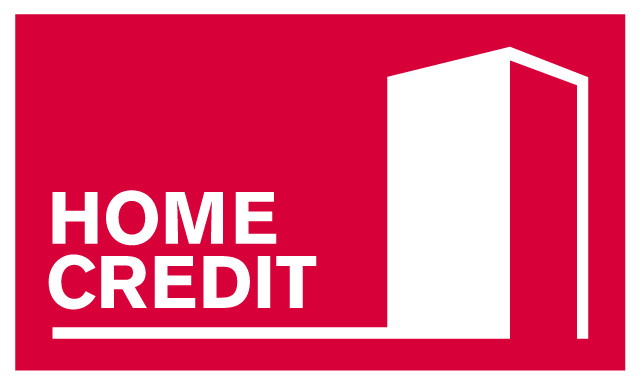

In [4]:
from pyquickhelper.helpgen import NbImage
NbImage("Home_credit_logo_640px.jpg")

In [5]:
path1="data/"
data_files=list(os.listdir(path1))
df_files=pd.DataFrame(data_files,columns=['File_Name'])
df_files['Size_in_MB']=df_files.File_Name.apply(lambda x:round(os.stat(path1+x).st_size/(1024*1024),2))
df_files

File_Name  Size_in_MB
0                application_test.csv       25.34
1               application_train.csv      158.44
2                          bureau.csv      162.14
3                  bureau_balance.csv      358.19
4             credit_card_balance.csv      404.91
5  HomeCredit_columns_description.csv        0.04
6           installments_payments.csv      689.62
7                POS_CASH_balance.csv      374.51
8            previous_application.csv      386.21
9               sample_submission.csv        0.51

In [6]:
def load_all_tables(directory_path="", verbose=True):
    """
    Function to load all the tables required

    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not

    """

    if verbose:
        print("Loading all the tables...")
        start = datetime.now()

    # making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, previous_application

    application_train = pd.read_csv(directory_path + "application_train.csv")
    if verbose:
        print("Loaded 1 table.")

    application_test = pd.read_csv(directory_path + "application_test.csv")
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + "bureau.csv")
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + "bureau_balance.csv")
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + "credit_card_balance.csv")
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(
        directory_path + "installments_payments.csv")
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + "POS_CASH_balance.csv")
    if verbose:
        print("Loaded 7 tables.")

    previous_application = pd.read_csv(
        directory_path + "previous_application.csv")
    if verbose:
        print("Loaded 8 tables.")
        print("Done.")
        print(f"Time Taken to load 8 tables = {datetime.now() - start}")

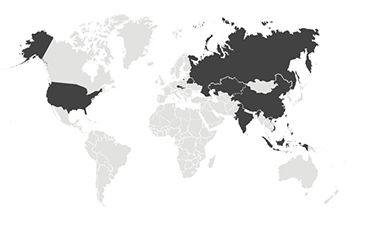

In [7]:
NbImage("home_countries.png")

In [7]:
load_all_tables('data/')

Loading all the tables...
Loaded 1 table.
Loaded 2 tables.
Loaded 3 tables.
Loaded 4 tables.
Loaded 5 tables.
Loaded 6 tables.
Loaded 7 tables.
Loaded 8 tables.
Done.
Time Taken to load 8 tables = 0:00:30.735782


## <span class="bg-info">  Brève description de chaque jeu de données<span> 

### <span class="bg-success">application_{train|test}.csv<span>
    
Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.
    
### <span class="bg-success">bureau.csv<span>
    
Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait au bureau de crédit avant la date de demande.
    
### <span class="bg-success">bureau_balance.csv<span>
    
Soldes mensuels des crédits précédents au Bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent déclaré au bureau de crédit - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un certain historique observable pour les crédits précédents) des lignes.
    
### <span class="bg-success">POS_CASH_balance.csv<span>
    
Les bilans mensuels des anciens points de vente et des prêts en espèces que le demandeur a obtenus grâce au crédit immobilier.
Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le domaine du crédit immobilier (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois au cours desquels nous avons un certain historique observable pour les crédits précédents) des lignes.
    
### <span class="bg-success">credit_card_balance.csv<span>
    
Des instantanés du solde mensuel des cartes de crédit antérieures que le demandeur possède avec Home Credit. Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit antérieur au Crédit immobilier (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de cartes de crédit antérieures relatives * # de mois où nous avons un certain historique observable pour la carte de crédit précédente) des lignes.
    
### <span class="bg-success">previous_application.csv<span>
    
Toutes les demandes de crédit immobilier antérieures des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente relative à des prêts dans notre échantillon.
    
### <span class="bg-success">installments_payments.csv<span>
    
L'historique de remboursement des crédits précédemment déboursés dans le cadre du crédit immobilier en rapport avec les prêts de notre échantillon. Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'un versement OU un versement correspondant à un paiement d'un crédit immobilier antérieur lié aux prêts de notre échantillon.

## <span class="bg-info"> 1. application_train.csv and application_test.csv<span> 

### <span class="bg-warning"> 1.1 Description de la table et de ses colonnes<span>  

- La table __application_train.csv__ est constituée de données statiques relatives aux Emprunteurs avec des étiquettes. Chaque ligne représente une demande de prêt.
- La table ___application_test.csv___ contient l'ensemble de données de test et est similaire à application_train.csv, sauf que la colonne TARGET a été omise, qui doit être prédite à l'aide de modèles statistiques et de modèles prédictifs d'apprentissage automatique.

In [9]:
pd.set_option('display.max_colwidth', 800)
description_colonnes_app_train = pd.read_csv(
    "HomeCredit_columns_description.csv", nrows=122, encoding='latin_1')
del description_colonnes_app_train['Unnamed: 0']
description_colonnes_app_train

Table                           Row  \
0    application_{train|test}.csv                    SK_ID_CURR   
1    application_{train|test}.csv                        TARGET   
2    application_{train|test}.csv            NAME_CONTRACT_TYPE   
3    application_{train|test}.csv                   CODE_GENDER   
4    application_{train|test}.csv                  FLAG_OWN_CAR   
5    application_{train|test}.csv               FLAG_OWN_REALTY   
6    application_{train|test}.csv                  CNT_CHILDREN   
7    application_{train|test}.csv              AMT_INCOME_TOTAL   
8    application_{train|test}.csv                    AMT_CREDIT   
9    application_{train|test}.csv                   AMT_ANNUITY   
10   application_{train|test}.csv               AMT_GOODS_PRICE   
11   application_{train|test}.csv               NAME_TYPE_SUITE   
12   application_{train|test}.csv              NAME_INCOME_TYPE   
13   application_{train|test}.csv           NAME_EDUCATION_TYPE   
14   application_{train|test}.csv            NAME_FAMILY_STATUS   
15   application_{train|test}.csv             NAME_HOUSING_TYPE   
16   application_{train|test}.csv    REGION_POPULATION_RELATIVE   
17   application_{train|test}.csv                    DAYS_BIRTH   
18   application_{train|test}.csv                 DAYS_EMPLOYED   
19   application_{train|test}.csv             DAYS_REGISTRATION   
20   application_{train|test}.csv               DAYS_ID_PUBLISH   
21   application_{train|test}.csv                   OWN_CAR_AGE   
22   application_{train|test}.csv                    FLAG_MOBIL   
23   application_{train|test}.csv                FLAG_EMP_PHONE   
24   application_{train|test}.csv               FLAG_WORK_PHONE   
25   application_{train|test}.csv              FLAG_CONT_MOBILE   
26   application_{train|test}.csv                    FLAG_PHONE   
27   application_{train|test}.csv                    FLAG_EMAIL   
28   application_{train|test}.csv               OCCUPATION_TYPE   
29   application_{train|test}.csv               CNT_FAM_MEMBERS   
30   application_{train|test}.csv          REGION_RATING_CLIENT   
31   application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
32   application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
33   application_{train|test}.csv       HOUR_APPR_PROCESS_START   
34   application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
35   application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
36   application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
37   application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
38   application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
39   application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
40   application_{train|test}.csv             ORGANIZATION_TYPE   
41   application_{train|test}.csv                  EXT_SOURCE_1   
42   application_{train|test}.csv                  EXT_SOURCE_2   
43   application_{train|test}.csv                  EXT_SOURCE_3   
44   application_{train|test}.csv                APARTMENTS_AVG   
45   application_{train|test}.csv              BASEMENTAREA_AVG   
46   application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
47   application_{train|test}.csv               YEARS_BUILD_AVG   
48   application_{train|test}.csv                COMMONAREA_AVG   
49   application_{train|test}.csv                 ELEVATORS_AVG   
50   application_{train|test}.csv                 ENTRANCES_AVG   
51   application_{train|test}.csv                 FLOORSMAX_AVG   
52   application_{train|test}.csv                 FLOORSMIN_AVG   
53   application_{train|test}.csv                  LANDAREA_AVG   
54   application_{train|test}.csv          LIVINGAPARTMENTS_AVG   
55   application_{train|test}.csv                LIVINGAREA_AVG   
56   application_{train|test}.csv       NONLIVINGAPARTMENTS_AVG   
57   application_{train|test}.csv             NONLIVINGAREA_AVG   
58   application_{train|test}.csv               APARTMENTS_MODE   
59   app

In [10]:
with pd.option_context('display.max_rows',application_train.shape[1]):
    train_fs=feature_summary(application_train)
desc = pd.read_csv(
    "HomeCredit_columns_description.csv", encoding='latin_1')

DataFrame shape
rows: 307511
cols: 122


In [11]:
train_fs

Null  Unique_Count Data_type  \
SK_ID_CURR                         0        307511     int64   
TARGET                             0             2     int64   
NAME_CONTRACT_TYPE                 0             2    object   
CODE_GENDER                        0             3    object   
FLAG_OWN_CAR                       0             2    object   
FLAG_OWN_REALTY                    0             2    object   
CNT_CHILDREN                       0            15     int64   
AMT_INCOME_TOTAL                   0          2548   float64   
AMT_CREDIT                         0          5603   float64   
AMT_ANNUITY                       12         13673   float64   
AMT_GOODS_PRICE                  278          1003   float64   
NAME_TYPE_SUITE                 1292             8    object   
NAME_INCOME_TYPE                   0             8    object   
NAME_EDUCATION_TYPE                0             5    object   
NAME_FAMILY_STATUS                 0             6    object   
NAME_HOUSING_TYPE                  0             6    object   
REGION_POPULATION_RELATIVE         0            81   float64   
DAYS_BIRTH                         0         17460     int64   
DAYS_EMPLOYED                      0         12574     int64   
DAYS_REGISTRATION                  0         15688   float64   
DAYS_ID_PUBLISH                    0          6168     int64   
OWN_CAR_AGE                   202929            63   float64   
FLAG_MOBIL                         0             2     int64   
FLAG_EMP_PHONE                     0             2     int64   
FLAG_WORK_PHONE                    0             2     int64   
FLAG_CONT_MOBILE                   0             2     int64   
FLAG_PHONE                         0             2     int64   
FLAG_EMAIL                         0             2     int64   
OCCUPATION_TYPE                96391            19    object   
CNT_FAM_MEMBERS                    2            18   float64   
REGION_RATING_CLIENT               0             3     int64   
REGION_RATING_CLIENT_W_CITY        0             3     int64   
WEEKDAY_APPR_PROCESS_START         0             7    object   
HOUR_APPR_PROCESS_START            0            24     int64   
REG_REGION_NOT_LIVE_REGION         0             2     int64   
REG_REGION_NOT_WORK_REGION         0             2     int64   
LIVE_REGION_NOT_WORK_REGION        0             2     int64   
REG_CITY_NOT_LIVE_CITY             0             2     int64   
REG_CITY_NOT_WORK_CITY             0             2     int64   
LIVE_CITY_NOT_WORK_CITY            0             2     int64   
ORGANIZATION_TYPE                  0            58    object   
EXT_SOURCE_1                  173378        114585   float64   
EXT_SOURCE_2                     660        119832   float64   
EXT_SOURCE_3                   60965           815   float64   
APARTMENTS_AVG                156061          2340   float64   
BASEMENTAREA_AVG              179943          3781   float64   
YEARS_BEGINEXPLUATATION_AVG   150007           286   float64   
YEARS_BUILD_AVG               204488           150   float64   
COMMONAREA_AVG                214865          3182   float64   
ELEVATORS_AVG                 163891           258   float64   
ENTRANCES_AVG                 154828           286   float64   
FLOORSMAX_AVG                 153020           404   float64   
FLOORSMIN_AVG                 208642           306   float64   
LANDAREA_AVG                  182590          3528   float64   
LIVINGAPARTMENTS_AVG          210199          1869   float64   
LIVINGAREA_AVG                154350          5200   float64   
NONLIVINGAPARTMENTS_AVG       213514           387   float64   
NONLIVINGAREA_AVG             169682          3291   float64   
APARTMENTS_MODE               156061           761   float64   
BASEMENTAREA_MODE             179943          3842   float64   
YEARS_BEGINEXPLUATATION_MODE  150007           222   float64   
YEARS_BUILD_MODE              204488           155   float64   


In [12]:
print('FEATURE SUMMARY: Categorical Features')
cat_features=train_fs[train_fs.Data_type=='object'].index
print('Total categorical features:',len(cat_features))
cat_fs=train_fs[train_fs.Data_type=='object']
cat_fs['Desc']=cat_fs.index
for ind in cat_fs['Desc'].values:
    cat_fs.at[ind,'Desc']=desc.Description[(desc.Table=='application') & (desc.Row==ind)].values
display(cat_fs.iloc[:,7:9])
display(cat_fs.iloc[:,:3])

FEATURE SUMMARY: Categorical Features
Total categorical features: 16


Sample_values  \
NAME_CONTRACT_TYPE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [Cash loans, Revolving loans]   
CODE_GENDER                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     [M, F, XNA]   
FLAG_OWN_CAR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [N, Y]   
FLAG_OWN_REALTY                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [Y, N]   
NAME_TYPE_SUITE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Null  Unique_Count Data_type
NAME_CONTRACT_TYPE               0             2    object
CODE_GENDER                      0             3    object
FLAG_OWN_CAR                     0             2    object
FLAG_OWN_REALTY                  0             2    object
NAME_TYPE_SUITE               1292             8    object
NAME_INCOME_TYPE                 0             8    object
NAME_EDUCATION_TYPE              0             5    object
NAME_FAMILY_STATUS               0             6    object
NAME_HOUSING_TYPE                0             6    object
OCCUPATION_TYPE              96391            19    object
WEEKDAY_APPR_PROCESS_START       0             7    object
ORGANIZATION_TYPE                0            58    object
FONDKAPREMONT_MODE          210295             5    object
HOUSETYPE_MODE              154297             4    object
WALLSMATERIAL_MODE          156341             8    object
EMERGENCYSTATE_MODE         145755             3    object

### <span class="bg-warning"> 1.2 Basic Stats<span>

In [13]:
print('-'*100)
print(f'The shape of application_train.csv is: {application_train.shape}')
print('-'*100)
print(
    f'Number of duplicate values in application_train: {application_train.shape[0] - application_train.duplicated().shape[0]}')
print('-'*100)
display(application_train.head())

----------------------------------------------------------------------------------------------------
The shape of application_train.csv is: (307511, 122)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_train: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                      0.0188       -9461           -637            -3648.0   
1                      0.0035      -16765          -1188            -1186.0   
2                      0.0100      -19046           -225            -4260.0   
3                      0.0080      -19005          -3039            -9833.0   
4                      0.0287      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [14]:
print('-'*100)
print(f'The shape of application_test.csv is: {application_test.shape}')
print('-'*100)
print(
    f'Number of duplicate values in application_test: {application_test.shape[0] - application_test.duplicated().shape[0]}')
print('-'*100)
display(application_test.head())

----------------------------------------------------------------------------------------------------
The shape of application_test.csv is: (48744, 121)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_test: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                      0.0188   
1            Married  House / apartment                      0.0358   
2            Married  House / apartment                      0.0191   
3            Married  House / apartment                      0.0264   
4            Married  House / apartment                      0.0100   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

### <span class="bg-warning"> 1.3 Observations et conclusions<span> 

__application_train.csv :__

Le fichier application_train.csv contient environ 307 000 enregistrements et 122 variables. Ces variables contiennent les statistiques personnelles appartenant à un client particulier, telles que son âge, son revenu, le type de prêt, les statistiques sur l'appartement, etc.
Il y a 307k SK_ID_CURR uniques qui représentent des demandes de prêt uniques.
La zone TARGET représente le statut de défaut de paiement du prêt, 0 signifie non défaillant et 1, défaillant.

__application_test.csv :__

Le fichier application_test.csv contient environ 48,7k observations et 121 variables. Ces variables sont exactement celles qui se trouvent dans application_train.csv, sauf que ce sont les ensembles de formation.
Il y a 48,7k SK_ID_CURR uniques qui représentent des demandes de prêt uniques.
La colonne TARGET a été omise et doit être prédite à l'aide de modèles statistiques prédictifs et d'apprentissage automatique.

<function matplotlib.pyplot.show(close=None, block=None)>

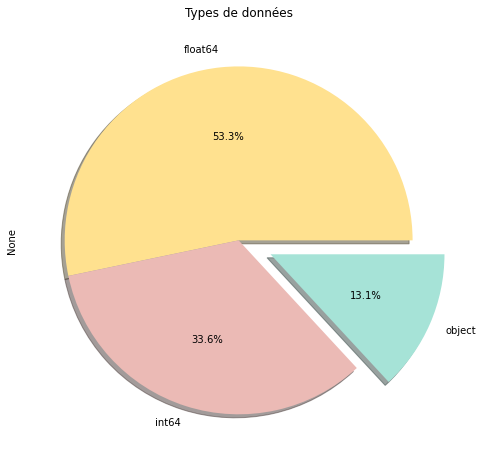

In [15]:
plt.figure(figsize=(12, 8))
application_train.dtypes.value_counts().plot.pie(explode=(0, 0, 0.2),
                                                 autopct='%1.1f%%',
                                                 colors=['#FFE18F',
                                                         '#EBBAB5', '#A6E3D7'],
                                                 shadow=True)
plt.title("Types de données")
plt.show

In [16]:
summarise(application_train)

n_missing   p_missing  n_unique    dtype
COMMONAREA_MEDI                  214865  6.9872e-01      3202  float64
COMMONAREA_AVG                   214865  6.9872e-01      3181  float64
COMMONAREA_MODE                  214865  6.9872e-01      3128  float64
NONLIVINGAPARTMENTS_MODE         213514  6.9433e-01       167  float64
NONLIVINGAPARTMENTS_AVG          213514  6.9433e-01       386  float64
NONLIVINGAPARTMENTS_MEDI         213514  6.9433e-01       214  float64
FONDKAPREMONT_MODE               210295  6.8386e-01         4   object
LIVINGAPARTMENTS_MODE            210199  6.8355e-01       736  float64
LIVINGAPARTMENTS_AVG             210199  6.8355e-01      1868  float64
LIVINGAPARTMENTS_MEDI            210199  6.8355e-01      1097  float64
FLOORSMIN_AVG                    208642  6.7849e-01       305  float64
FLOORSMIN_MODE                   208642  6.7849e-01        25  float64
FLOORSMIN_MEDI                   208642  6.7849e-01        47  float64
YEARS_BUILD_MEDI                 204488  6.6498e-01       151  float64
YEARS_BUILD_MODE                 204488  6.6498e-01       154  float64
YEARS_BUILD_AVG                  204488  6.6498e-01       149  float64
OWN_CAR_AGE                      202929  6.5991e-01        62  float64
LANDAREA_MEDI                    182590  5.9377e-01      3560  float64
LANDAREA_MODE                    182590  5.9377e-01      3563  float64
LANDAREA_AVG                     182590  5.9377e-01      3527  float64
BASEMENTAREA_MEDI                179943  5.8516e-01      3772  float64
BASEMENTAREA_AVG                 179943  5.8516e-01      3780  float64
BASEMENTAREA_MODE                179943  5.8516e-01      3841  float64
EXT_SOURCE_1                     173378  5.6381e-01    114584  float64
NONLIVINGAREA_MODE               169682  5.5179e-01      3327  float64
NONLIVINGAREA_AVG                169682  5.5179e-01      3290  float64
NONLIVINGAREA_MEDI               169682  5.5179e-01      3323  float64
ELEVATORS_MEDI                   163891  5.3296e-01        46  float64
ELEVATORS_AVG                    163891  5.3296e-01       257  float64
ELEVATORS_MODE                   163891  5.3296e-01        26  float64
WALLSMATERIAL_MODE               156341  5.0841e-01         7   object
APARTMENTS_MEDI                  156061  5.0750e-01      1148  float64
APARTMENTS_AVG                   156061  5.0750e-01      2339  float64
APARTMENTS_MODE                  156061  5.0750e-01       760  float64
ENTRANCES_MEDI                   154828  5.0349e-01        46  float64
ENTRANCES_AVG                    154828  5.0349e-01       285  float64
ENTRANCES_MODE                   154828  5.0349e-01        30  float64
LIVINGAREA_AVG                   154350  5.0193e-01      5199  float64
LIVINGAREA_MODE                  154350  5.0193e-01      5301  float64
LIVINGAREA_MEDI                  154350  5.0193e-01      5281  float64
HOUSETYPE_MODE                   154297  5.0176e-01         3   object
FLOORSMAX_MODE                   153020  4.9761e-01        25  float64
FLOORSMAX_MEDI                   153020  4.9761e-01        49  float64
FLOORSMAX_AVG                    153020  4.9761e-01       403  float64
YEARS_BEGINEXPLUATATION_MODE     150007  4.8781e-01       221  float64
YEARS_BEGINEXPLUATATION_MEDI     150007  4.8781e-01       245  float64
YEARS_BEGINEXPLUATATION_AVG      150007  4.8781e-01       285  float64
TOTALAREA_MODE                   148431  4.8269e-01      5116  float64
EMERGENCYSTATE_MODE              145755  4.7398e-01         2   object
OCCUPATION_TYPE                   96391  3.1346e-01        18   object
EXT_SOURCE_3                      60965  1.9825e-01       814  float64
AMT_REQ_CREDIT_BUREAU_HOUR        41519  1.3502e-01         5  float64
AMT_REQ_CREDIT_BUREAU_DAY         41519  1.3502e-01         9  float64
AMT_REQ_CREDIT_BUREAU_WEEK        41519  1.3502e-01         9  float64
AMT_REQ_CREDIT_BUREAU_MON         41519  1.3502e-01        24  float64
AMT_REQ_CREDIT_BUREAU_QRT         41519  1.3502e-01   

#### <span class="bg-success">1.3.1 NaN Columns and Percentages<span>

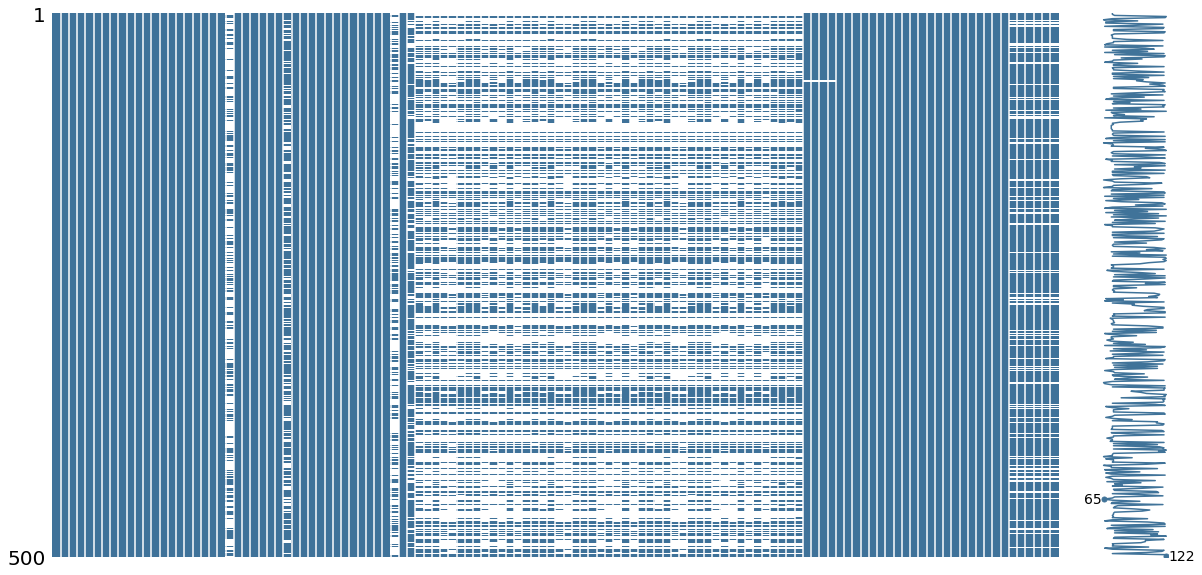

In [17]:
msno.matrix(application_train.sample(500), inline=True, sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

Number of columns having NaN values: 67 columns


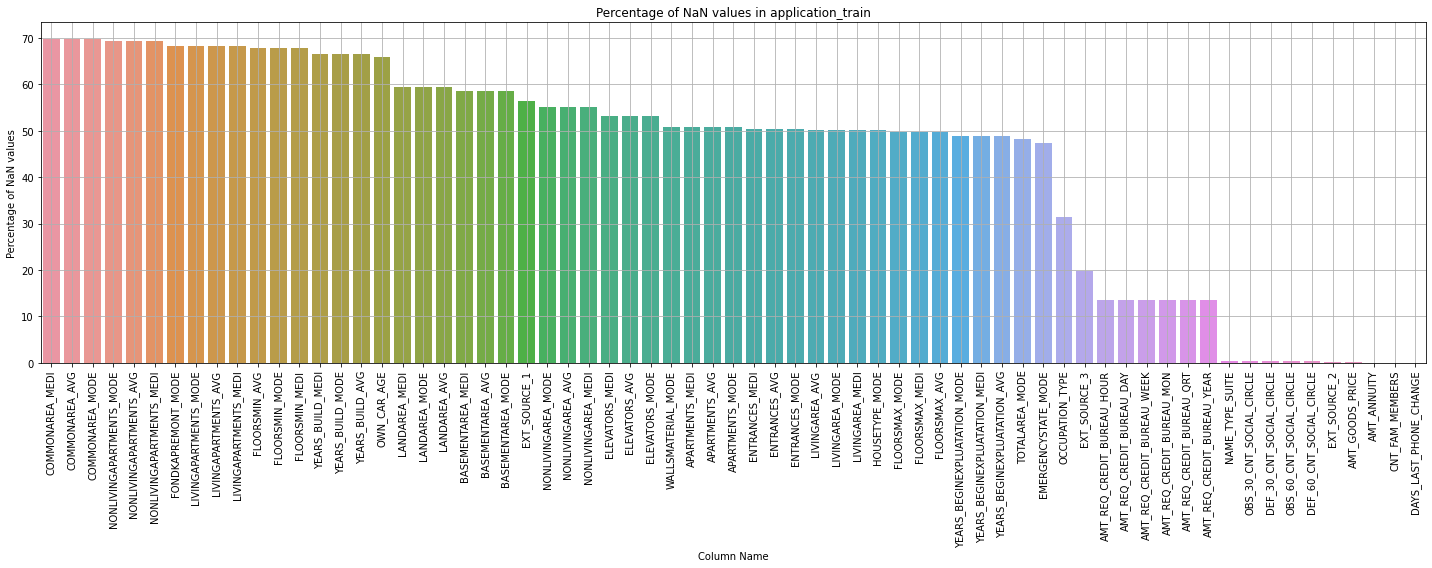

In [18]:
plot_nan_percent(nan_df_create(application_train),
                 'application_train', grid=True)

Number of columns having NaN values: 64 columns


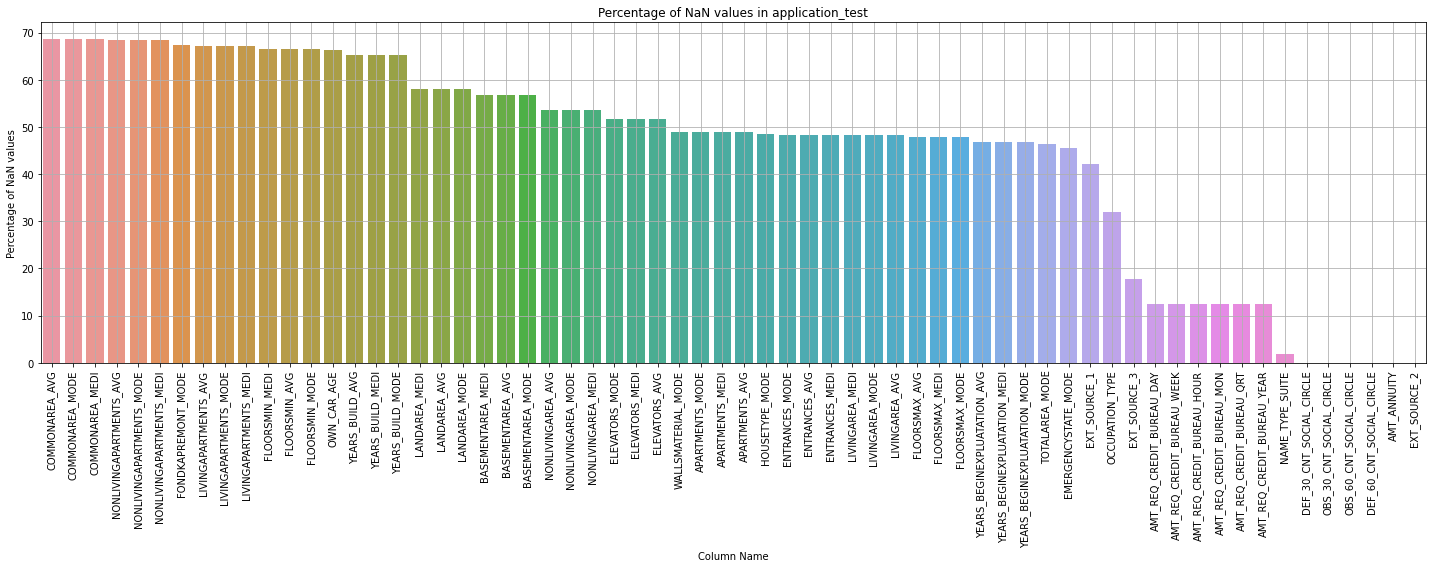

In [19]:
plot_nan_percent(nan_df_create(application_test),
                 'application_test', grid=True)

##### Observations et conclusions :

<ol><li><b>application_train.csv:</b>
    <ul><li>On peut voir sur le graphique ci-dessus qu'il y a 67 colonnes sur 122 caractéristiques qui contiennent des valeurs NaN. S'il n'y avait eu qu'une ou deux colonnes contenant des valeurs NaN, nous aurions pu nous contenter d'éliminer ces colonnes, mais pour un si grand nombre de colonnes, nous ne pouvons pas les supprimer telles quelles, car la perte d'informations pourrait être très importante.<br>
    <li>Nous voyons que certaines colonnes comme celles relatives à "COMMONAREA", "NONLIVINGAPARTMENT", etc. ont près de 70% de valeurs manquantes. Nous devrions trouver des techniques pour traiter ces nombreuses valeurs manquantes et voir ce qui fonctionnerait le mieux pour nos données.
    <li>Il faut également noter que la plupart des colonnes qui comportent plus de 50% de valeurs manquantes sont liées aux statistiques sur les appartements de l'emprunteur. Il est très probable que ces valeurs n'aient pas été enregistrées lors de la saisie des données, et pourraient être facultatives.</ul><br>
    </li>
    <li><b>application_test.csv:</b><ul>
        <li>Il y a un nombre de colonnes avec des valeurs NaN (64) très similaire à celui de l'application_train.</li>
        <li>Les pourcentages de valeurs NaN sont également assez similaires à ceux présents dans l'ensemble des données de formation. Cela signifie que les ensembles de données d'entraînement et de test ont une distribution assez similaire.
        </ul>

Text(0.5, 0, 'Colonnes')

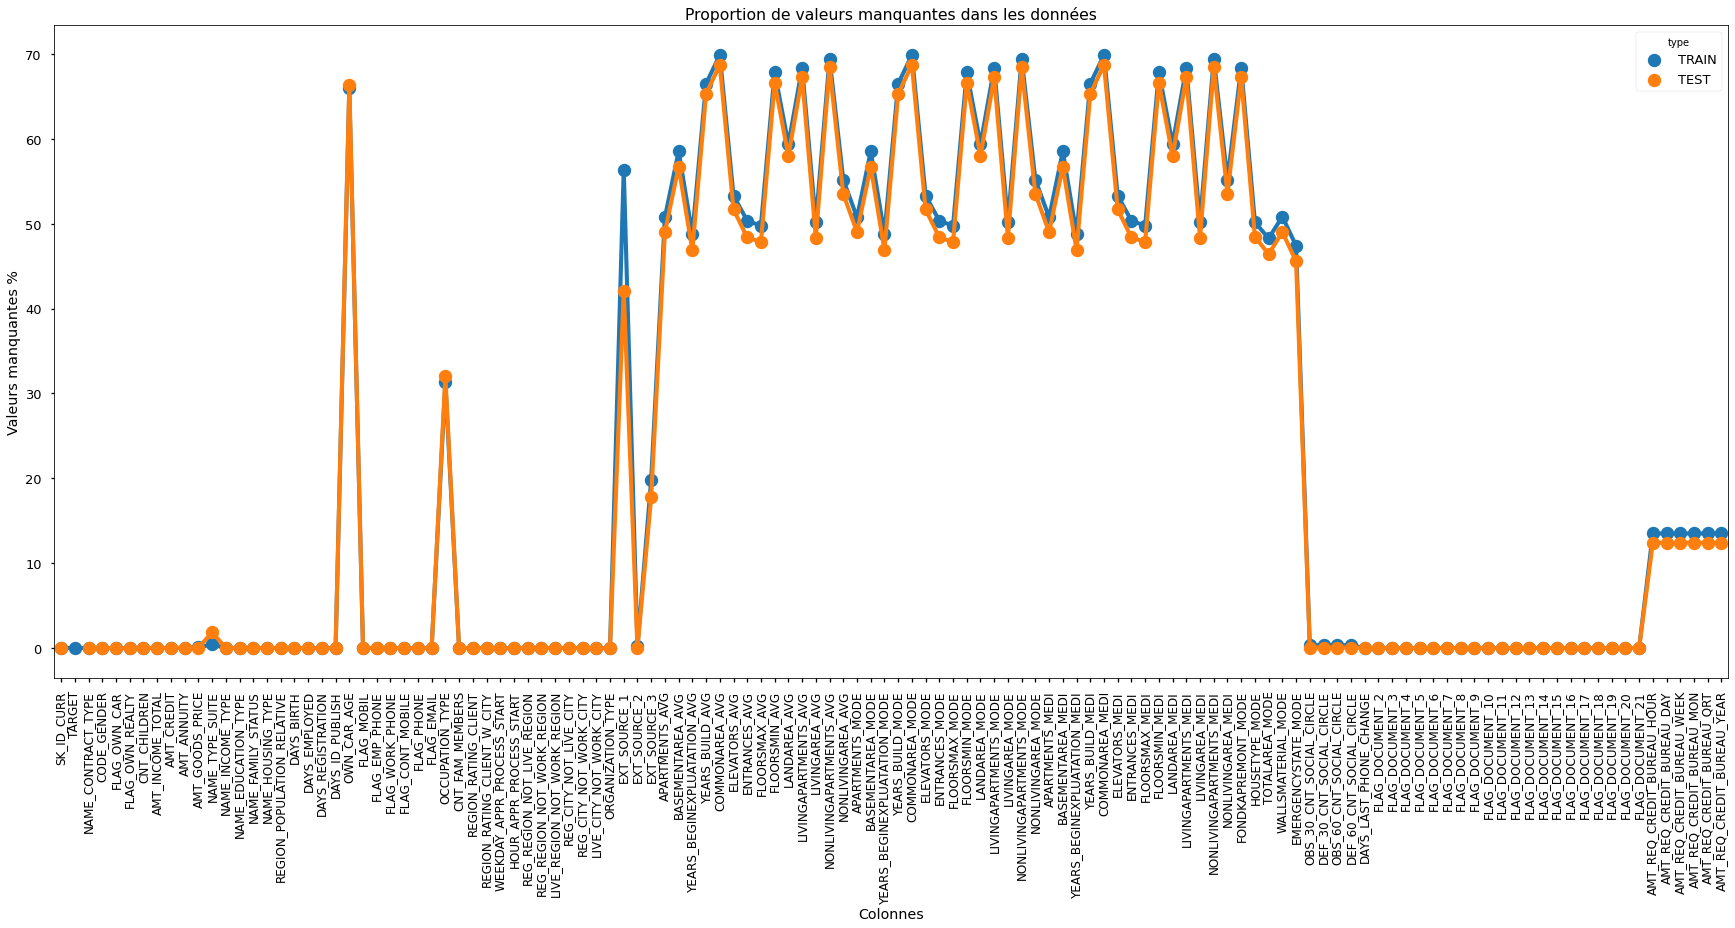

In [20]:
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(30, 12))
miss_train = pd.DataFrame((application_train.isnull().sum())
                          * 100/application_train.shape[0]).reset_index()
miss_test = pd.DataFrame((application_test.isnull().sum())
                         * 100/application_test.shape[0]).reset_index()
miss_train["type"] = "TRAIN"
miss_test["type"] = "TEST"
missing = pd.concat([miss_train, miss_test], axis=0)
ax = sns.pointplot("index", 0, data=missing, hue="type")
plt.xticks(rotation=90, fontsize=12)
plt.title("Proportion de valeurs manquantes dans les données")
plt.ylabel("Valeurs manquantes %")
plt.xlabel("Colonnes")

#### <span class="bg-success">1.3.2 Distribution of Target Variable<span>

In [11]:
target_distribution = application_train.TARGET.value_counts()
labels = ['Non defaulters', 'Defaulters']

fig = go.Figure(data=[
    go.Pie(values=target_distribution, labels=labels, textinfo='label', pull=[0, 0.01])],
    layout=go.Layout())

fig.show()

##### Observations et conclusions :

<ul><li>De la distribution de la variable Target, une chose que nous pouvons rapidement remarquer est le __déséquilibre des données__. Seuls 8,07 % du total des prêts ont été effectivement défaillants. Cela signifie que les défaillants constituent la classe minoritaire. 
    <D'autre part, 91,9 % des prêts n'ont pas fait l'objet d'un défaut de paiement. Ainsi, les non défaillants seront notre classe majoritaire.
    <li> Les défaillants se sont vu attribuer une variable cible de 1 et les non défaillants se sont vu attribuer la variable cible 0.
    <li>Pour les ensembles de données déséquilibrées, lors de la construction du modèle, nous ne pouvons pas alimenter les données telles quelles pour certains algorithmes, qui sont sensibles au déséquilibre.
    <li>C'est le cas des mesures de performance. Pour un tel ensemble de données, l'exactitude n'est généralement pas la bonne mesure car l'exactitude serait généralement biaisée en faveur de la classe majoritaire. Nous pouvons utiliser d'autres mesures telles que le score ROC-AUC, la perte logarithmique, le score F1, la matrice de confusion pour une meilleure évaluation du modèle.
    <li>Une chose plus importante à noter ici est qu'il y a très peu de personnes qui sont réellement en défaut, et elles ont tendance à montrer une sorte de comportement différent. Par conséquent, dans ces cas de fraude, de défaillance et de détection d'anomalies, nous devons également nous concentrer sur les valeurs aberrantes, et nous ne pouvons pas les éliminer, car elles pourraient être le facteur de différenciation entre le défaillant et le non défaillant.

#### <span class="bg-success">1.3.3 Phi-K matrix<span>

Nous tracerons une carte thermique des valeurs du coefficient de corrélation Phi-K entre chacune des caractéristiques et l'autre.
Le coefficient Phi-K est similaire au coefficient de corrélation sauf qu'il peut être utilisé avec une paire de caractéristiques catégorielles pour vérifier si une caractéristique présente une sorte d'association avec l'autre caractéristique catégorielle. Sa valeur maximale peut être 1, ce qui indique une association maximale entre deux variables catégorielles.

----------------------------------------------------------------------------------------------------


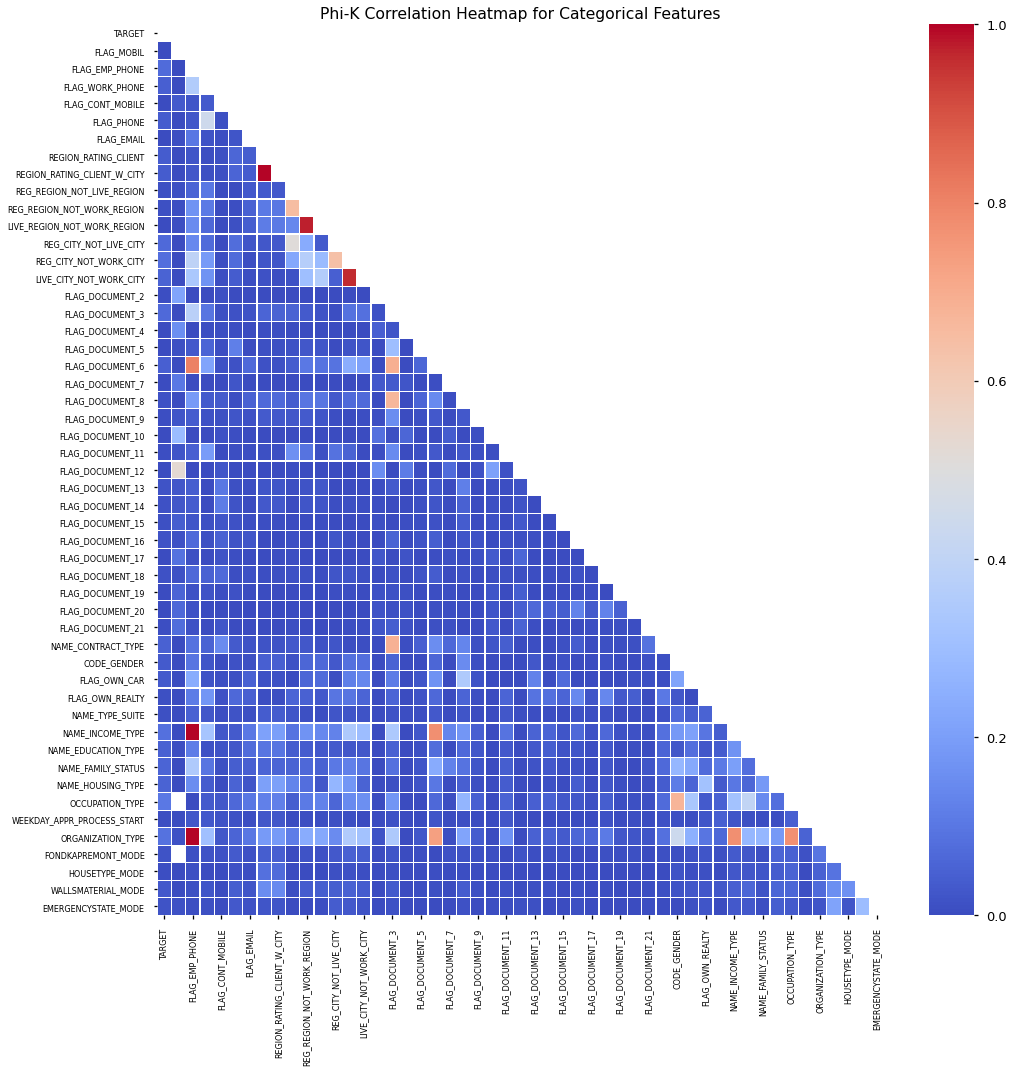

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
43          OCCUPATION_TYPE            0.1028
45        ORGANIZATION_TYPE            0.0892
39         NAME_INCOME_TYPE            0.0848
12   REG_CITY_NOT_WORK_CITY            0.0799
1            FLAG_EMP_PHONE            0.0721
11   REG_CITY_NOT_LIVE_CITY            0.0696
15          FLAG_DOCUMENT_3            0.0695
41       NAME_FAMILY_STATUS            0.0560
42        NAME_HOUSING_TYPE            0.0511
13  LIVE_CITY_NOT_WORK_CITY            0.0510

----------------------------------------------------------------------------------------------------


In [22]:
categorical_columns = ['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                       'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                       'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2, 22)] + application_train.dtypes[
    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns,
                 figsize=(15, 15), fontsize=8, cmap='coolwarm')

##### Observations et conclusions :

<ol><li>D'après la carte thermique de la corrélation Phi-K ci-dessus, nous constatons que la plupart des caractéristiques catégorielles ne sont pas corrélées entre elles, mais que certaines d'entre elles présentent une forte corrélation.</li>
    <li>Certaines des paires de catégories fortement corrélées le sont :
        <ul><li>REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT</li>
            <li>LIVE_REGION_NOT_WORK_REGION and REG_REGION_NOT_WORK_REGION</li>
            <li>NAME_INCOME_TYPE, ORGANIZATION_TYPE and FLAG_EMP_PHONE</li>
        </ul>
    </li>
    <li>Nous pouvons également constater une certaine corrélation entre le type d'organisation et le type de revenu d'un client. De même, nous constatons une corrélation entre le type de profession et le type d'organisation.
    <li>Nous constatons que la catégorie OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY sont parmi les catégories les plus fortement corrélées avec la variable TARGET. Elles sont peut-être importantes pour la tâche de classification, et nécessiteraient d'autres EDA</li></ol>
    

#### <span class="bg-success">1.3.4 Correlation Matrix of Features<span>

Nous tracerons une carte thermique de la corrélation de chaque variable numérique par rapport aux autres variables. Nous avons exclu la colonne SK_ID_CURR, car elle n'a aucune pertinence. Cette carte thermique nous aidera à identifier les caractéristiques numériques fortement corrélées et nous aidera également à identifier les variables qui sont fortement corrélées avec la variable cible.

----------------------------------------------------------------------------------------------------


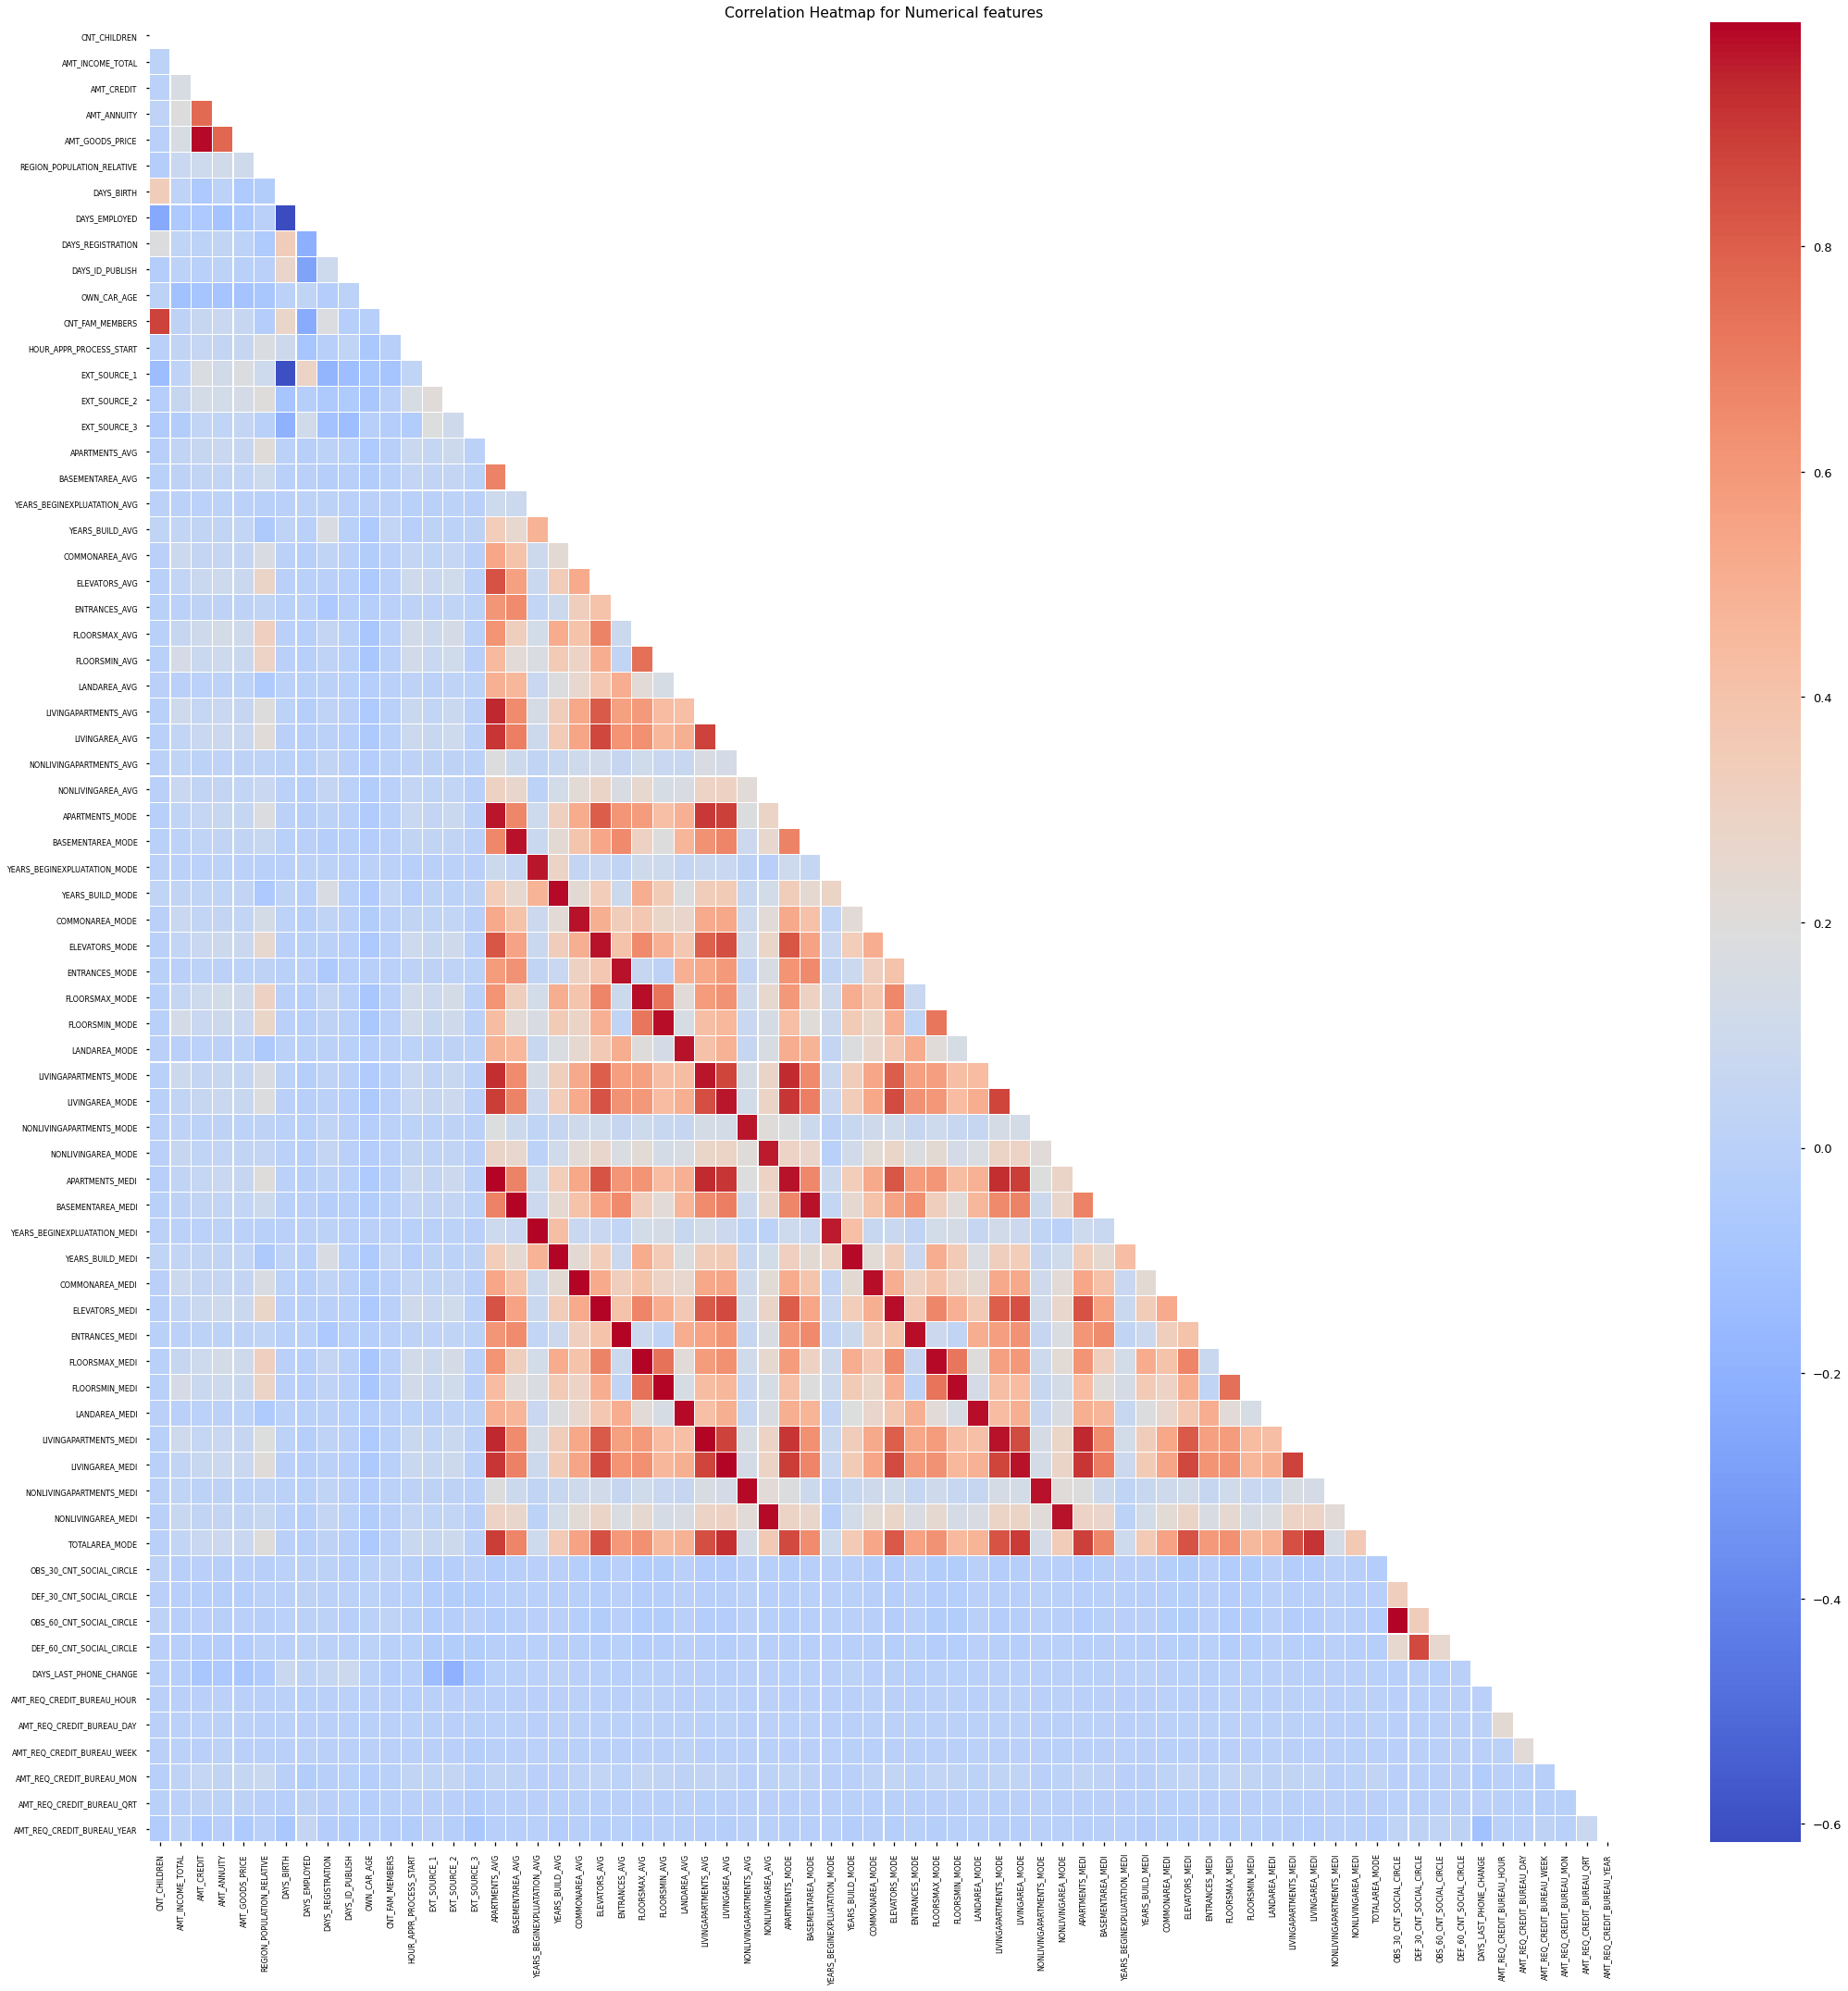

----------------------------------------------------------------------------------------------------


In [23]:
columns_to_drop = ['SK_ID_CURR'] + \
    list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize=(
    30, 30), fontsize=8, cmap='coolwarm')
corr_mat.plot_correlation_matrix()

In [24]:
# Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

Column Name  Phik-Correlation
15            EXT_SOURCE_3            0.2477
13            EXT_SOURCE_1            0.2178
14            EXT_SOURCE_2            0.2140
6               DAYS_BIRTH            0.1024
63  DAYS_LAST_PHONE_CHANGE            0.0732
7            DAYS_EMPLOYED            0.0721
9          DAYS_ID_PUBLISH            0.0678
4          AMT_GOODS_PRICE            0.0591
23           FLOORSMAX_AVG            0.0588
51          FLOORSMAX_MEDI            0.0586

----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

<ol>
    <La carte thermique montre bien la valeur ou le niveau de corrélation entre chaque caractéristique particulière et toutes les autres caractéristiques.
    <li>On peut observer que la plupart des cartes thermiques contiennent une couleur violette, ce qui indique une très faible valeur de corrélation. Cela implique que la plupart des caractéristiques ne sont en effet pas corrélées avec d'autres.</li>
    <li>Cependant, on peut voir des nuances contrastées au milieu de la carte thermique. Ces nuances représentent une valeur élevée de corrélation entre les caractéristiques. Ce sont les caractéristiques qui sont liées aux statistiques des appartements.<br>
        Si nous examinons les caractéristiques d'application_train, nous pouvons clairement voir que les statistiques des appartements sont données en termes de Moyenne, Médiane et Mode, on peut donc s'attendre à ce que la moyenne, la médiane et le mode soient corrélés entre eux. Une autre chose à noter est que les caractéristiques d'une catégorie particulière, par exemple la moyenne, sont également corrélées avec d'autres caractéristiques de la moyenne, telles que le nombre d'ascenseurs, la surface habitable, la surface non habitable, la surface du sous-sol, etc.
    <li>Nous constatons également une forte corrélation entre AMT_GOODS_PRICE et AMT_CREDIT, entre DAYS_EMPLOYED et DAYS_BIRTH. </li>
    <li>Nous ne voudrions pas de caractéristiques fortement corrélées car elles augmentent la complexité temporelle du modèle sans lui apporter beaucoup de valeur ajoutée. Par conséquent, nous supprimerions les caractéristiques inter-corrélées.
    <li> Parmi toutes les caractéristiques, nous constatons une corrélation élevée pour les caractéristiques EXT_SOURCE par rapport à la variable cible. Ces caractéristiques pourraient être importantes pour notre tâche de classification.</ol>

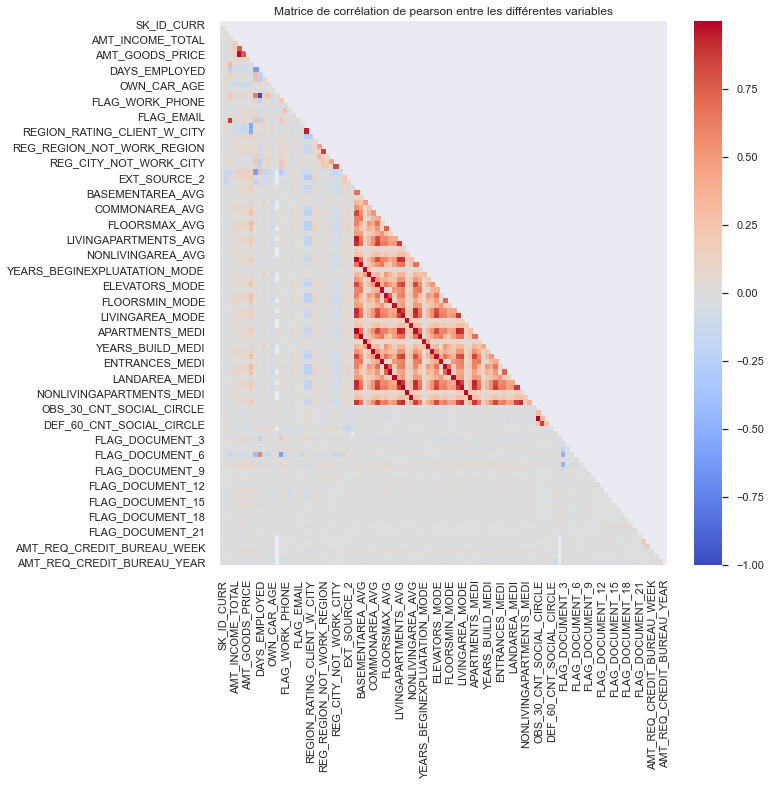

In [25]:
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
plt.title('Matrice de corrélation de pearson entre les différentes variables')

corr = application_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

In [26]:
corrmat = application_train.corr()
n = 10
top10_cols = corrmat.nlargest(n, 'TARGET')['TARGET'].index

<AxesSubplot:>

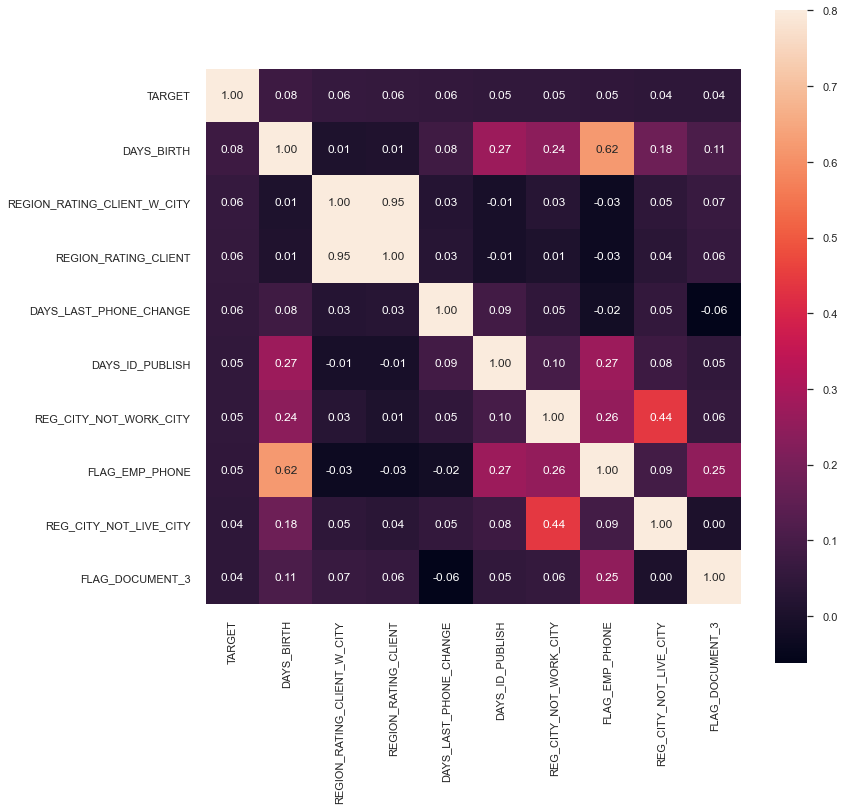

In [27]:
corrmat_top10 = application_train[top10_cols].corr()
fig1, ax1 = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat_top10, vmax=.8, square=True, ax=ax1,
            annot=True, fmt='.2f', annot_kws={'size': 12})

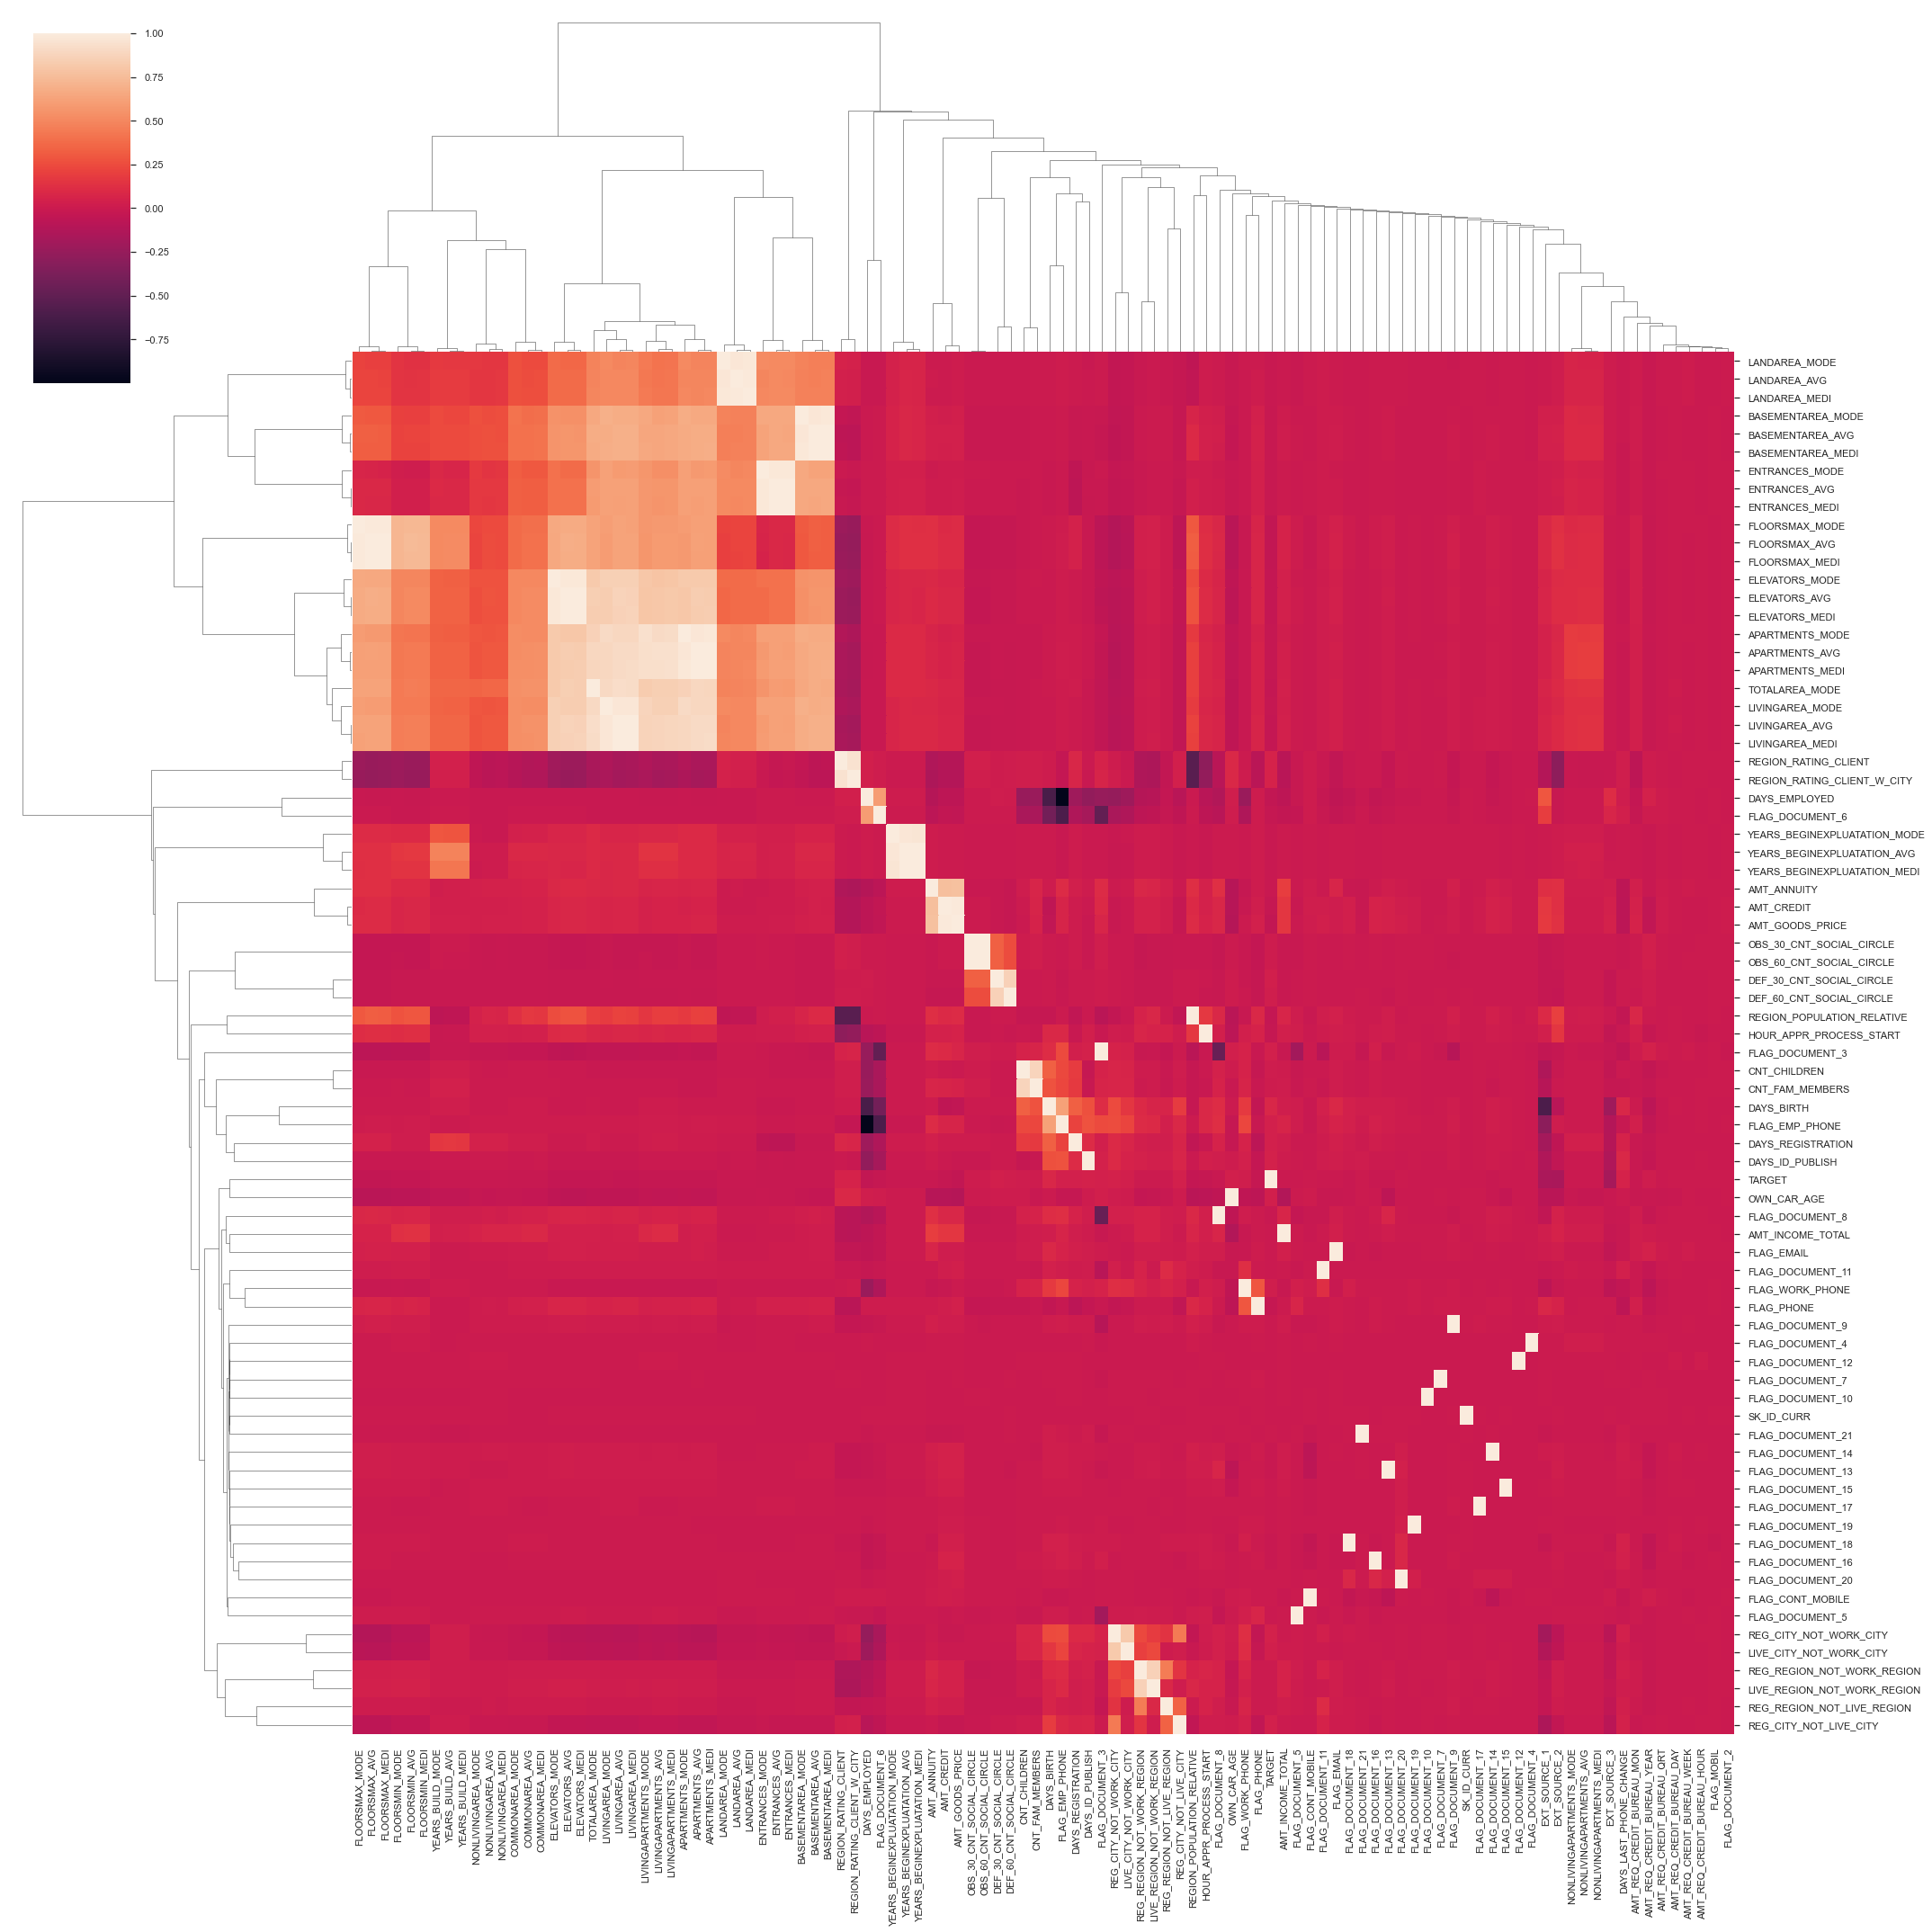

In [28]:
corrs = application_train.corr()
sns.clustermap(corrs.dropna(), figsize=(30, 30))
plt.show()

### <span class="bg-warning">1.4 Plotting Categorical Variables<span>  

#### <span class="bg-success">1.4.1 Distribution de la variable catégorielle NAME_CONTRACT_TYPE<span>  

Cette colonne contient des informations sur le type de prêt pour le demandeur donné. Selon la documentation fournie par Home Credit, il existe deux types de prêts, à savoir les prêts revolving et les prêts cash.

In [29]:
# let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

# plotting the Pie Plot for the column
plot_categorical_variables_pie(
    application_train, 'NAME_CONTRACT_TYPE', hole=0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

De la trame ci-dessus, nous pouvons tirer les observations et conclusions suivantes :
<ol><li> A partir du premier subplot, c'est-à-dire la distribution globale :
        <ul><li>On peut voir que la plupart des prêts que les clients prennent sont des prêts cash.</li>
            <li>Seul 9,52% des personnes ont contracté un prêt revolving.</li></ul></li>
<li>Du deuxième subplot, c'est-à-dire le pourcentage de défaillants :
        <ul><li>Nous constatons qu'il y a un plus grand pourcentage de personnes qui ont fait défaut de paiement avec des prêts cash (8,35 %) par rapport à celles qui ont fait défaut de paiement avec des prêts revolving (5,48 %).</li></ul></li></ol>

#### <span class="bg-success">1.4.2 Distribution de la variable catégorielle NAME_INCOME_TYPE<span>  

Cette colonne contient des informations sur le type de revenu des clients (homme d'affaires, travail, congé de maternité...)

In [12]:
# let us first see the unique categories of 'NAME_INCOME_TYPE'
print_unique_categories(application_train, 'NAME_INCOME_TYPE')

# plotting the Pie Plot for the column
plot_categorical_variables_pie(application_train, 'NAME_INCOME_TYPE', hole=0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_INCOME_TYPE' are:
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


#### <span class="bg-success">1.4.3 Distribution de la variable catégorielle CODE_GENDER<span> 

Cette colonne contient des informations sur le sexe du client/demandeur.
Ici, <b>M</b> signifie <b>Masculin</b> et <b>F</b> signifie <b>Féminin</b>.

In [31]:
# let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(application_train, 'CODE_GENDER', show_counts=True)

# plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole=0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

La distribution de la fonction CODE_GENDER semble intéressante. Voici quelques points de discussion :
<ol><li>Le premier point à observer est qu'il y a 4 lignes dans la table application_train qui ont des genres "XNA", ce qui n'a pas beaucoup de sens, et peut être compté comme des valeurs NaN. Puisqu'elles ne sont que 4 en nombre et n'appartiennent qu'à la catégorie des non défaillants. Nous pouvons donc éliminer ces lignes sans trop d'hésitation.
    <li>Dans le subplot 1, nous constatons que pour l'ensemble de données donné, il y a plus de candidats féminins (65,8 %) que de candidats masculins (34,2 %). </li>
    <li>Cependant, contrairement au nombre de candidates, nous constatons, à partir du deuxième subplot, que les candidats masculins ont tendance à être plus défaillants (10,14%) que les candidates féminines (7%). </li></ol>
Ainsi, on peut dire que les hommes ont plus tendance à ne pas payer leurs dettes que les femmes selon l'ensemble de données donné.

#### <span class="bg-success">1.4.5 Distribution de la variable catégorielle FLAG_EMP_PHONE<span> 
    
Cette colonne est une colonne booléenne, qui indique si le client a fourni ou non son numéro de téléphone au travail.<br>
Ici, <b>1</b> signifie <b>Oui</b> et <b>0</b> signifie <b>Non</b>.

In [32]:
# let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

# plotting the Pie Plot for the Column
plot_categorical_variables_pie(
    application_train, column_name='FLAG_EMP_PHONE', hole=0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

Cette fonction contient deux catégories, à savoir si le client a fourni son numéro de téléphone au travail pendant la procédure d'enregistrement/de demande ou non.
<ol><li>D'après le premier subplot, nous constatons que la plupart des demandeurs ne fournissent pas leur numéro de téléphone professionnel (82 %) et que seulement 18 % ont fourni leur numéro de téléphone professionnel.
On peut également constater que la tendance par défaut pour ceux qui fournissent leur numéro de téléphone au travail est plus élevée que pour ceux qui ne le fournissent pas.
Cette caractéristique pourrait être attribuée au fait que les défaillants pourraient fournir leurs numéros de téléphone professionnels afin de ne pas être dérangés sur leur téléphone personnel.

#### <span class="bg-success">1.4.6 Distribution de la variable catégorielle REGION_RATING_CLIENT_W_CITY<span>

Cette caractéristique est la notation fournie par le Crédit immobilier à la région de chaque client sur la base des enquêtes qu'ils ont pu effectuer. Cette notation tient également compte de la ville dans laquelle le client vit. <br>
La prise en compte de la ville est importante car même si certaines régions ont une bonne note dans une ville particulière, mais que cette ville n'a pas une note élevée, alors le candidat se verrait attribuer une note moyenne et non une note élevée.<br>
Il contient des valeurs comprises entre 1 et 3.

In [33]:
# let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

# plotting the Pie Plot for the Column
plot_categorical_variables_pie(
    application_train, column_name='REGION_RATING_CLIENT_W_CITY')
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

Les tracés ci-dessus nous permettent de tirer les conclusions suivantes :
<ol><li>Dès le premier subplot, nous voyons que la plupart des clients (74,6 %) ont une note de 2 pour la région, ce qui correspond à la valeur moyenne pour la plupart des demandeurs.<br>Très peu de demandeurs ont une note de 1 pour la région (seulement 11,1 %) et certains ont une note de 3 (14,3 %).</li>
    <li> Parmi les défaillants, on constate que la plupart des défaillants ont une note de 3 (11,4%), ce qui est comparativement plus élevé que les deux autres notes, c'est-à-dire que les clients ayant la note 1 ont un pourcentage de défaillances de seulement 4,84% et ceux ayant la note 2 ont un pourcentage de 7,92%.</li>
    </ol>
Cela montre que la note 3 pourrait être un attribut important pour prendre une décision sur les caractéristiques par défaut.


#### <span class="bg-success">1.4.7 Distribution de la variable catégorielle NAME_HOUSING_TYPE<span>

Cette fonction indique quelle est la situation du client en matière de logement (location, vie avec les parents, ...)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_HOUSING_TYPE' are:
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
----------------------------------------------------------------------------------------------------
Counts of each category are:
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_HOUSING_TYPE = 6


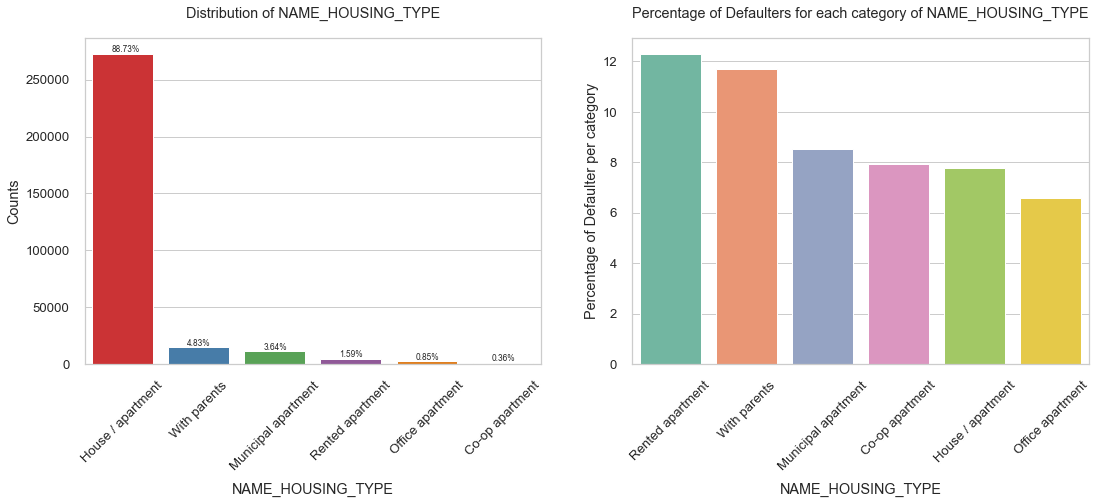

----------------------------------------------------------------------------------------------------


In [34]:
# let us first see the unique categories of 'NAME_HOUSING_TYPE'
print_unique_categories(
    application_train, 'NAME_HOUSING_TYPE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name='NAME_HOUSING_TYPE', rotation=45, horizontal_adjust=0.25)
print('-'*100)

#### <span class="bg-success">1.4.8 Distribution de la variable catégorielle NAME_FAMILY_STATUS<span>

Cette fonction indique le statut marital du client.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_FAMILY_STATUS' are:
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_FAMILY_STATUS = 6


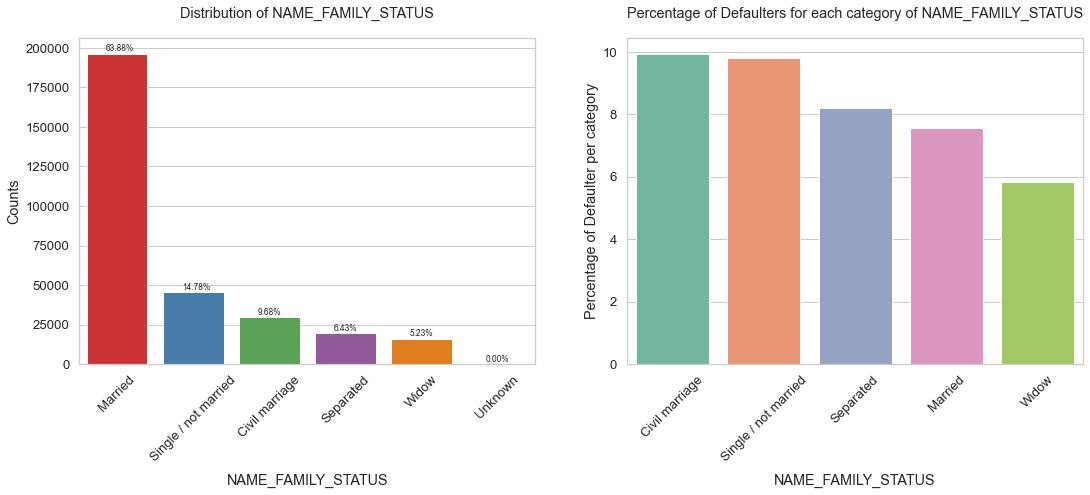

----------------------------------------------------------------------------------------------------


In [18]:
# let us first see the unique categories of 'NAME_FAMILY_STATUS'
print_unique_categories(
    application_train, 'NAME_FAMILY_STATUS', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name='NAME_FAMILY_STATUS', rotation=45, horizontal_adjust=0.25)
print('-'*100)

#### <span class="bg-success">1.4.9 Distribution de la variable catégorielle NAME_EDUCATION_TYPE<span>

Cette fonction indique le niveau d'études le plus élevé que le client a atteint.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


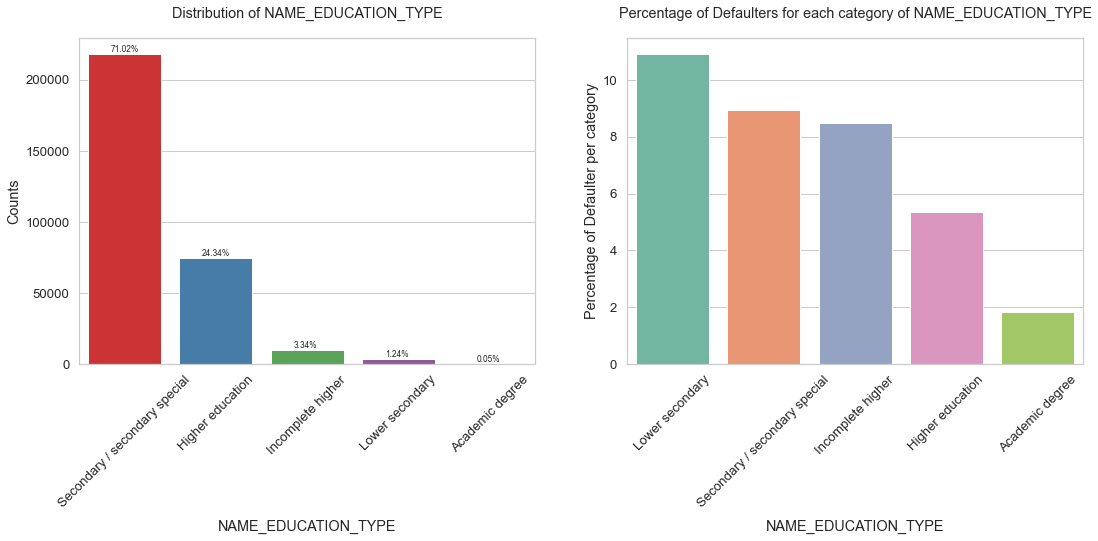

----------------------------------------------------------------------------------------------------


In [19]:
# let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(
    application_train, 'NAME_EDUCATION_TYPE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name='NAME_EDUCATION_TYPE', rotation=45, horizontal_adjust=0.25)
print('-'*100)

##### Observations et conclusions :

En examinant les graphiques ci-dessus, nous pouvons conclure ce qui suit :
<ol><li>A peu près 71% des personnes n'ont fait que des études secondaires ou secondaires spéciales, et 24,34% des clients ont fait des études supérieures. Cela suggère que la plupart des clients/emprunteurs n'ont pas un niveau d'éducation élevé.
    <li>À partir de la deuxième intrigue, nous constatons que les personnes qui ont fait leurs études jusqu'au premier cycle du secondaire seulement ont les plus hauts caractères par défaut, les secondaires et les incomplètes ayant des tendances par défaut similaires.
    <li>Le groupe des personnes ayant fait des études supérieures a une tendance à la défaillance comparativement plus faible, ce qui est logique aussi. De même, les personnes ayant un diplôme universitaire présentent le taux de défaillance le plus faible. Cependant, le groupe des titulaires d'un diplôme universitaire est très peu nombreux, ce qui peut ne pas être très utile.

#### <span class="bg-success">1.4.10 Distribution de la variable catégorielle OCCUPATION_TYPE<span>

Cette fonction indique le type d'activité professionnelle du client. Il peut s'agir d'une caractéristique très importante qui pourrait décrire les caractéristiques par défaut d'un client. 

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


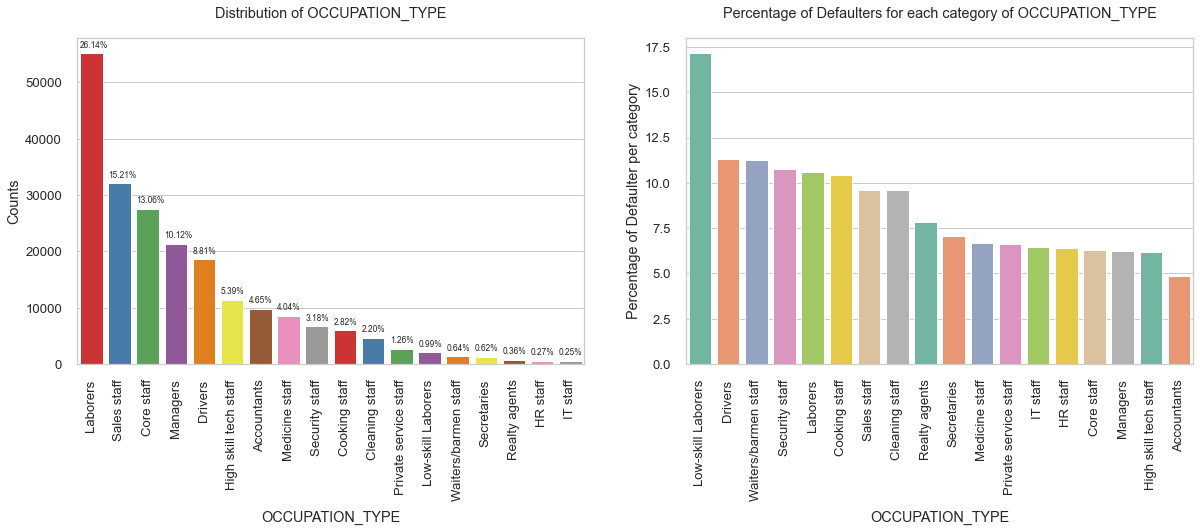

----------------------------------------------------------------------------------------------------


In [37]:
# let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(application_train, 'OCCUPATION_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name='OCCUPATION_TYPE', figsize=(20, 6), rotation=90)
print('-'*100)

##### Observations et conclusions :

A partir des graphiques du secteur d'activité, nous pouvons tirer les observations suivantes :
<Parmi les demandeurs, le type d'emploi le plus courant est celui des ouvriers, qui représente près de 26 % des demandes. La deuxième profession la plus fréquente est celle du personnel de vente, suivie du personnel de base et des cadres.
    <li>Le taux de défaillance des travailleurs peu qualifiés est le plus élevé parmi tous les types de professions (~17,5 %). Il est suivi par les chauffeurs, les serveurs, le personnel de sécurité, les ouvriers, le personnel de cuisine, etc. Tous ces emplois sont des emplois de bas niveau. Tous les emplois sont des emplois de bas niveau. Cela montre que les personnes occupant des emplois de bas niveau ont tendance à avoir un taux de défaillance plus élevé.
    <Li> Les taux de défaillance les plus faibles concernent les comptables, le personnel de base, les gestionnaires, le personnel technique hautement qualifié, le personnel des ressources humaines, etc. qui occupent des postes de niveau moyen à élevé.

On peut donc conclure que les travailleurs de bas niveau ont une plus grande tendance à la défaillance que les travailleurs de niveau moyen à élevé.

#### <span class="bg-success">1.4.11 Distribution de la variable catégorielle ORGANIZATION_TYPE<span>

Tout comme le type de profession, le secteur d'activité auquel le client appartient peut également être une caractéristique importante pour prédire le risque de défaillance de ce client. 

Total Number of categories of ORGANIZATION_TYPE = 58


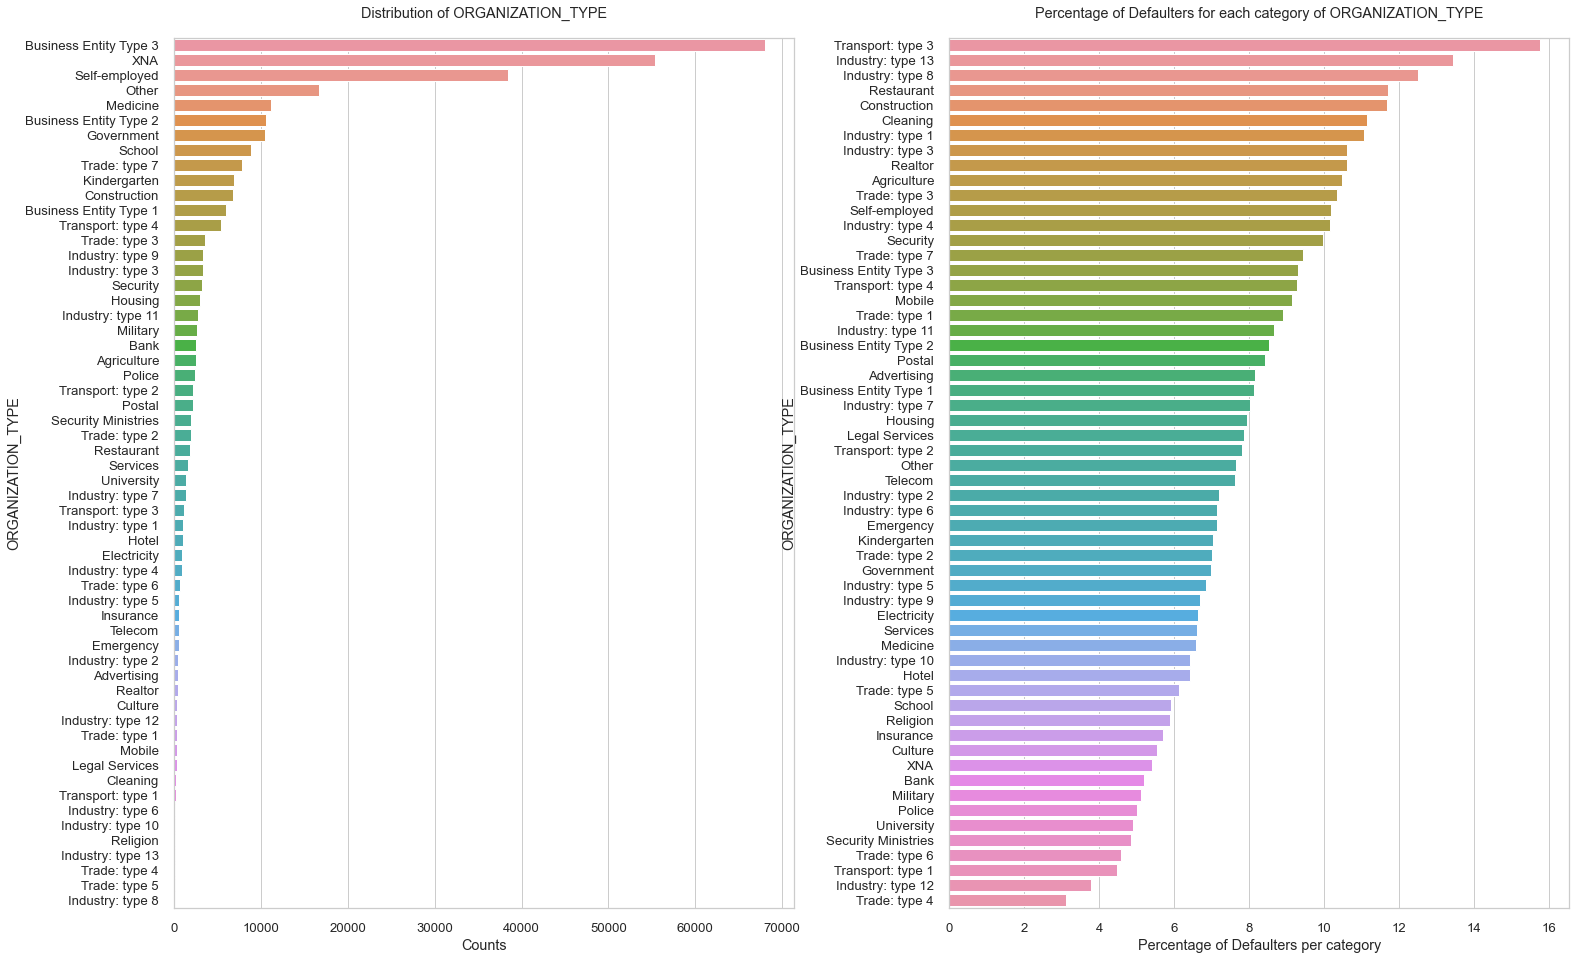

In [38]:
print(
    f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize=(25, 16))
sns.set(style='whitegrid', font_scale=1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1, 2, 1)
count_organization = application_train.ORGANIZATION_TYPE.value_counts(
).sort_values(ascending=False)
sns.barplot(x=count_organization, y=count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad=20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1, 2, 2)
percentage_default_per_organization = application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts(
) * 100 / count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna(
).sort_values(ascending=False)
sns.barplot(x=percentage_default_per_organization,
            y=percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad=20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()

##### Observations et conclusions :

Il existe de nombreux types d'organisations auxquelles le client appartient, 58 pour être précis. Les graphiques ci-dessus donnent les observations suivantes :
<ol><li> Dès le premier graphique, nous constatons que la plupart des demandeurs travaillent dans des organisations de type "entité commerciale de type 3", "XNA" ou "travailleur indépendant". Le type d'organisation "XNA" pourrait probablement désigner une organisation non classée TYPE.</li>
    <li>À partir du deuxième graphique, nous constatons que les candidats appartenant à "Transport : type 3" ont la plus forte tendance à la défaillance par rapport aux autres. Ils sont suivis par les organisations de type : "Industrie : type 13", "Industrie : type 8", "Restaurant", "Construction", etc.
    <Li>Les organisations qui affichent les taux de défaillance les plus faibles sont "Commerce : type 4", "Industrie : type 12", etc.
</ol>
Ces numéros de type en diraient également plus sur l'Organisation, cependant, nous n'avons aucune information à ce sujet, nous nous en tiendrons donc à la dénomination qui nous a été fournie.

#### <span class="bg-success">1.4.12 Distribution de la variable catégorielle REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY<span>
<br><br>
<i>REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY:</i><br>
Ces colonnes comprennent des flags indiquant si l'adresse permanente du client correspond ou non à son adresse de contact donnée pour le prêt ou à son adresse professionnelle au niveau de la région <br><br>
<i><i>LIVE_CITY_NOT_WORK_CITY</i></i>
Cette colonne indique si l'adresse permanente du client correspond ou non à son adresse de contact donnée pour le prêt au niveau de la ville.
Ici, 1 indique des adresses différentes et 0 indique les mêmes adresses.

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


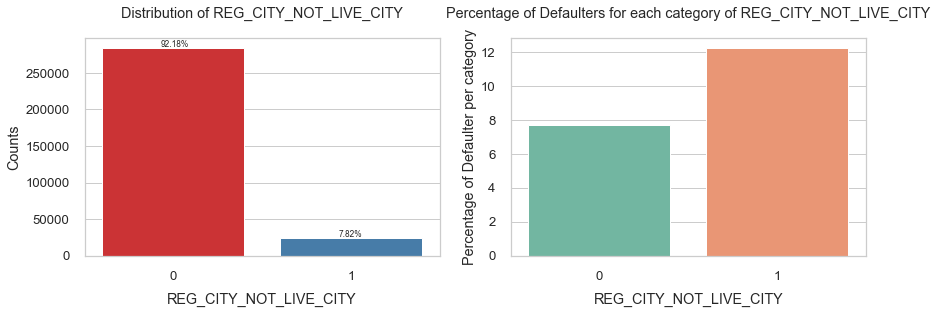

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


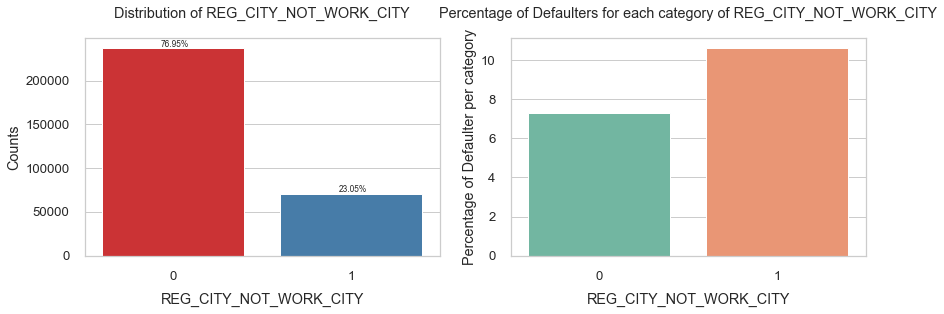

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


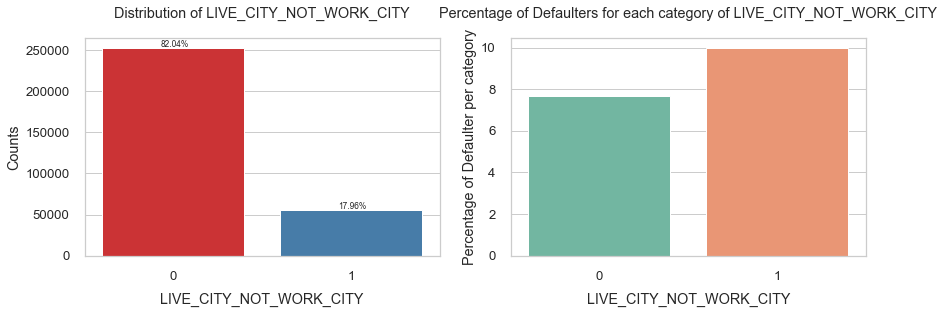

----------------------------------------------------------------------------------------------------


In [39]:
print('-'*100)
plot_categorical_variables_bar(
    application_train, column_name='REG_CITY_NOT_LIVE_CITY', figsize=(14, 4), horizontal_adjust=0.33)
print('-'*100)
plot_categorical_variables_bar(
    application_train, column_name='REG_CITY_NOT_WORK_CITY', figsize=(14, 4), horizontal_adjust=0.33)
print('-'*100)
plot_categorical_variables_bar(
    application_train, column_name='LIVE_CITY_NOT_WORK_CITY', figsize=(14, 4), horizontal_adjust=0.33)
print('-'*100)

##### Observations et conclusions :

Les trois graphiques ci-dessus permettent de tirer les conclusions suivantes :
<ol><li>De tous les candidats, il n'y a qu'une minorité de candidats dont les adresses ne correspondent pas.
    <ul><li>Tout d'abord, 7,52 % seulement des personnes ont une adresse permanente différente de leur adresse de contact au niveau de la région.</li>
        <li>De plus, environ 23,05 % des personnes ont une adresse permanente différente de leur adresse professionnelle au niveau régional. Ce chiffre plus élevé s'explique par le fait qu'il est possible qu'elles travaillent dans une région différente de celle de leur adresse permanente.
        <li>Enfin, environ 17,96% des personnes ont une adresse permanente différente de leur adresse de contact au niveau de la ville.
    </ul>
    <li>
        <ul><li>Si nous examinons les caractéristiques par défaut, nous constatons qu'il y a une tendance maximale à la défaillance des personnes dont l'adresse permanente et l'adresse de contact sont différentes au niveau de la région, qui est suivie par une adresse permanente et une adresse de travail différentes et enfin une adresse permanente et une adresse de contact différentes au niveau de la ville.</li>
            <li>Dans tous les cas, on constate que la tendance par défaut des personnes qui ont des adresses différentes est plus élevée que celle des personnes qui ont la même adresse. Cela signifie que, quelque part, cette différence d'adresse peut suggérer un risque de défaillance.</li>
        </ul>
    </li>
    </ol>

#### <span class="bg-success">1.4.13 Distribution de Categorical Variables FLAG_DOCUMENT_3<span>

Cette colonne contient le flag d'un document qui devait être présenté par le demandeur. Sa valeur est de 0 si le client a fourni le document et de 1 si ce n'est pas le cas.

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


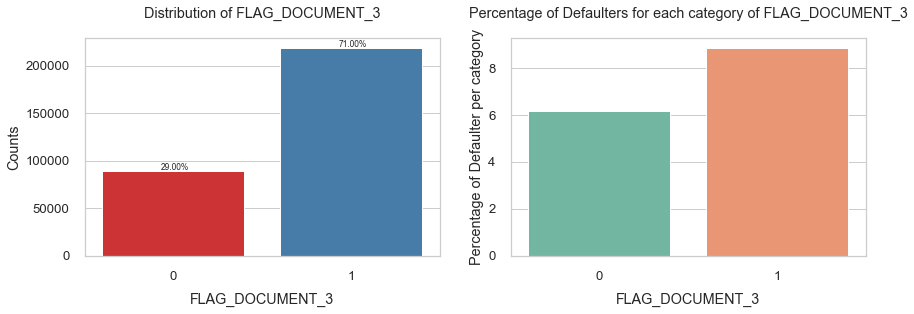

In [40]:
plot_categorical_variables_bar(
    application_train, column_name='FLAG_DOCUMENT_3', figsize=(14, 4), horizontal_adjust=0.33)

##### Observations et conclusions :

C'est ce que l'on voit dans le graphique ci-dessus :
<ol><li>Dès le premier subplot, nous voyons que la plupart des clients n'avaient pas fourni ce document (~71%) et que seulement 29% l'ont fait. </li>
    <li>À partir du deuxième subplot, nous constatons que ceux qui avaient fourni ce document avaient un taux de défaillance plus élevé que ceux qui ne l'avaient pas fait. Cela signifie que les demandeurs qui avaient fourni le Document_3 ont tendance à faire défaut plus souvent que ceux qui n'ont pas fourni ce document. </li>
    <li>Peut-être que cela pourrait être quelque chose en rapport avec le certificat BPL ou autre, mais nous n'avons pas reçu cette information, donc nous ne pouvons rien dire sur le type de document que cela aurait pu être.</li>
</ol>

### <span class="bg-warning">1.5 Plotting Continuous Variables<span>  

#### <span class="bg-success">1.5.1 Distribution de l'âge variable continu du candidat<span>

L'âge est indiqué en jours, ce qui peut être plus difficile à interpréter. Nous allons donc créer une variable latente pour stocker les âges en années, ce qui sera plus facile à analyser et à interpréter.

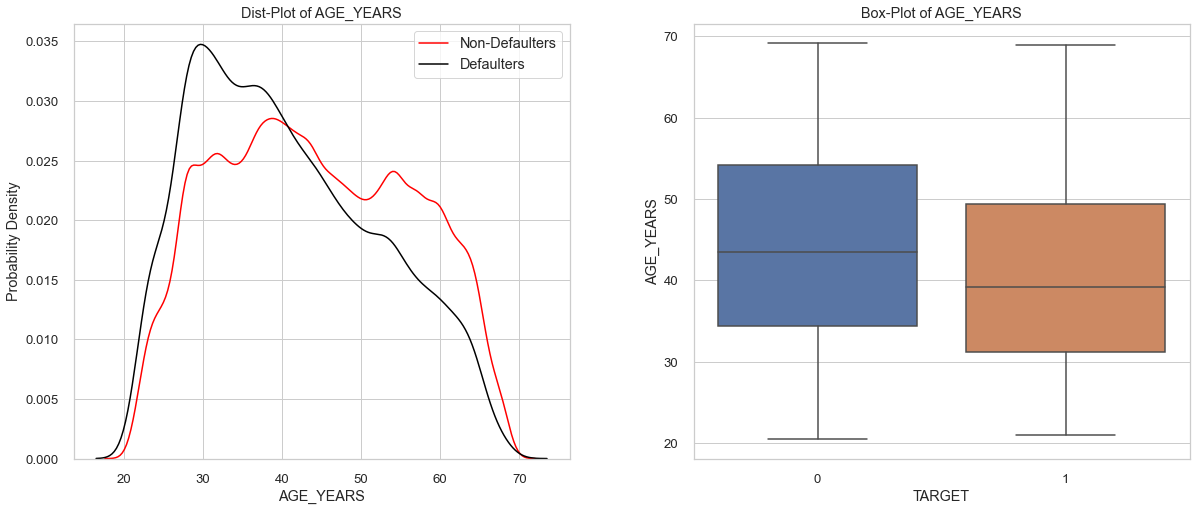

In [41]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(
    application_train, 'AGE_YEARS', plots=['distplot', 'box'])
_ = application_train.pop('AGE_YEARS')

##### Observations et conclusions :

Les deux graphiques ci-dessus nous permettent de tirer des conclusions importantes.
<ol><li>Du dist-Plot, nous pouvons observer le pic d'âge des personnes qui se rapprochent par défaut de 30 ans. En outre, à ce stade, les personnes qui ne sont pas en défaut ont une PDF beaucoup plus petite. Une autre chose à noter est que la PDF de l'âge pour les défaillants commence un peu à gauche de celle des non défaillants, et est également un peu à travers toute la gamme. Cela signifie que les défendeurs sont généralement plus jeunes que les non défendeurs.</li>
    <li>De la même façon, on peut mieux visualiser la même chose avec les box-plots. L'âge des défaillants est généralement inférieur à celui des non défaillants. Tous les quantiles d'âge des défaillants sont inférieurs à ceux des non défaillants. La valeur du 75e centile des non défaillants se situe autour de 54 ans, tandis que pour les défaillants, elle est proche de 49 ans.
Ces observations impliquent que les défaillants sont généralement plus jeunes que les non défaillants.

#### <span class="bg-success">1.5.2 Distribution of Continuous Variables with DAYS features<span>

#### <span class="bg-danger"> DAYS_EMPLOYED<span>

Cette variable indique le nombre de jours à partir du jour de la demande où le demandeur a été employé. Pour faciliter l'interprétation, nous allons convertir les jours en années.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


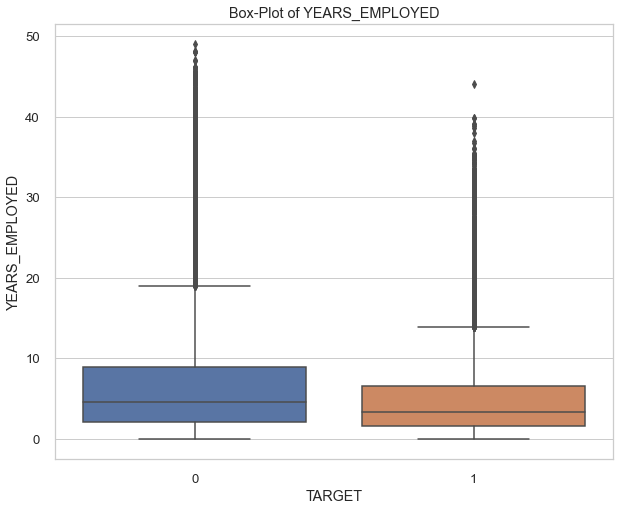

In [42]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
print_percentiles(application_train, 'DAYS_EMPLOYED')
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots=[
                          'box'], scale_limits=[0, 70], figsize=(10, 8))
_ = application_train.pop('YEARS_EMPLOYED')

##### Observations et conclusions :

<ol><li>Nous constatons que la colonne DAYS_EMPLOYED contient des points de données erronés avec les valeurs 365243. Ces valeurs semblent être erronées.
    <li>Sur le box-plot, nous observons que les défaillants semblent avoir moins d'années d'emploi que les non défaillants. Les 25e, 50e et 75e quantiles des défaillants sont tous inférieurs à ceux des non défaillants.

#### <span class="bg-danger"> DAYS_ID_PUBLISH<span>

Cette colonne indique combien de jours, à partir du jour de l'enregistrement, le client a modifié son document d'identité avec lequel il a demandé un prêt.

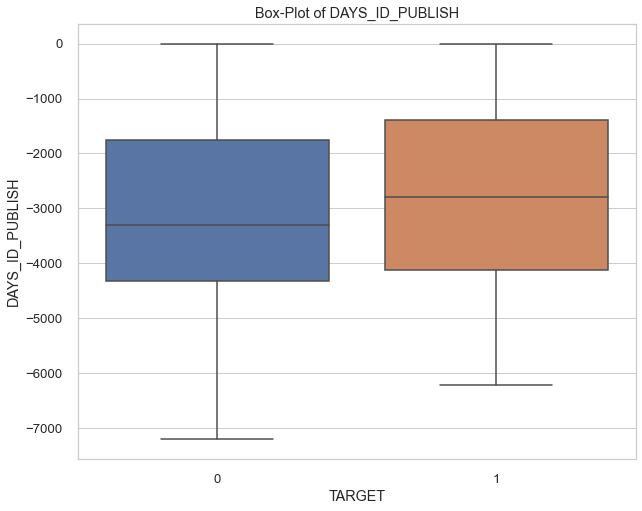

In [43]:
plot_continuous_variables(application_train, 'DAYS_ID_PUBLISH', plots=[
                          'box'], figsize=(10, 8))

##### Observations et conclusions :

Le graphique ci-dessus montre une tendance similaire à celle de DAYS_REGISTRATION, où le nombre de jours écoulés depuis le changement d'identité des défaillants est généralement inférieur. Les non défaillants affichent un nombre de jours plus élevé pour tous les quantiles depuis qu'ils ont changé leur document d'identité.

#### <span class="bg-success">1.5.3 Distribution de EXT_SOURCES<span>

Voici trois colonnes EXT_SOURCES, qui contiennent des valeurs entre 0 et 1. Il s'agit de scores normalisés provenant de différentes sources

----------------------------------------------------------------------------------------------------


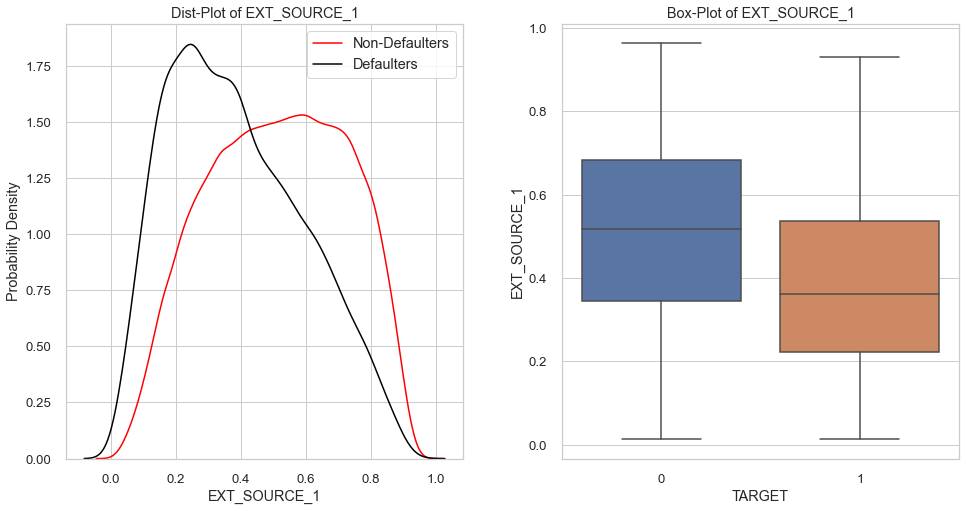

----------------------------------------------------------------------------------------------------


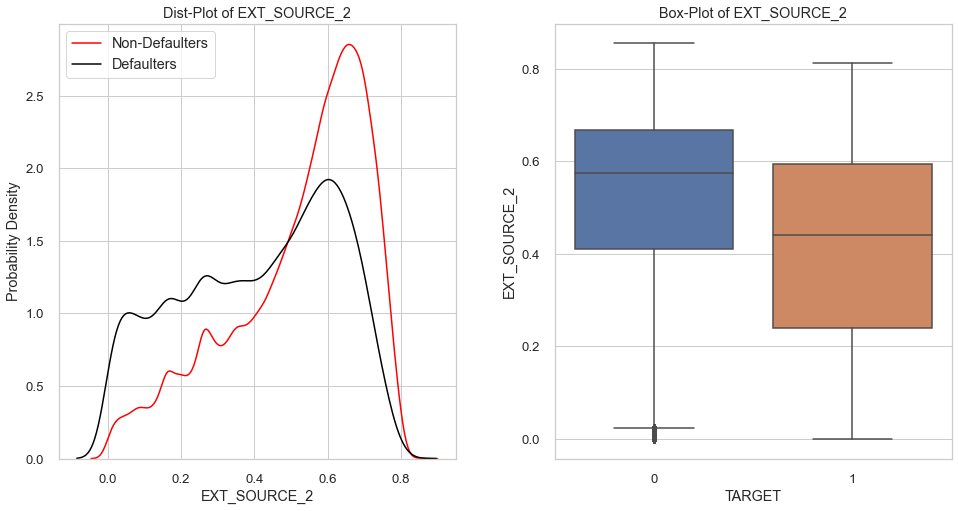

----------------------------------------------------------------------------------------------------


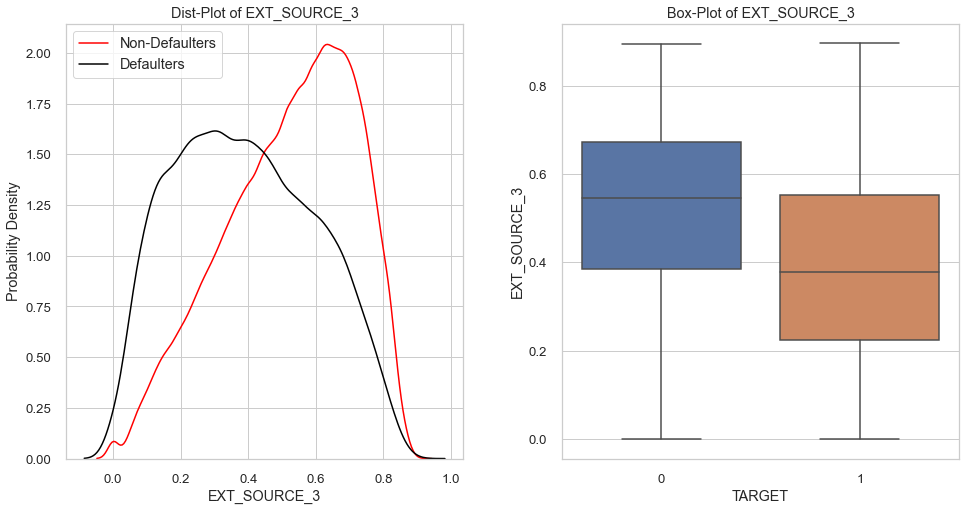

----------------------------------------------------------------------------------------------------


In [44]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots=[
                          'distplot', 'box'], figsize=(16, 8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots=[
                          'distplot', 'box'], figsize=(16, 8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots=[
                          'distplot', 'box'], figsize=(16, 8))
print('-'*100)

##### Observations et conclusions :

Les trois graphiques ci-dessus nous permettent de tirer les conclusions suivantes :
<ol><li>Si nous examinons les graphiques en boîte, nous pouvons clairement voir une tendance similaire pour les trois colonnes EXT_SOURCE, c'est-à-dire que les valeurs par défaut ont tendance à être considérablement plus faibles.
    <li>Cette tendance peut également être observée pour les PDF. Les non défaillants présentent un pic plus élevé pour les valeurs EXT_SOURCE élevées, et les densités de probabilité sont très faibles pour les valeurs faibles. Cela implique que les Non-défaillants ont généralement des valeurs élevées de ces scores.
    <li>Il est intéressant de noter que la valeur médiane pour les défaillants est presque égale ou inférieure aux valeurs du 25e percentile des non défaillants.</li>
    Les colonnes <li>EXT_SOURCE_1 et EXT_SOURCE_3 tendent à montrer une meilleure discrimination/séparabilité par rapport à EXT_SOURCE_2.
Ces 3 caractéristiques semblent être les meilleures pour séparer linéairement les défaillants et les non-défaillants parmi toutes les caractéristiques jusqu'à présent.

In [30]:
data_train = pd.read_csv('train_model_109.csv')
data_test  = pd.read_csv('test_model_108.csv')

In [26]:
ext_data =data[['TARGET', 'EXT_SOURCE_1',
                              'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH', 'CREDIT_ANNUITY_RATIO']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
TARGET                1.0000       -0.0989       -0.1603       -0.1559   
EXT_SOURCE_1         -0.0989        1.0000        0.1350        0.1091   
EXT_SOURCE_2         -0.1603        0.1350        1.0000        0.0941   
EXT_SOURCE_3         -0.1559        0.1091        0.0941        1.0000   
DAYS_BIRTH            0.0782       -0.3622       -0.0919       -0.1785   
CREDIT_ANNUITY_RATIO -0.0321        0.0921        0.0638        0.0208   

                      DAYS_BIRTH  CREDIT_ANNUITY_RATIO  
TARGET                    0.0782               -0.0321  
EXT_SOURCE_1             -0.3622                0.0921  
EXT_SOURCE_2             -0.0919                0.0638  
EXT_SOURCE_3             -0.1785                0.0208  
DAYS_BIRTH                1.0000               -0.1083  
CREDIT_ANNUITY_RATIO     -0.1083                1.0000

Text(0.5, 1.0, 'Correlation Heatmap')

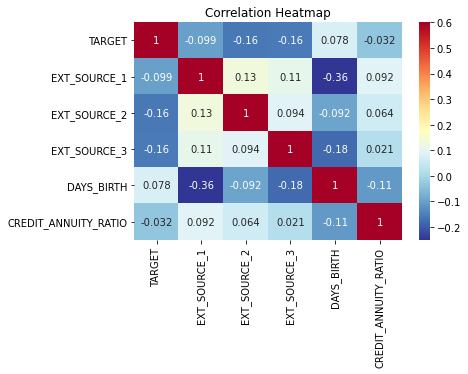

In [27]:
#plt.figure(figsize=(18,18))
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r,
            vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

In [45]:
ext_data = application_train[['TARGET', 'EXT_SOURCE_1',
                              'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.0000       -0.1553       -0.1605       -0.1789      0.0782
EXT_SOURCE_1 -0.1553        1.0000        0.2140        0.1868     -0.6006
EXT_SOURCE_2 -0.1605        0.2140        1.0000        0.1092     -0.0920
EXT_SOURCE_3 -0.1789        0.1868        0.1092        1.0000     -0.2055
DAYS_BIRTH    0.0782       -0.6006       -0.0920       -0.2055      1.0000

Text(0.5, 1.0, 'Correlation Heatmap')

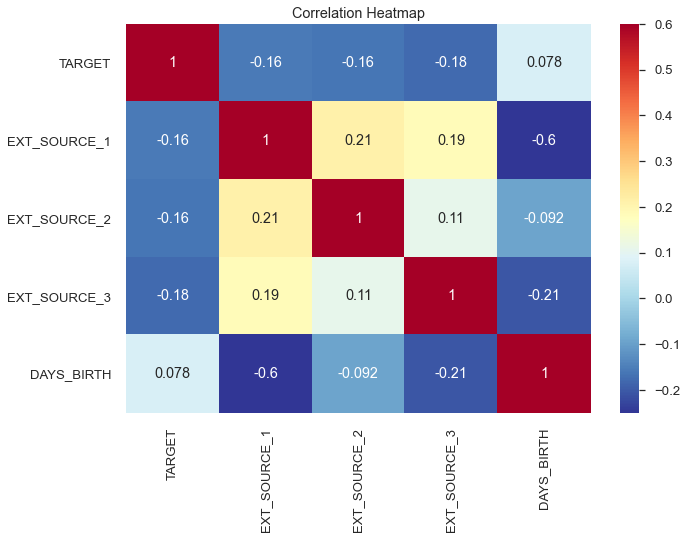

In [46]:
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r,
            vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

#### <span class="bg-success">1.5.4 Distribution de AMT_GOODS_PRICE<span>

Ces colonnes décrivent les scores normalisés de la moyenne du nombre maximum d'étages et du mode du nombre minimum d'étages dans le bâtiment du demandeur 

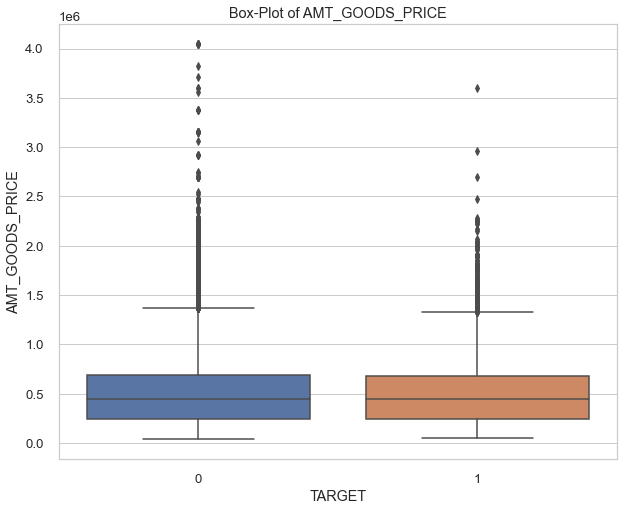

In [47]:
plot_continuous_variables(application_train, 'AMT_GOODS_PRICE', plots=[
                          'box'], figsize=(10, 8))

#### <span class="bg-success">1.5.5 Distribution de FLOORSMAX_AVG et FLOORSMIN_MODE<span>

Ces colonnes décrivent les scores normalisés de la moyenne du nombre maximum d'étages et du mode du nombre minimum d'étages dans le bâtiment du demandeur 

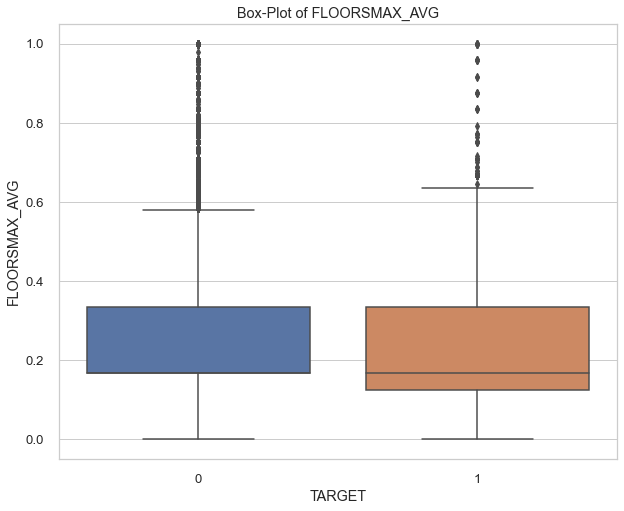

In [48]:
plot_continuous_variables(application_train, 'FLOORSMAX_AVG', plots=[
                          'box'], figsize=(10, 8))

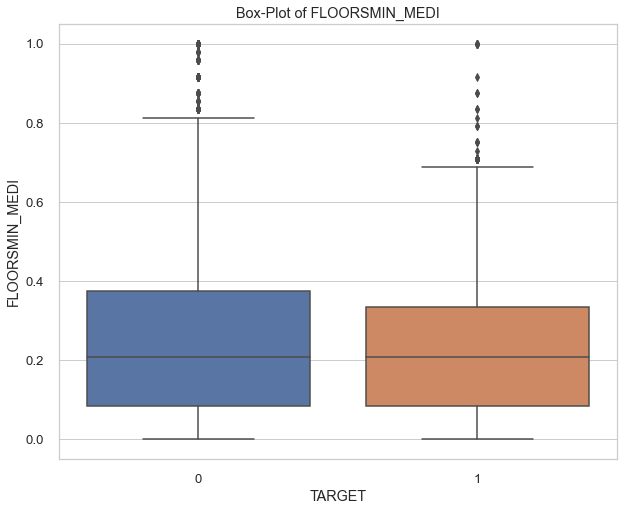

In [49]:
plot_continuous_variables(application_train, 'FLOORSMIN_MEDI', plots=[
                          'box'], figsize=(10, 8))

##### Observations et conclusions

Du graphique ci-dessus, nous pouvons tirer les enseignements suivants :
<ol><li>Les défaillants ont une valeur médiane de la fonction FLOORSMAX_AVG inférieure à celle des non défaillants. Les valeurs du 75e percentile des défaillants et des non défaillants sont plus ou moins les mêmes, mais la valeur du 25e percentile des non défaillants est presque supérieure à la médiane des défaillants, ce qui pourrait donc constituer une caractéristique importante.</li>
    <li>Les non défaillants ont également tendance à afficher une valeur plus élevée de FLLORSMIN_MODE par rapport aux défaillants. La valeur du 75e percentile des non défaillants est significativement plus élevée que celle des défaillants.

## <span class="bg-info"> 2. bureau.csv<span>  

### <span class="bg-warning"> 2.1 Description de la table et de ses colonnes<span>  

Ce tableau comprend tous les antécédents de crédit du client auprès d'institutions financières autres que le Home Credit Group qui ont été signalés par le bureau de crédit.

In [50]:
summarise(bureau)

n_missing   p_missing  n_unique    dtype
AMT_ANNUITY               1226791  7.1473e-01     40321  float64
AMT_CREDIT_MAX_OVERDUE    1124488  6.5513e-01     68251  float64
DAYS_ENDDATE_FACT          633653  3.6917e-01      2917  float64
AMT_CREDIT_SUM_LIMIT       591780  3.4477e-01     51726  float64
AMT_CREDIT_SUM_DEBT        257669  1.5012e-01    226537  float64
DAYS_CREDIT_ENDDATE        105553  6.1496e-02     14096  float64
AMT_CREDIT_SUM                 13  7.5739e-06    236708  float64
CREDIT_ACTIVE                   0  0.0000e+00         4   object
CREDIT_CURRENCY                 0  0.0000e+00         4   object
DAYS_CREDIT                     0  0.0000e+00      2923    int64
CREDIT_DAY_OVERDUE              0  0.0000e+00       942    int64
SK_ID_BUREAU                    0  0.0000e+00   1716428    int64
CNT_CREDIT_PROLONG              0  0.0000e+00        10    int64
AMT_CREDIT_SUM_OVERDUE          0  0.0000e+00      1616  float64
CREDIT_TYPE                     0  0.0000e+00        15   object
DAYS_CREDIT_UPDATE              0  0.0000e+00      2982    int64
SK_ID_CURR                      0  0.0000e+00    305811    int64

<function matplotlib.pyplot.show(close=None, block=None)>

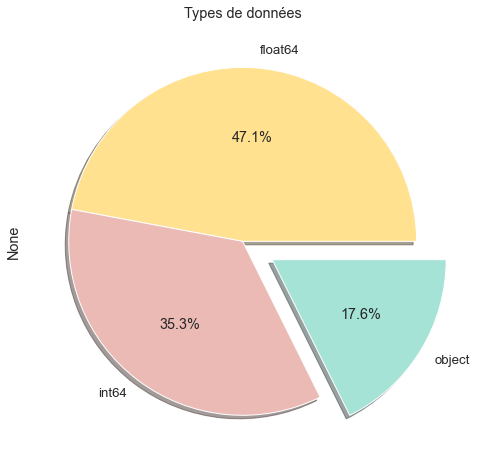

In [51]:
plt.figure(figsize=(12, 8))
bureau.dtypes.value_counts().plot.pie(explode=(0, 0, 0.2),
                                      autopct='%1.1f%%',
                                      colors=['#FFE18F', '#EBBAB5', '#A6E3D7'],
                                      shadow=True)
plt.title("Types de données")
plt.show

In [52]:
description_colonnes = pd.read_csv(
    "HomeCredit_columns_description.csv", encoding='latin_1')
del description_colonnes['Unnamed: 0']
description_colonnes_bureau = description_colonnes.loc[122: 138, :]
description_colonnes_bureau

Table                     Row  \
122  bureau.csv              SK_ID_CURR   
123  bureau.csv            SK_BUREAU_ID   
124  bureau.csv           CREDIT_ACTIVE   
125  bureau.csv         CREDIT_CURRENCY   
126  bureau.csv             DAYS_CREDIT   
127  bureau.csv      CREDIT_DAY_OVERDUE   
128  bureau.csv     DAYS_CREDIT_ENDDATE   
129  bureau.csv       DAYS_ENDDATE_FACT   
130  bureau.csv  AMT_CREDIT_MAX_OVERDUE   
131  bureau.csv      CNT_CREDIT_PROLONG   
132  bureau.csv          AMT_CREDIT_SUM   
133  bureau.csv     AMT_CREDIT_SUM_DEBT   
134  bureau.csv    AMT_CREDIT_SUM_LIMIT   
135  bureau.csv  AMT_CREDIT_SUM_OVERDUE   
136  bureau.csv             CREDIT_TYPE   
137  bureau.csv      DAYS_CREDIT_UPDATE   
138  bureau.csv             AMT_ANNUITY   

                                                                                                             Description  \
122  ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau    
123            Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)   
124                                                                    Status of the Credit Bureau (CB) reported credits   
125                                                                         Recoded currency of the Credit Bureau credit   
126                                   How many days before current application did client apply for Credit Bureau credit   
127                       Number of days past due on CB credit at the time of application for related loan in our sample   
128                                  Remaining duration of CB credit (in days) at the time of application in Home Credit   
129                        Days since CB credit ended at the time of application in Home Credit (only for closed credit)   
130                Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)   
131                                                                How many times was the Credit Bureau credit prolonged   
132                                                                   Current credit amount for the Credit Bureau credit   
133                                                                                 Current debt on Credit Bureau credit   
134                                                        Current credit limit of credit card reported in Credit Bureau   
135                                                                       Current amount overdue on Credit Bureau credit   
136                                                                         Type of Credit Bureau credit (Car, cash,...)   
137                       How many days before loan application did last information about the Credit Bureau credit come   
138                                                                                  Annuity of the Credit Bureau credit   

                                   Special  
122                                 hashed  
123                                 hashed  
124                                    NaN  
125                                recoded  
126  time only relative to the application  
127                                    NaN  
128  time only relative to the application  
129  time only relative to the application  
130                                    NaN  
131                                    NaN  
132                                    NaN  
133                                    NaN  
134                                    NaN  
135                                    NaN  
136                                    NaN  
137  time only relative to the application  
138                                    NaN

### <span class="bg-warning"> 2.2 Basic Stats<span>  

In [53]:
pd.options.display.precision = 8

In [54]:
cols = bureau.iloc[:, 3:]
cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   CREDIT_CURRENCY         object 
 1   DAYS_CREDIT             int64  
 2   CREDIT_DAY_OVERDUE      int64  
 3   DAYS_CREDIT_ENDDATE     float64
 4   DAYS_ENDDATE_FACT       float64
 5   AMT_CREDIT_MAX_OVERDUE  float64
 6   CNT_CREDIT_PROLONG      int64  
 7   AMT_CREDIT_SUM          float64
 8   AMT_CREDIT_SUM_DEBT     float64
 9   AMT_CREDIT_SUM_LIMIT    float64
 10  AMT_CREDIT_SUM_OVERDUE  float64
 11  CREDIT_TYPE             object 
 12  DAYS_CREDIT_UPDATE      int64  
 13  AMT_ANNUITY             float64
dtypes: float64(8), int64(4), object(2)
memory usage: 183.3+ MB


In [55]:
print(f'The shape of bureau.csv is: {bureau.shape}')
print('-'*100)
print(
    f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(
    f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(
    f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

The shape of bureau.csv is: (1716428, 17)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau.csv are: 1716428
Number of unique SK_ID_CURR in bureau.csv are: 305811
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: 42320
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau: 0
----------------------------------------------------------------------------------------------------


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

<h5>Observations et conclusions:</h5>

<ol><li>Le fichier bureau.csv contient près de 1,7 millions de points de données, avec 17 caractéristiques. Sur ces 17 caractéristiques, deux sont SK_ID_CURR et SK_ID_BUREAU.
    <ul><li>SK_ID_BUREAU est l'identifiant du prêt précédent du client auprès d'autres institutions financières. Il peut y avoir plusieurs prêts précédents correspondant à un seul SK_ID_CURR, qui dépend du profil d'emprunt du client.
    <li>SK_ID_CURR est l'identifiant du prêt actuel du client avec Home Credit.
    <Le reste des caractéristiques contient d'autres statistiques telles que DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.
    </ul></li>
    <li>Il y a 305k SK_ID_CURR unique en bureau dont :
        <ul><li>Il y a 263k SK_ID_CURR au bureau qui sont présents dans application_train sur un total de 307k de SK_ID_CURR uniques d'application_train. Cela signifie que certains des demandeurs dans la demande de prêt actuelle avec le Home Credit Group n'ont pas d'antécédents de crédit avec le département du bureau de crédit.<br>
        <De même, 42,3 000 SK_ID_CURR du bureau sont présents dans application_test, sur un total de 48 000 SK_ID_CURR uniques d'application_test.</ul>

#### <span class="bg-success">2.2.1 NaN Columns and Percentages<span>

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 7 columns


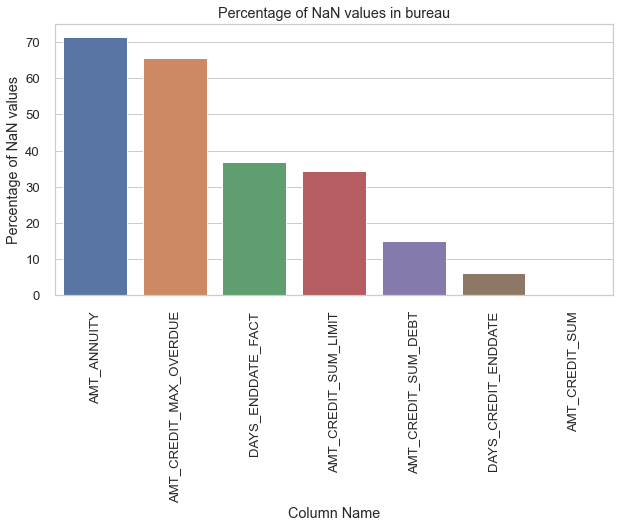

----------------------------------------------------------------------------------------------------


In [56]:
nan_df_bureau = nan_df_create(bureau)
print("-"*100)
plot_nan_percent(nan_df_bureau, 'bureau', tight_layout=False, figsize=(10, 5))
print('-'*100)

##### Observations et conclusions :

<ol><li> Sur 17 variables, 7 contiennent des valeurs de NaN. 
    <li> Les valeurs de NaN les plus élevées sont observées dans la colonne AMT_ANNUITY qui comporte plus de 70 % de valeurs manquantes.</ol>

Text(0.5, 0, 'Colonnes')

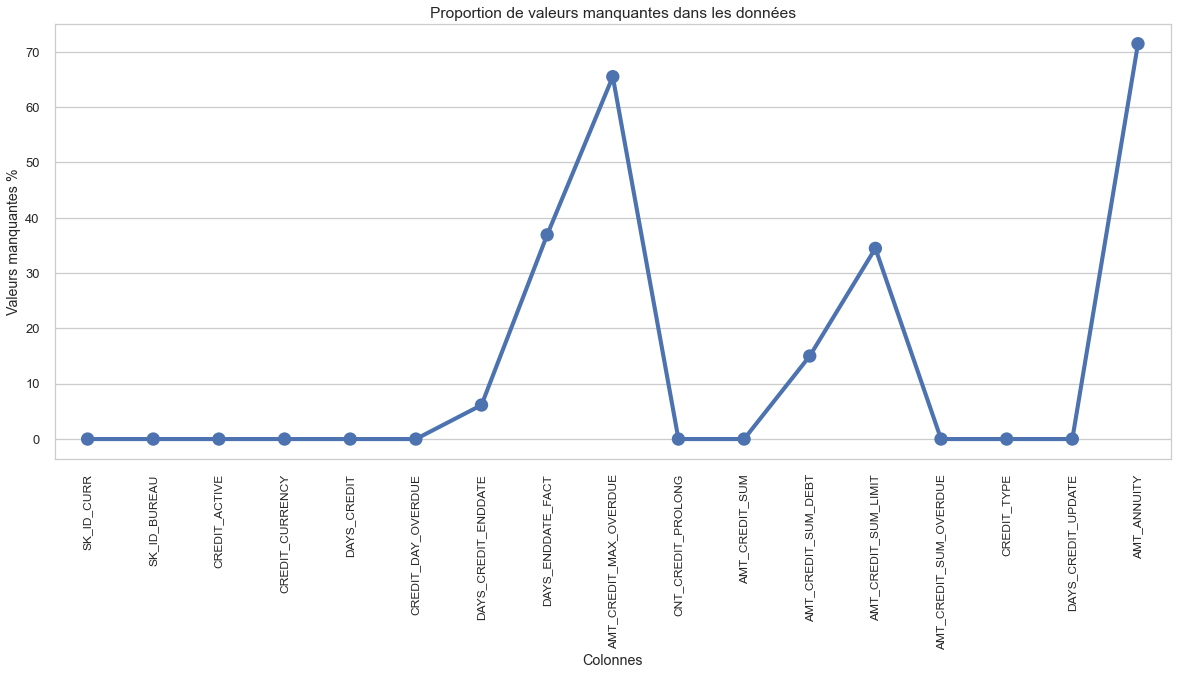

In [57]:
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(20, 8))
miss_bureau = pd.DataFrame((bureau.isnull().sum())
                           * 100/bureau.shape[0]).reset_index()
ax = sns.pointplot("index", 0, data=miss_bureau)
plt.xticks(rotation=90, fontsize=12)
plt.title("Proportion de valeurs manquantes dans les données")
plt.ylabel("Valeurs manquantes %")
plt.xlabel("Colonnes")

#### <span class="bg-success">2.2.2 Merging the TARGETS from application_train to bureau table<span>

In [58]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = application_train.iloc[:, :2].merge(
    bureau, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------


#### <span class="bg-success">2.2.3 Phi-K Matrix<span>

----------------------------------------------------------------------------------------------------


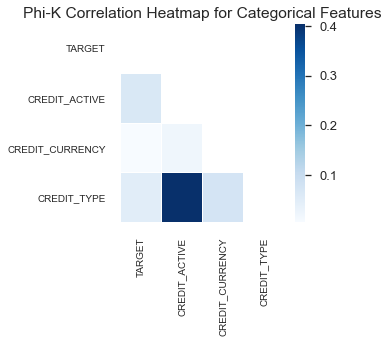

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
0    CREDIT_ACTIVE        0.06448114
2      CREDIT_TYPE        0.04995449
1  CREDIT_CURRENCY        0.00499339

----------------------------------------------------------------------------------------------------


In [59]:
cols_for_phik = ['TARGET', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize=(5, 5))

##### Observations et conclusions :

La carte thermique ci-dessus montre les valeurs de la corrélation Phi-K entre les valeurs catégorielles.
<ol>
<li>À partir du coefficient de corrélation Phi-K, nous voyons que la variable CREDIT_TYPE présente une certaine association avec la variable CREDIT_ACTIVE.</li>
<li>Nous constatons que les variables catégorielles ne sont pas vraiment associées à la variable TARGET, en particulier la fonction CREDIT_CURRENCY.</li>
    </ol>

#### <span class="bg-success">2.2.4  Correlation Matrix of Features<span>

----------------------------------------------------------------------------------------------------


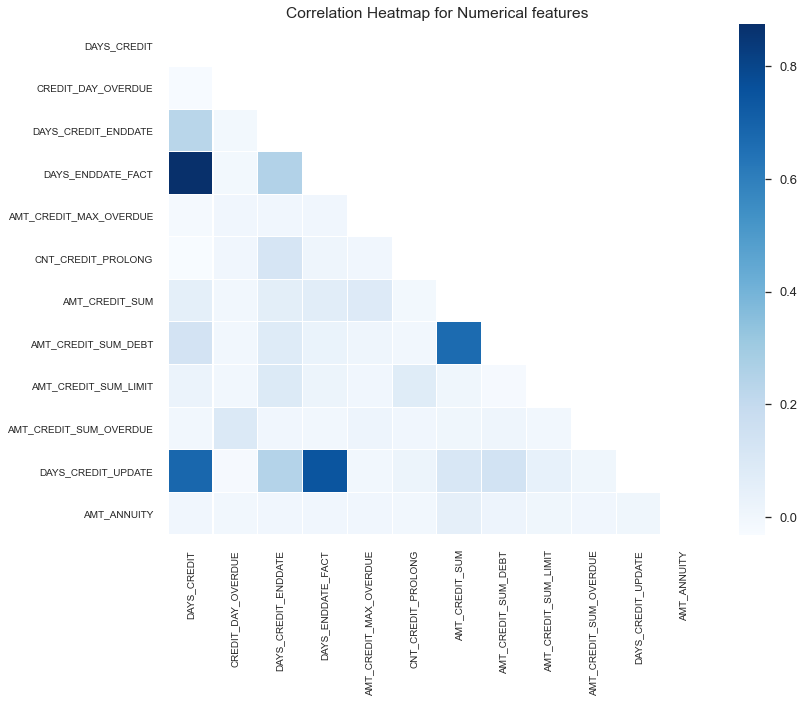

----------------------------------------------------------------------------------------------------


In [60]:
corr_mat = correlation_matrix(
    bureau_merged, ['SK_ID_CURR', 'SK_ID_BUREAU'], cmap='Blues', figsize=(12, 10))
corr_mat.plot_correlation_matrix()

In [61]:
# Seeing the top columns with highest phik-correlation with the target variable in bureau table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT']
interval columns not set, guessing: ['TARGET', 'CREDIT_DAY_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_ENDDATE']
interval columns not set, guessing: ['TARGET', 'DAYS_ENDDATE_FACT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_MAX_OVERDUE']
interval columns not set, guessing: ['TARGET', 'CNT_CREDIT_PROLONG']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_DEBT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_LIMIT']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_SUM_OVERDUE']
interval columns not set, guessing: ['TARGET', 'DAYS_CREDIT_UPDATE']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
0              DAYS_CREDIT        0.08865056
2      DAYS_CREDIT_ENDDATE        0.01898024
9   AMT_CREDIT_SUM_OVERDUE        0.00565368
8     AMT_CREDIT_SUM_LIMIT        0.00519228
4   AMT_CREDIT_MAX_OVERDUE        0.00428034
5       CNT_CREDIT_PROLONG        0.00386188
1       CREDIT_DAY_OVERDUE        0.00252797
10      DAYS_CREDIT_UPDATE        0.00221926
7      AMT_CREDIT_SUM_DEBT        0.00169506
6           AMT_CREDIT_SUM        0.00067001

----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

<ol>
    <La carte thermique ci-dessus montre la corrélation entre chaque caractéristique du tableau du bureau et le reste des caractéristiques.
    <li>On peut observer que la plupart des cartes thermiques ont des couleurs claires, ce qui montre peu ou pas de corrélation.</li>
    <li> Cependant, nous pouvons voir quelques nuances sombres qui représentent une forte corrélation.</li>
    <li>La corrélation élevée est particulièrement observée pour les caractéristiques :
        <ol><li>DAYS_CREDIT et DAYS_CREDIT_UPDATE</li>
            <li>DAYS_ENDDATE_FACT et DAYS_CREDIT_UPDATE</li>
            <li>AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT</li>
            <li>DAYS_ENDDATE_FACT et DAYS_CREDIT</li></ol></li>
    <li>Nous pouvons également constater que les fonctions ne présentent pas particulièrement de corrélation bonne/élevée avec Target en tant que tel, à l'exception de la fonction DAYS_CREDIT. Cela signifie qu'il n'y a pas de relation linéaire directe entre Target et les variables.

### <span class="bg-warning"> 2.3 Tracé des variables catégorielles<span>  

Nous allons maintenant tracer certaines des variables catégorielles du bureau de la table, et voir leur impact sur la variable cible.

#### <span class="bg-success">2.3.1  Distribution de Categorical Variable CREDIT_ACTIVE<span>

Cette colonne décrit l'état du prêt précédent signalé par le bureau de crédit.

----------------------------------------------------------------------------------------------------
The unique categories of 'CREDIT_ACTIVE' are:
['Closed' 'Active' nan 'Sold' 'Bad debt']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CREDIT_ACTIVE = 5


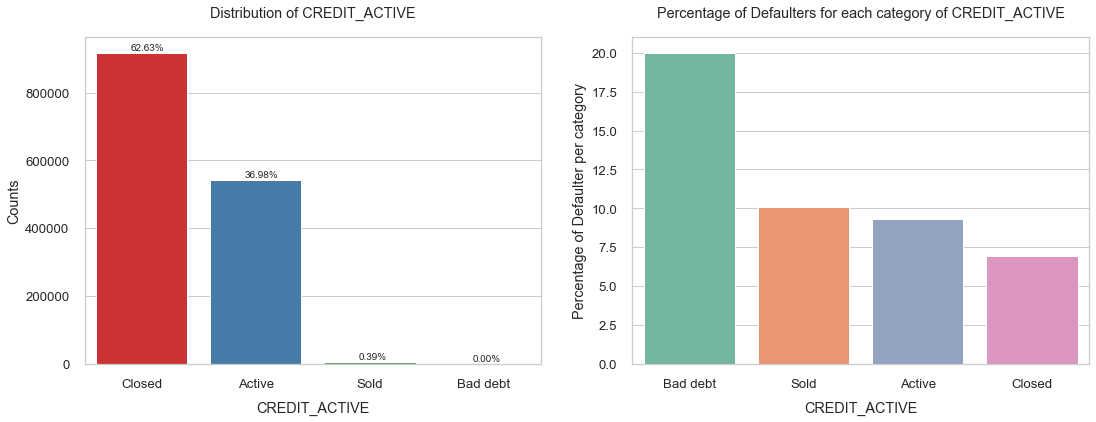

----------------------------------------------------------------------------------------------------


In [62]:
# let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    bureau_merged, column_name='CREDIT_ACTIVE', horizontal_adjust=0.3, fontsize_percent='x-small')
print('-'*100)

##### Observations et conclusions :

Du graphique ci-dessus, nous pouvons tirer les conclusions suivantes :
<ol><li> A partir du premier subplot, nous voyons qu'une majorité des prêts précédents d'autres institutions financières sont des prêts fermés (62,63%), suivis par 36,98% de prêts actifs. Les prêts vendus et les prêts pour créances douteuses sont très peu nombreux.</li>
    <li>Si l'on examine le pourcentage de défaillants par catégorie, on constate qu'environ 20 % des personnes de Bad-Debt ont fait défaut, ce qui est le taux de défaillance le plus élevé. Viennent ensuite les prêts vendus et les prêts actifs. Le taux de défaillance le plus faible concerne les prêts fermés, qui présentent un bon historique de clients. La tendance observée ici est donc tout à fait logique et attendue.

### <span class="bg-warning"> 2.4 Tracé des variables continues<span>  

#### <span class="bg-success">2.4.1 Distribution de Continuous Variable with DAYS Features<span>

#### <span class="bg-danger">DAYS_CREDIT<span>

Cette colonne décrit le nombre de jours avant la demande actuelle lorsque le client a fait une demande de crédit auprès d'un bureau de crédit. Pour faciliter l'interprétation, nous allons convertir ces jours en années.

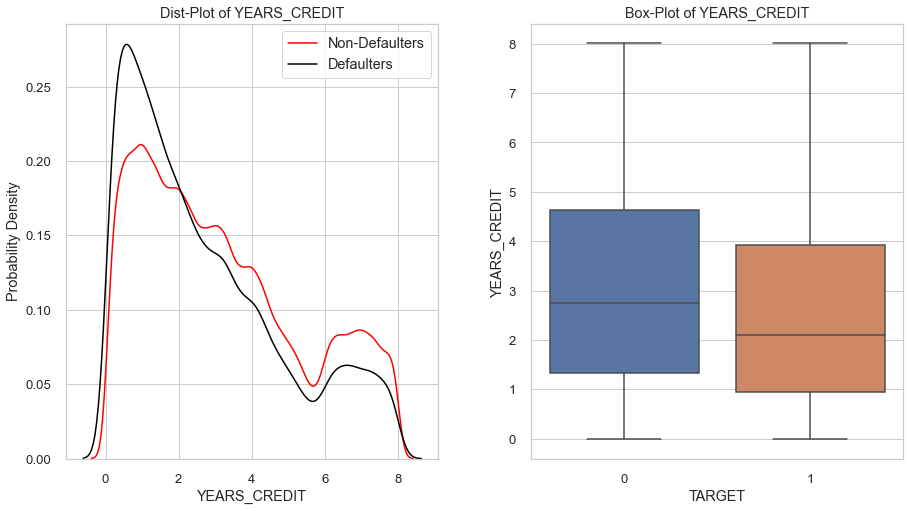

In [63]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots=[
                          'distplot', 'box'], figsize=(15, 8))
_ = bureau_merged.pop('YEARS_CREDIT')

##### Observations et conclusions :

C'est ce que l'on constate à partir des tracés ci-dessus :
<ol><li>D'après le PDF, nous voyons que les défaillants ont tendance à avoir des pics plus élevés que les non défaillants lorsque le nombre d'années est inférieur.. Cela implique que les demandeurs qui ont demandé des prêts au Bureau de crédit récemment ont montré une tendance à la défaillance plus importante que ceux qui ont demandé un prêt il y a longtemps. Le PDF des défaillants est également un peu plus à gauche que celui des non défaillants.
    <li>En examinant le graphique, on constate que les défaillants ont généralement moins d'ANNÉES_CRÉDIT que les non défaillants.

#### <span class="bg-danger">DAYS_CREDIT_ENDDATE<span>

Cette rubrique renseigne sur la durée restante du crédit du Bureau de crédit au moment de la demande de prêt au Crédit immobilier.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2487.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2334.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2202.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2073.9199999999983
The 10th percentile value of DAYS_CREDIT_ENDDATE is -1939.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1144.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -334.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is 473.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


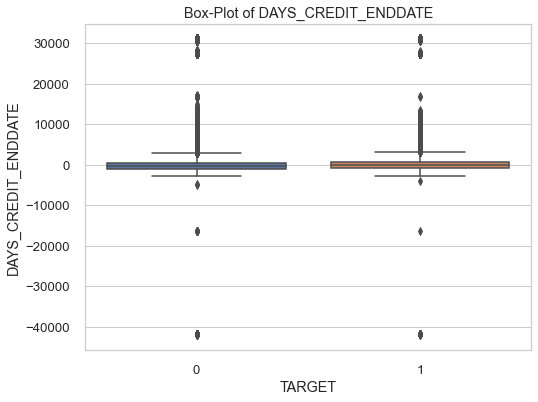

----------------------------------------------------------------------------------------------------


In [64]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE',
                  percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots=[
                          'box'], figsize=(8, 6))
print('-'*100)

##### Observations et conclusions :

D'après les valeurs de percentile ci-dessus, et en regardant le box-plot, nous constatons qu'il semble y avoir une valeur erronée pour DAYS_CREDIT_ENDDATE, où la valeur du 0e percentile remonte à aussi longtemps que 42060 jours ou 115 ans. Cela n'a pas beaucoup de sens, car cela implique que le prêt précédent du client remonte à 115 ans. Il pourrait s'agir d'un prêt hérité également, mais nous ne pouvons pas faire de commentaires aussi sûrs à ce sujet. Nous essaierions de supprimer ces valeurs lors de la phase de prétraitement des données.

#### <span class="bg-danger">DAYS_ENDDATE_FACT<span>

Cette colonne indique le nombre de jours écoulés depuis la fin du crédit du Bureau de crédit au moment de la demande de prêt au Crédit immobilier. Ces valeurs ne concernent que les crédits fermés.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 2th percentile value of DAYS_ENDDATE_FACT is -2561.0
The 4th percentile value of DAYS_ENDDATE_FACT is -2450.0
The 6th percentile value of DAYS_ENDDATE_FACT is -2351.0
The 8th percentile value of DAYS_ENDDATE_FACT is -2265.0
The 10th percentile value of DAYS_ENDDATE_FACT is -2173.0
The 25th percentile value of DAYS_ENDDATE_FACT is -1503.0
The 50th percentile value of DAYS_ENDDATE_FACT is -900.0
The 75th percentile value of DAYS_ENDDATE_FACT is -427.0
The 100th percentile value of DAYS_ENDDATE_FACT is 0.0
----------------------------------------------------------------------------------------------------


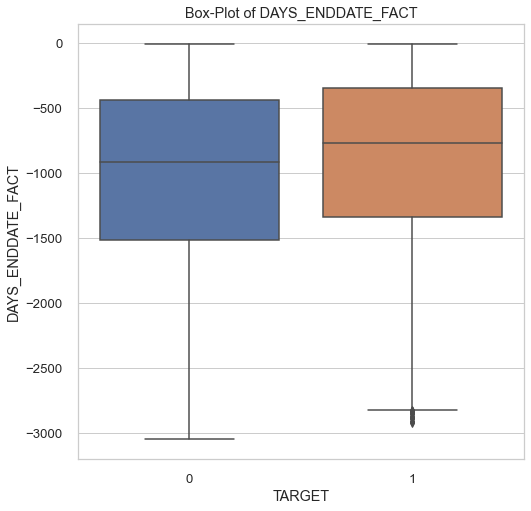

----------------------------------------------------------------------------------------------------


In [65]:
print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT',
                  percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots=[
                          'box'], figsize=(8, 8), scale_limits=[-40000, 0])
print('-'*100)

##### Observations et conclusions :

<ol><li>Comme pour la colonne précédente, nous constatons que le 0ème percentile de cette colonne semble également erroné, qui est de 42023 jours ou ~115 ans. Il faudrait supprimer ces valeurs, car elles n'ont pas beaucoup de sens.</li>
    <li>En regardant le box-plot, on constate que les défaillants ont tendance à avoir moins de jours depuis la fin de leur crédit auprès du bureau de crédit. Les non défaillants ont généralement vu leurs crédits précédents se terminer plus longtemps avant que les défaillants.

#### <span class="bg-danger">DAYS_CREDIT_UPDATE<span>

Cette colonne indique le nombre de jours écoulés depuis que les informations du bureau de crédit sont arrivées au moment de la demande de prêt au Crédit immobilier.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 2th percentile value of DAYS_CREDIT_UPDATE is -2415.0
The 4th percentile value of DAYS_CREDIT_UPDATE is -2213.0
The 6th percentile value of DAYS_CREDIT_UPDATE is -2002.0
The 8th percentile value of DAYS_CREDIT_UPDATE is -1766.0
The 10th percentile value of DAYS_CREDIT_UPDATE is -1582.0
The 25th percentile value of DAYS_CREDIT_UPDATE is -904.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -406.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -33.0
The 100th percentile value of DAYS_CREDIT_UPDATE is 372.0
----------------------------------------------------------------------------------------------------


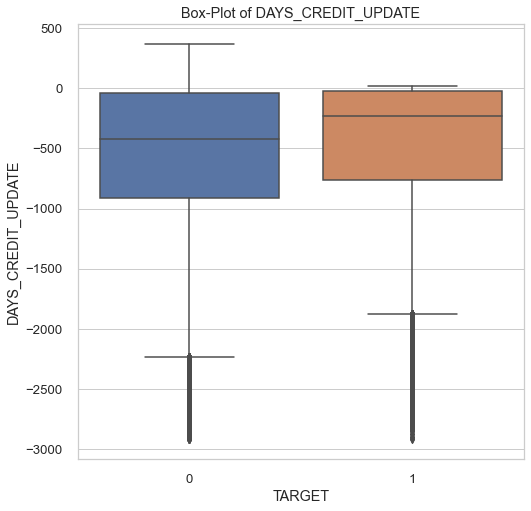

----------------------------------------------------------------------------------------------------


In [66]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE',
                  percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots=[
                          'box'], figsize=(8, 8), scale_limits=[-40000, 400])
print('-'*100)

##### Observations et conclusions :

<ol><li>La tendance des valeurs erronées est à nouveau très similaire à la colonne des autres jours où cette valeur du 0e percentile semble être erronée. De plus, comme seule la valeur du 0e percentile est si étrange, et que le reste semble correct, cette valeur est définitivement erronée. Nous allons également supprimer cette valeur. 
    <li> D'après la représentation graphique, nous pouvons dire que les défaillants ont tendance à avoir un nombre de jours inférieur depuis la réception de leurs informations sur le crédit du bureau de crédit. Leurs valeurs médianes, au 75e centile, sont toutes inférieures à celles des non défaillants.</ol>

## <span class="bg-info"> 3. bureau_balance.csv<span>   

### <span class="bg-warning"> 3.1 Description de la table et de ses colonnes<span>  

Ce tableau se compose du solde mensuel de chaque crédit pour chacun des crédits précédents que le client avait auprès d'institutions financières autres que le Crédit immobilier.

In [67]:
description_colonnes_bureau_balance = description_colonnes.loc[139: 141, :]
description_colonnes_bureau_balance

Table             Row  \
139  bureau_balance.csv    SK_BUREAU_ID   
140  bureau_balance.csv  MONTHS_BALANCE   
141  bureau_balance.csv          STATUS   

                                                                                                                                                                                                                                          Description  \
139                                                                                                                                Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table    
140                                                                                                                                                                Month of balance relative to application date (-1 means the freshest balance date)   
141  Status of Credit Bureau loan during the month (active, closed, DPD0-30,
 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,
 5 means DPD 120+ or sold or written off ] )   

                                   Special  
139                                 hashed  
140  time only relative to the application  
141                                    NaN

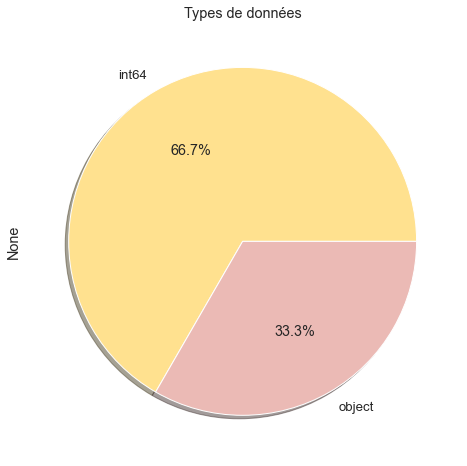

In [68]:
pie_dtypes(bureau_balance)

In [69]:
summarise(bureau_balance)

n_missing  p_missing  n_unique   dtype
SK_ID_BUREAU            0        0.0    817395   int64
MONTHS_BALANCE          0        0.0        97   int64
STATUS                  0        0.0         8  object

### <span class="bg-warning"> 3.2 Basic Stats<span>  

In [70]:
print(f'The shape of bureau_balance.csv is: {bureau_balance.shape}')
print('-'*100)
print(
    f'Number of duplicate values in bureau_balance: {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')
print('-'*100)
display(bureau_balance.head(5))

The shape of bureau_balance.csv is: (27299925, 3)
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau_balance: 0
----------------------------------------------------------------------------------------------------


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [71]:
print("-"*100)
print(
    f'Number of unique SK_ID_BUREAU in bureau_balance.csv are: {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*100)
print(
    f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")
print('-'*100)
print(
    f"Max number of months for Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau_balance.csv are: 817395
----------------------------------------------------------------------------------------------------
Number of unique values for STATUS are: 8
Unique values of STATUS are:
['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------
Max number of months for Months Balance: 96
----------------------------------------------------------------------------------------------------


##### Observations et conclusions

<ol><li>Le tableau bureau_balance.csv contient environ 27,29M lignes, et 3 colonnes.</li>
    <li>Ce tableau contient le statut mensuel de chacun des prêts précédents pour un demandeur particulier déclarés par le département du bureau de crédit.
    <li>Il y a 8 valeurs uniques pour le STATUT qui sont encodées. Chacune d'entre elles a une signification particulière. <br>
        C signifie fermé, X signifie statut inconnu, 0 signifie pas de DPD, 1 signifie maximum fait pendant le mois entre 1-30, 2 signifie DPD 31-60,... 5 signifie DPD 120+ ou vendu ou amorti.
     <li> Le solde du mois le plus ancien que nous avons est le statut de 96 mois en arrière, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels ils existent.

#### <span class="bg-success"> 3.2.1 NaN Columns and Percentage<span>  

In [72]:
plot_nan_percent(nan_df_create(bureau_balance), 'bureau_balance')

The dataframe bureau_balance does not contain any NaN values.


## <span class="bg-info"> 4.  previous_application.csv<span>   

### <span class="bg-warning"> 4.1 Description de la table et de ses colonnes<span>  

Ce tableau contient les données statiques du précédent prêt que le client a eu avec le Crédit immobilier.

In [73]:
description_colonnes_previous_application = description_colonnes.loc[174: 210, :]
description_colonnes_previous_application

Table                          Row  \
174  previous_application.csv                   SK_ID_CURR   
175  previous_application.csv           NAME_CONTRACT_TYPE   
176  previous_application.csv                  AMT_ANNUITY   
177  previous_application.csv              AMT_APPLICATION   
178  previous_application.csv                   AMT_CREDIT   
179  previous_application.csv             AMT_DOWN_PAYMENT   
180  previous_application.csv              AMT_GOODS_PRICE   
181  previous_application.csv   WEEKDAY_APPR_PROCESS_START   
182  previous_application.csv      HOUR_APPR_PROCESS_START   
183  previous_application.csv  FLAG_LAST_APPL_PER_CONTRACT   
184  previous_application.csv       NFLAG_LAST_APPL_IN_DAY   
185  previous_application.csv             NFLAG_MICRO_CASH   
186  previous_application.csv            RATE_DOWN_PAYMENT   
187  previous_application.csv        RATE_INTEREST_PRIMARY   
188  previous_application.csv     RATE_INTEREST_PRIVILEGED   
189  previous_application.csv       NAME_CASH_LOAN_PURPOSE   
190  previous_application.csv         NAME_CONTRACT_STATUS   
191  previous_application.csv                DAYS_DECISION   
192  previous_application.csv            NAME_PAYMENT_TYPE   
193  previous_application.csv           CODE_REJECT_REASON   
194  previous_application.csv              NAME_TYPE_SUITE   
195  previous_application.csv             NAME_CLIENT_TYPE   
196  previous_application.csv          NAME_GOODS_CATEGORY   
197  previous_application.csv               NAME_PORTFOLIO   
198  previous_application.csv            NAME_PRODUCT_TYPE   
199  previous_application.csv                 CHANNEL_TYPE   
200  previous_application.csv             SELLERPLACE_AREA   
201  previous_application.csv         NAME_SELLER_INDUSTRY   
202  previous_application.csv                  CNT_PAYMENT   
203  previous_application.csv             NAME_YIELD_GROUP   
204  previous_application.csv          PRODUCT_COMBINATION   
205  previous_application.csv           DAYS_FIRST_DRAWING   
206  previous_application.csv               DAYS_FIRST_DUE   
207  previous_application.csv    DAYS_LAST_DUE_1ST_VERSION   
208  previous_application.csv                DAYS_LAST_DUE   
209  previous_application.csv             DAYS_TERMINATION   
210  previous_application.csv    NFLAG_INSURED_ON_APPROVAL   

                                                                                                                                                                                                                                                             Description  \
174                                                                                                                                                                                                                                             ID of loan in our sample   
175                                                                                                                                                                              Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application   
176                                                                                                                                                                                                                                      Annuity of previous application   
177                                                                                                                                                                                                       For how much credit did client ask on the previous application   
178  Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT   
179                                                        

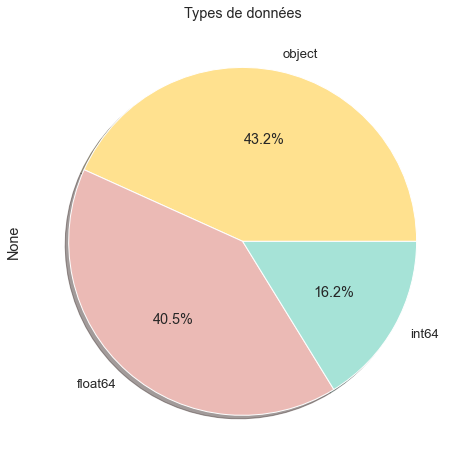

In [74]:
pie_dtypes(previous_application)

In [75]:
summarise(previous_application)

n_missing   p_missing  n_unique    dtype
RATE_INTEREST_PRIVILEGED       1664263  0.99643698        25  float64
RATE_INTEREST_PRIMARY          1664263  0.99643698       148  float64
AMT_DOWN_PAYMENT                895844  0.53636480     29278  float64
RATE_DOWN_PAYMENT               895844  0.53636480    207033  float64
NAME_TYPE_SUITE                 820405  0.49119754         7   object
NFLAG_INSURED_ON_APPROVAL       673065  0.40298129         2  float64
DAYS_TERMINATION                673065  0.40298129      2830  float64
DAYS_LAST_DUE                   673065  0.40298129      2873  float64
DAYS_LAST_DUE_1ST_VERSION       673065  0.40298129      4605  float64
DAYS_FIRST_DUE                  673065  0.40298129      2892  float64
DAYS_FIRST_DRAWING              673065  0.40298129      2838  float64
AMT_GOODS_PRICE                 385515  0.23081773     93885  float64
AMT_ANNUITY                     372235  0.22286665    357959  float64
CNT_PAYMENT                     372230  0.22286366        49  float64
PRODUCT_COMBINATION                346  0.00020716        17   object
AMT_CREDIT                           1  0.00000060     86803  float64
NAME_YIELD_GROUP                     0  0.00000000         5   object
NAME_PORTFOLIO                       0  0.00000000         5   object
NAME_SELLER_INDUSTRY                 0  0.00000000        11   object
SELLERPLACE_AREA                     0  0.00000000      2097    int64
CHANNEL_TYPE                         0  0.00000000         8   object
NAME_PRODUCT_TYPE                    0  0.00000000         3   object
SK_ID_PREV                           0  0.00000000   1670214    int64
NAME_GOODS_CATEGORY                  0  0.00000000        28   object
NAME_CLIENT_TYPE                     0  0.00000000         4   object
CODE_REJECT_REASON                   0  0.00000000         9   object
SK_ID_CURR                           0  0.00000000    338857    int64
DAYS_DECISION                        0  0.00000000      2922    int64
NAME_CONTRACT_STATUS                 0  0.00000000         4   object
NAME_CASH_LOAN_PURPOSE               0  0.00000000        25   object
NFLAG_LAST_APPL_IN_DAY               0  0.00000000         2    int64
FLAG_LAST_APPL_PER_CONTRACT          0  0.00000000         2   object
HOUR_APPR_PROCESS_START              0  0.00000000        24    int64
WEEKDAY_APPR_PROCESS_START           0  0.00000000         7   object
AMT_APPLICATION                      0  0.00000000     93885  float64
NAME_CONTRACT_TYPE                   0  0.00000000         4   object
NAME_PAYMENT_TYPE                    0  0.00000000         4   object

### <span class="bg-warning"> 4.2 Basic Stats<span>  

In [76]:
print(
    f'The shape of previous_application.csv is: {previous_application.shape}')
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in previous_application.csv are: {len(previous_application.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in previous_application.csv are: {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)
print(
    f'Number of duplicate values in previous_application: {previous_application.shape[0] - previous_application.duplicated().shape[0]}')
print('-'*100)
display(previous_application.head(5))

The shape of previous_application.csv is: (1670214, 37)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in previous_application.csv are: 1670214
Number of unique SK_ID_CURR in previous_application.csv are: 338857
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 291057
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 47800
----------------------------------------------------------------------------------------------------
Number of duplicate values in previous_application: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0              0.1828318   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                0.86733615                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

##### Observations et conclusions :

<ol><li>La table previous_application.csv est composé de 1,67M lignes au total. Chaque ligne correspond à chacun des prêts précédents que le client a contractés précédemment auprès de Home Credit Group. Il est possible pour un seul client de la demande actuelle d'avoir plusieurs prêts antérieurs avec Home Credit Group.
    <li>Il y a 37 colonnes dans previous_application.csv, qui contiennent les détails sur le prêt précédent.</li>
    <li>Il y a 338k de SK_ID_CURR uniques dans la demande_précédente, dont 291k correspondent aux SK_ID_CURR du train d'application et 47,8k correspondent aux SK_ID_CURR de l'application_test.</li></ol>

#### <span class="bg-success"> 4.2.1  NaN Columns and Percentages<span>  

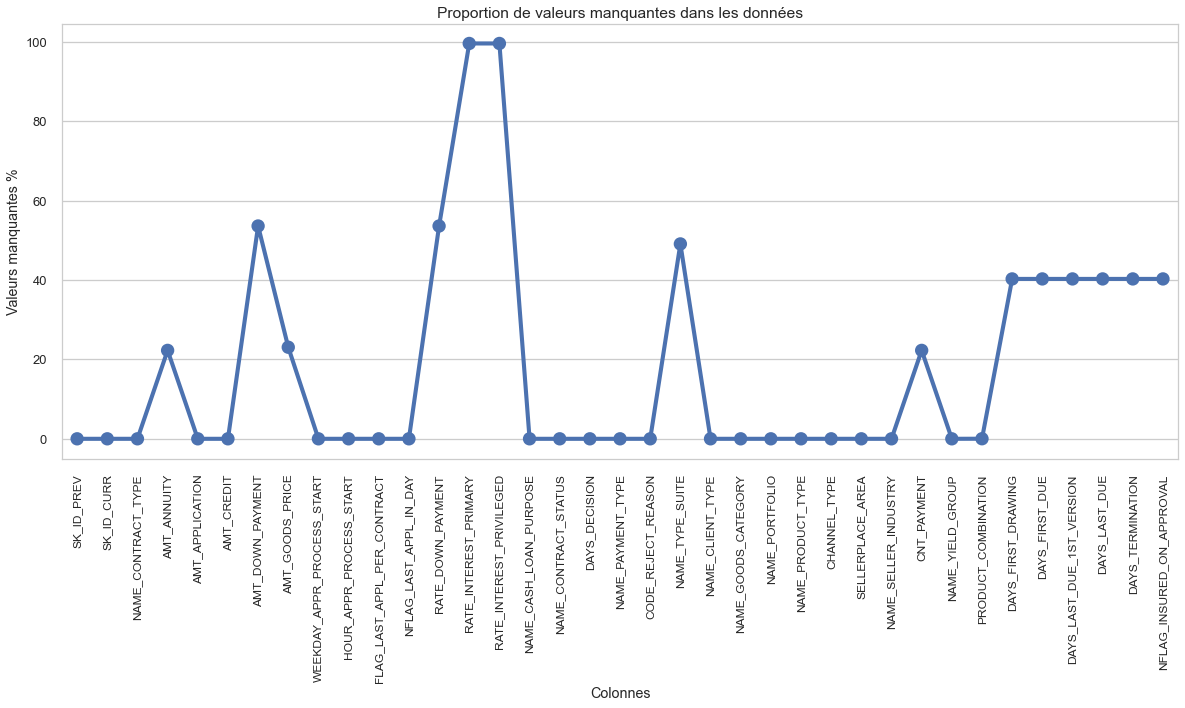

In [77]:
val_manq(previous_application)

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 16 columns


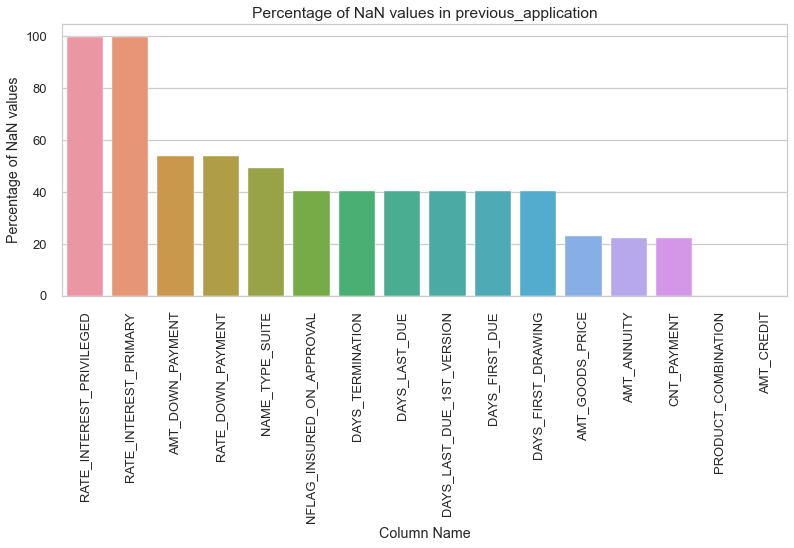

----------------------------------------------------------------------------------------------------


In [78]:
previous_application_nan = nan_df_create(previous_application)
print('-' * 100)
plot_nan_percent(previous_application_nan, 'previous_application',
                 tight_layout=False, figsize=(13, 5))
print('-' * 100)
del previous_application_nan

##### Observations et conclusions

<ol><li>Il y a 16 colonnes sur les 37 colonnes qui contiennent des valeurs de NaN.</li>
    <li>Deux de ces colonnes ont 99,64% de valeurs manquantes, ce qui est très élevé, et nous devrons trouver un moyen intelligent de gérer des valeurs de NaN aussi élevées. Nous ne pouvons pas directement écarter une quelconque caractéristique à ce stade.
    <li>En dehors de ces deux colonnes, le reste des colonnes contient également des valeurs > 40% de NaN, sauf pour 5 colonnes. </li></ol>

#### <span class="bg-success"> 4.2.2  Merging the TARGETS from application_train to previous_application table<span>  

In [79]:
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = application_train.iloc[:, :2].merge(
    previous_application, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


#### <span class="bg-success"> 4.2.3   Phi-K Matrix<span>  

----------------------------------------------------------------------------------------------------


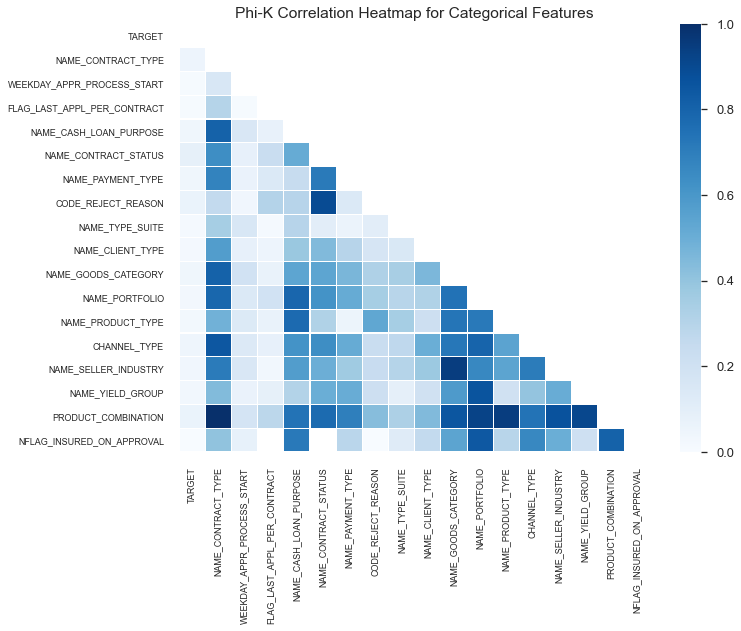

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
4     NAME_CONTRACT_STATUS        0.08826618
15     PRODUCT_COMBINATION        0.06383875
6       CODE_REJECT_REASON        0.06277131
0       NAME_CONTRACT_TYPE        0.05085872
12            CHANNEL_TYPE        0.05030153
9      NAME_GOODS_CATEGORY        0.04295143
3   NAME_CASH_LOAN_PURPOSE        0.04030517
5        NAME_PAYMENT_TYPE        0.03975240
13    NAME_SELLER_INDUSTRY        0.03807671
14        NAME_YIELD_GROUP        0.03462579

----------------------------------------------------------------------------------------------------


In [80]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes ==
                                                'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap='Blues',
                 figsize=(11, 9), fontsize=9)

##### Observations et conclusions :

La carte thermique ci-dessus des valeurs du coefficient Phi-K pour les caractéristiques catégorielles nous permet d'observer que

<ol><li> La caractéristique PRODUCT_COMBINATION montre une association avec de nombreuses autres caractéristiques telles que NOM_TYPE_CONTRACT, NOM_TYPE_PRODUIT, NOM_PORTEFEUILLE, etc.
    <li> La fonction NOM_BONNES_CATEGORIE est également fortement associée à NOM_VENDEUR_INDUSTRIE</li>
    <li>Si nous examinons l'association avec la variable TARGET, nous constatons que les caractéristiques NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON font partie des caractéristiques associées les plus élevées, et nécessiteraient un examen plus approfondi</li></ol>
   

#### <span class="bg-success"> 4.2.4   Correlation Matrix of Features<span>  

----------------------------------------------------------------------------------------------------


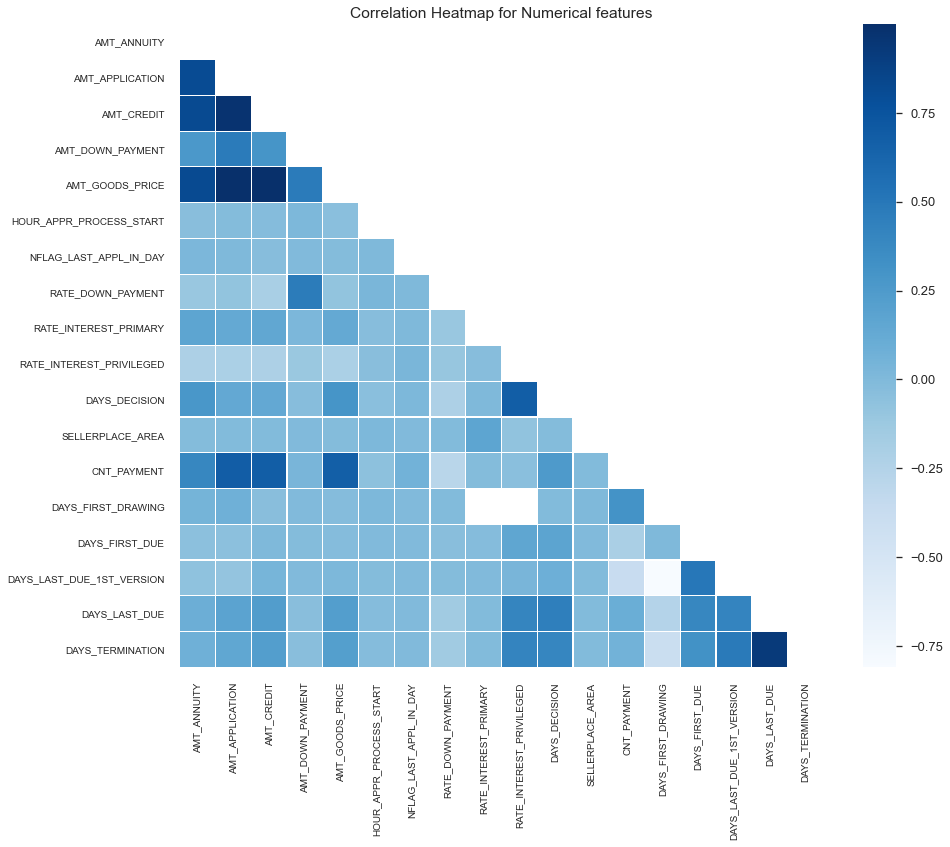

----------------------------------------------------------------------------------------------------


In [81]:
corr_mat = correlation_matrix(prev_merged, [
                              'SK_ID_CURR', 'SK_ID_PREV', 'NFLAG_INSURED_ON_APPROVAL'], cmap='Blues', figsize=(14, 12))
corr_mat.plot_correlation_matrix()

In [82]:
# Seeing the top columns with highest phik-correlation with the target variable in previous_applications table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

Column Name  Phik-Correlation
12                CNT_PAYMENT        0.05663855
10              DAYS_DECISION        0.05369416
13         DAYS_FIRST_DRAWING        0.04899292
7           RATE_DOWN_PAYMENT        0.03959171
5     HOUR_APPR_PROCESS_START        0.03812149
9    RATE_INTEREST_PRIVILEGED        0.02820421
15  DAYS_LAST_DUE_1ST_VERSION        0.02787840
16              DAYS_LAST_DUE        0.02732029
17           DAYS_TERMINATION        0.02647936
0                 AMT_ANNUITY        0.01380755

----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

<ol>
    <li>La carte thermique ci-dessus montre la corrélation entre chaque caractéristique du tableau previous_application et le reste des caractéristiques.</li>
    <li>De la carte de chaleur, on peut voir quelques caractéristiques fortement corrélées qui ont une couleur plus foncée.</li>
    <li>La corrélation élevée est particulièrement observée pour les caractéristiques :
        <ol><li>DATE_TERMINATION et JOURS_DERNIERS_DATE</li>
            <li>AMT_CREDIT et AMT_APPLICATION</li>
            <li>AMT_APPLICATION et AMT_GOODS_PRICE</li>
            <li>AMT_CREDIT et AMT_ANNUITY</li>
            <li>AMT_ANNUITY et AMT_CREDIT</li>
            <li>AMT_CREDIT et AMT_GOODS_PRICE</li></ol></li>
    <li>Nous pouvons également constater que les caractéristiques ne présentent pas particulièrement de corrélation bonne/élevée avec Target en tant que tel. Cela implique qu'il n'y a pas vraiment de relation linéaire directe entre Target et les caractéristiques.

### <span class="bg-warning"> 4.3 Plotting Categorical Variables<span>   

Let us now plot some of the Categorical Variables of table previous_application and see how they impact the Target Variable.

#### <span class="bg-success"> 4.3.1 Distribution of Categorical Variable NAME_CONTRACT_TYPE<span> 

Cette colonne décrit le type de contrat du prêt précédent avec le Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


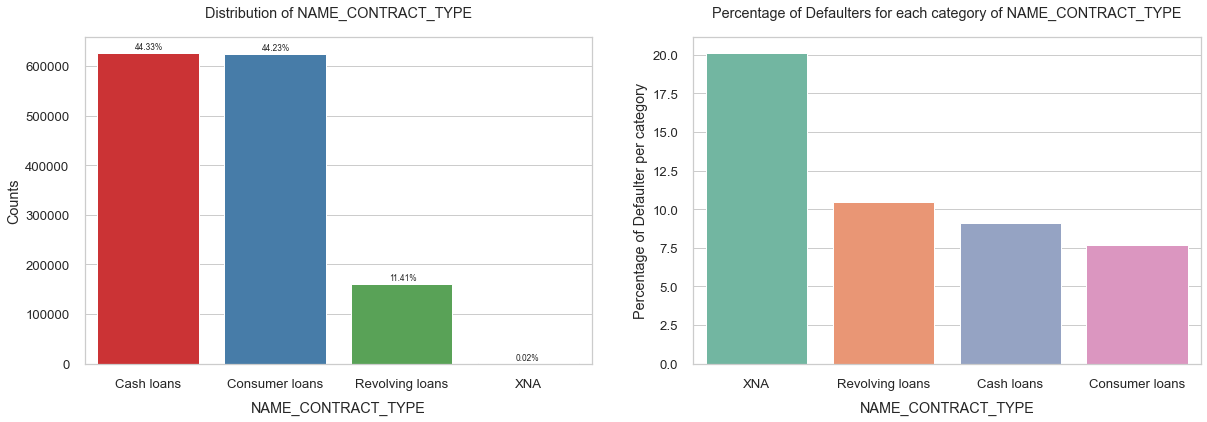

----------------------------------------------------------------------------------------------------


In [83]:
# let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust=0.3, figsize=(20, 6))
print('-'*100)

##### Observations et conclusions :

A partir des tracés ci-dessus, nous pouvons observer ce qui suit :
<ol><li> A partir du premier subplot, nous constatons que la plupart des prêts précédents ont été soit des prêts cash, soit des prêts à la consommation, ce qui correspond à environ 44 % des prêts chacun. Les 11,41 % restants correspondent à des prêts revolving, et il y a quelques prêts nommés XNA dont les types ne sont en fait pas connus, mais ils sont très peu nombreux.</li>
    <li>En examinant le deuxième subplot, on constate que le pourcentage de défaillants pour les prêts de type XNA est le plus élevé, avec un taux de défaillance de 20 %. Le taux de défaillance suivant le plus élevé est celui des prêts revolvings, qui est proche de 10,5 %. </li>
Les prêts cash ont des taux de défaillance plus faibles, environ 9 %, tandis que les prêts à la consommation ont tendance à avoir le plus faible pourcentage de défaillances, qui est proche de 7,5 %.</li></ol>

#### <span class="bg-success"> 4.3.2 Distribution de la variable catégorielle NAME_CONTRACT_STATUS<span> 

Cette colonne décrit l'état du contrat du prêt précédent avec le Crédit immobilier, c'est-à-dire s'il est actif ou fermé, etc.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


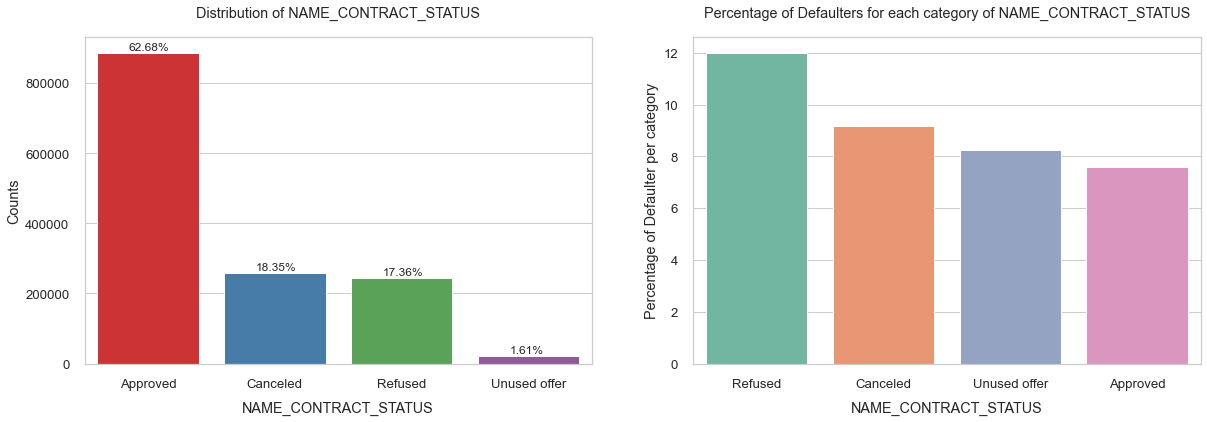

----------------------------------------------------------------------------------------------------


In [84]:
# let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS',
                               horizontal_adjust=0.25, figsize=(20, 6), fontsize_percent='small')
print('-'*100)

##### Observations et conclusions :

C'est ce que l'on constate à partir des tracés ci-dessus :
<ol><li>Le type de statut de contrat le plus courant est le statut approuvé. Environ 63 % des crédits précédents ont un statut approuvé. Les deux statuts suivants sont Annulé et Refusé, qui correspondent tous deux à environ 18% des prêts. Cela signifie que la plupart des prêts sont approuvés et que seule une partie d'entre eux ne le sont pas. Le type de statut de contrat le moins fréquent est Offre non utilisée, qui correspond à seulement 1,61 % de l'ensemble des prêts.
    <li>En examinant le deuxième sublot pour le pourcentage de mauvais payeurs, nous constatons que les prêts qui avaient auparavant le statut de refus ont tendance à être les plus mauvais payeurs des prêts actuels. Ils correspondent à environ 12 % des défaillants de cette catégorie. Ils sont suivis par les prêts dont le statut a été annulé, qui correspondent à près de 9 % du taux de défaillance. Ce comportement est tout à fait logique, car ces personnes ont dû être refusées parce qu'elles n'avaient pas le profil adéquat. Le taux de défaillance le plus faible est observé pour le statut de contrat Approuvé.</li></ol>

#### <span class="bg-success"> 4.3.3 Distribution de la variable catégorielle CODE_REJECT_REASON<span> 

Cette colonne décrit la raison du rejet d'un prêt précédemment demandé dans le groupe de crédit immobilier.

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_REJECT_REASON' are:
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
----------------------------------------------------------------------------------------------------
Counts of each category are:
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CODE_REJECT_REASON = 10


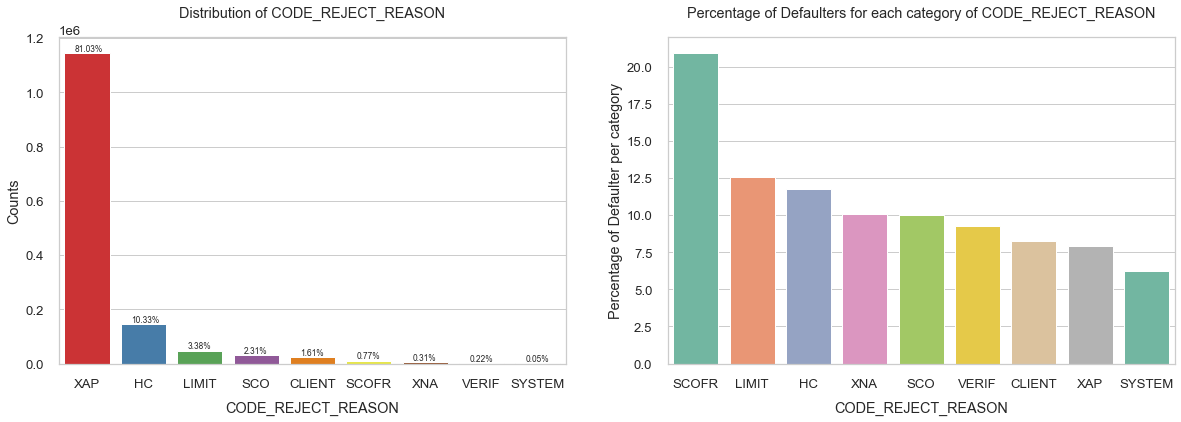

----------------------------------------------------------------------------------------------------


In [85]:
# let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    prev_merged, 'CODE_REJECT_REASON', horizontal_adjust=0.18, figsize=(20, 6))
print('-'*100)

##### Observations et conclusions :

Le graphique ci-dessus montre la distribution de la variable catégorielle CODE_REJECT_REASON. Les observations suivantes peuvent être générées à partir du graphique ci-dessus :
<ol><li> Le type de motif de rejet le plus courant est le XAP, qui est d'environ ~81%. Les autres raisons ne représentent qu'une petite partie des motifs de rejet. HC est le deuxième motif de rejet le plus fréquent avec seulement 10,33% des occurrences.</li>
    <li>La distribution du pourcentage de défaillants pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les demandeurs dont les demandes précédentes ont été rejetées par le Code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~21%). Ils sont suivis par LIMIT et HC qui ont environ 12,5 % et 12 % de défaillants.</li>
    <li>Le motif de rejet le plus courant XAP ne correspond qu'à 7,5% des défaillants, et est le deuxième pourcentage le plus faible de défaillants après le code SYSTEME.</li></ol>

#### <span class="bg-success"> 4.3.4 Distribution de la variable catégorielle CHANNEL_TYPE<span>

Cette colonne décrit le canal par lequel le client a été acquis pour le prêt précédent dans le cadre du crédit immobilier.

----------------------------------------------------------------------------------------------------
The unique categories of 'CHANNEL_TYPE' are:
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of CHANNEL_TYPE = 9


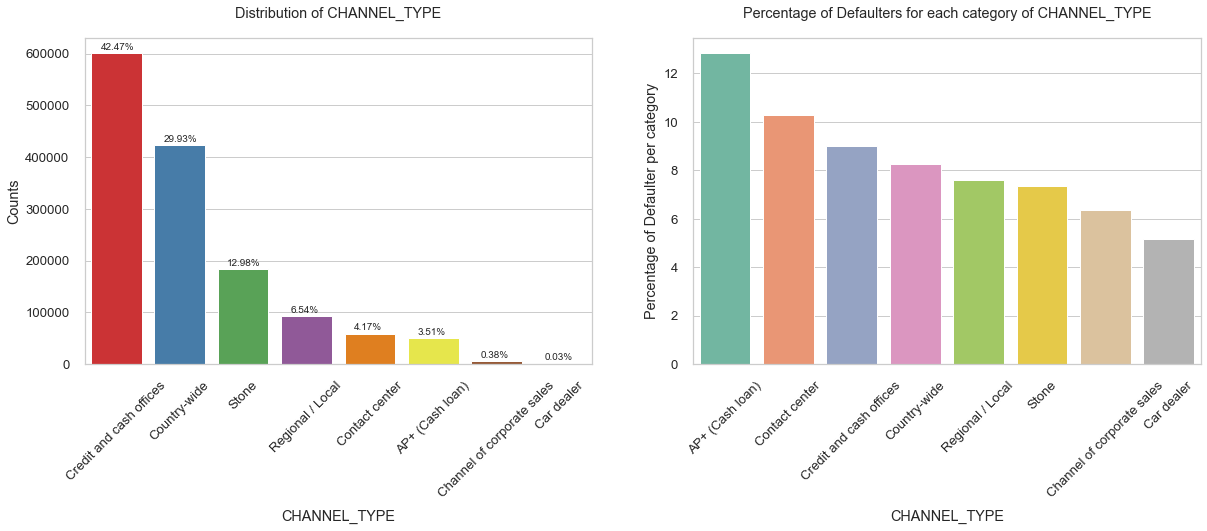

----------------------------------------------------------------------------------------------------


In [86]:
# let us first see the unique categories of 'CHANNEL_TYPE'
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust=0.15,
                               rotation=45, figsize=(20, 6), fontsize_percent='x-small')
print('-'*100)

##### Observations et conclusions

Les deux graphiques ci-dessus montrent la distribution de CHANNEL_TYPE pour les prêts précédents dans le domaine du crédit immobilier.
<ol><li> A partir du premer subplot, nous voyons que la plupart des demandes ont été acquises par le biais des bureaux de crédit et de la caisse, soit environ 42,47% de demandes, qui ont été suivies par le canal national correspondant à 29,93% de demandes. Les autres types de canaux ne correspondent qu'à un nombre limité de demandes.
    <li>Le pourcentage de défaillances le plus élevé a été observé parmi les demandes qui avaient un type de canal AP+ (prêt en espèces) qui correspondait à environ 13% de défaillances dans cette catégorie. Les autres chaînes avaient des pourcentages de défaut plus faibles que celle-ci. La chaîne Car Dealer a enregistré le plus faible pourcentage de mauvais payeurs dans cette catégorie (seulement 5 %).

#### <span class="bg-success"> 4.3.5 Distribution de la variable catégorielle PRODUCT_COMBINATION<span>

Cette colonne donne des détails sur la combinaison de produits des demandes précédentes.

----------------------------------------------------------------------------------------------------
The unique categories of 'PRODUCT_COMBINATION' are:
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of PRODUCT_COMBINATION = 18


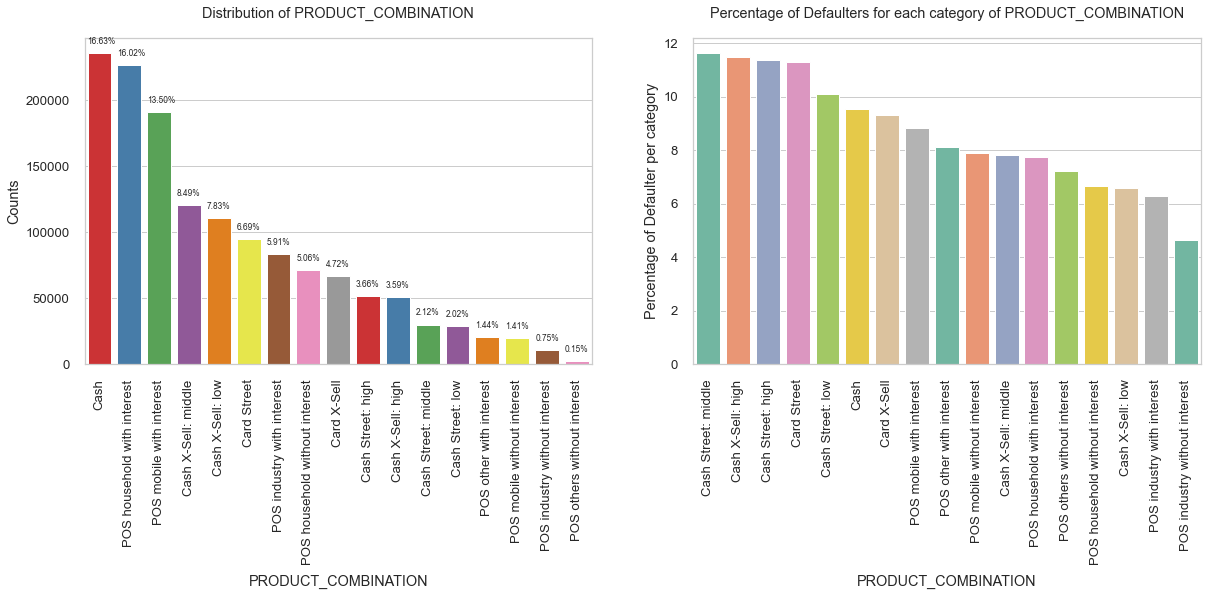

----------------------------------------------------------------------------------------------------


In [87]:
# let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    prev_merged, 'PRODUCT_COMBINATION', rotation=90, figsize=(20, 6))
print('-'*100)

##### Observations et conclusions

La distribution de PRODUCT_COMBINATION nous permet de dégager les enseignements suivants :
<ol><li>Les 3 types de combinaison de produits les plus courants sont l'argent liquide, les points de vente domestiques avec intérêts et les points de vente mobiles avec intérêts. Ils correspondent à environ 50 % de toutes les applications. </li>
    <li>En examinant le graphique du pourcentage de mauvais payeurs par catégorie, on constate une tendance à la hausse des mauvais payeurs parmi les catégories Cash Street : mobile, Cash X-sell : high, Cash Street : high et Card Street qui sont toutes proches de 11-11,5% de mauvais payeurs par catégorie. Le pourcentage le plus faible de défaillants se trouve dans la catégorie "secteur des points de vente sans intérêt", qui correspond à environ 4,5 % de défaillants.

### <span class="bg-warning"> 4.4 Plotting Continuous Variables<span>    

#### <span class="bg-success"> 4.4.1 Distribution de Continuous Variable with DAYS Features<span>

#### <span class="bg-danger"> DAYS_DECISION<span>

Cette colonne indique le nombre de jours relatifs à la demande en cours lorsque la décision a été prise sur la demande précédente.

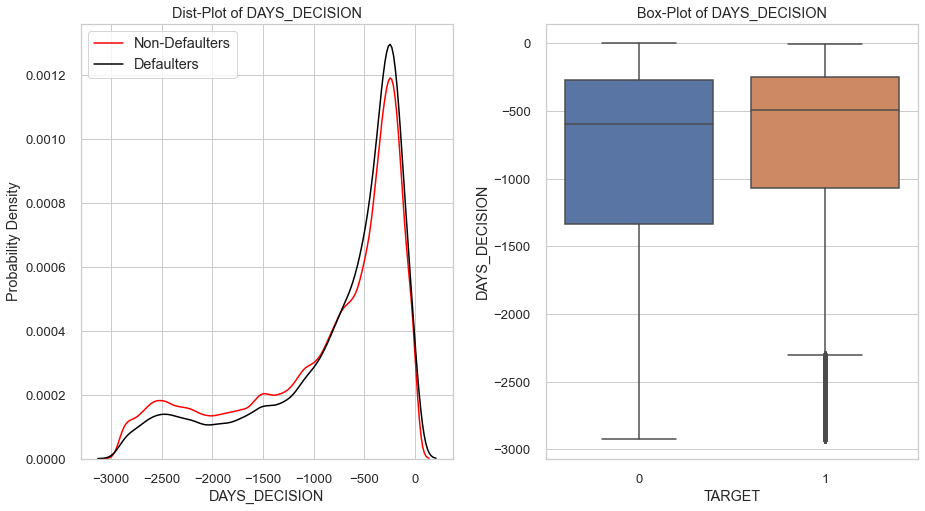

In [88]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots=[
                          'distplot', 'box'], figsize=(15, 8))

##### Observations et conclusions

D'après le graphique ci-dessus, nous constatons que pour les défaillants, le nombre de jours à partir desquels la décision a été prise est un peu moins élevé que pour les non défaillants. Cela signifie que les défaillants ont généralement reçu la décision relative à leurs demandes antérieures plus récemment que les non défaillants.

#### <span class="bg-danger"> DAYS_FIRST_DRAWING<span>

Cette colonne indique le nombre de jours écoulés depuis la demande actuelle jusqu'à ce que le premier versement de la demande précédente ait été effectué.

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DRAWING is -2922.0
The 1th percentile value of DAYS_FIRST_DRAWING is -2451.0
The 2th percentile value of DAYS_FIRST_DRAWING is -1179.0
The 3th percentile value of DAYS_FIRST_DRAWING is -674.0
The 4th percentile value of DAYS_FIRST_DRAWING is -406.0
The 5th percentile value of DAYS_FIRST_DRAWING is -262.0
The 6th percentile value of DAYS_FIRST_DRAWING is -156.0
The 7th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 8th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 9th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 10th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 20th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 40th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 60th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 80th percentile value of DAYS_FIRST_DRAWING is 365243.0
The 100th percentile

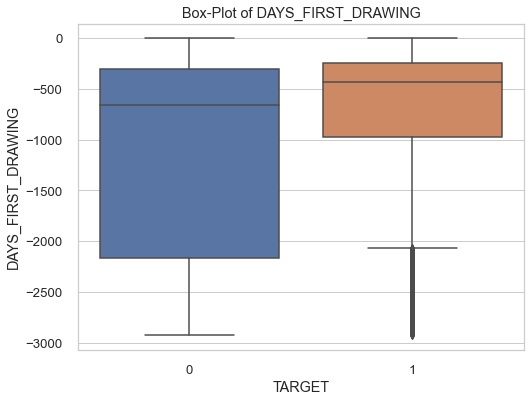

----------------------------------------------------------------------------------------------------


In [89]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING',
                  percentiles=list(range(0, 11)) + list(range(20, 101, 20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots=[
                          'box'], figsize=(8, 6), scale_limits=[-3000, 0])
print('-'*100)

##### Observations et conclusions :

<ol><li>En regardant les valeurs de percentile de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées, à partir du 7e percentile lui-même. Ces valeurs erronées devront être supprimées.
    <li>Si nous essayons d'analyser la distribution de cette colonne en supprimant les ponts erronés, nous constatons que la plupart des défaillants ont eu leur premier tirage sur un crédit antérieur plus récemment que les non défaillants. La valeur du 75e percentile pour les défaillants est également nettement inférieure à celle des non défaillants.

#### <span class="bg-danger"> DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION<span>

Ces colonnes décrivent également le nombre de jours écoulés depuis l'application actuelle pendant lesquels certaines activités ont eu lieu. 

In [90]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles=list(
    range(0, 11, 2)) + [20, 40, 60, 80, 100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION',
                  percentiles=list(range(0, 11, 2)) + [20, 40, 60, 80, 100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles=list(
    range(0, 11, 2)) + [20, 40, 60, 80, 100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles=list(
    range(0, 11, 2)) + [20, 40, 60, 80, 100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_FIRST_DUE is -2892.0
The 2th percentile value of DAYS_FIRST_DUE is -2759.0
The 4th percentile value of DAYS_FIRST_DUE is -2648.0
The 6th percentile value of DAYS_FIRST_DUE is -2555.0
The 8th percentile value of DAYS_FIRST_DUE is -2471.0
The 10th percentile value of DAYS_FIRST_DUE is -2388.0
The 20th percentile value of DAYS_FIRST_DUE is -1882.0
The 40th percentile value of DAYS_FIRST_DUE is -1070.0
The 60th percentile value of DAYS_FIRST_DUE is -647.0
The 80th percentile value of DAYS_FIRST_DUE is -329.0
The 100th percentile value of DAYS_FIRST_DUE is 365243.0
----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
------------

##### Observations et conclusions

A partir de toutes les valeurs de percentile ci-dessus, nous nous rendons compte que toutes les colonnes de Days ont ces valeurs erronées quelque part. Ces valeurs doivent donc être remplacées afin que notre modèle ne soit pas affecté par celles-ci.

## <span class="bg-info"> 5.  installments_payments.csv<span>   

### <span class="bg-warning"> 5.1 Description de la table et de ses colonnes<span> 

Ce tableau présente l'historique de remboursement de chacun des prêts que le demandeur a contractés auprès de Home Credit Group. Le tableau contient des caractéristiques telles que le montant du versement, le montant que le client a payé pour chaque versement, etc.

In [91]:
description_colonnes_installments_payments = description_colonnes.loc[211:, :]
description_colonnes_installments_payments

Table                     Row  \
211  installments_payments.csv             SK_ID_PREV    
212  installments_payments.csv              SK_ID_CURR   
213  installments_payments.csv  NUM_INSTALMENT_VERSION   
214  installments_payments.csv   NUM_INSTALMENT_NUMBER   
215  installments_payments.csv         DAYS_INSTALMENT   
216  installments_payments.csv      DAYS_ENTRY_PAYMENT   
217  installments_payments.csv          AMT_INSTALMENT   
218  installments_payments.csv             AMT_PAYMENT   

                                                                                                                                                                                    Description  \
211                                           ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)   
212                                                                                                                                                                    ID of loan in our sample   
213  Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed   
214                                                                                                                                                     On which installment we observe payment   
215                                                                              When the installment of previous credit was supposed to be paid (relative to application date of current loan)   
216                                                                                   When was the installments of previous credit paid actually (relative to application date of current loan)   
217                                                                                                           What was the prescribed installment amount of previous credit on this installment   
218                                                                                                                        What the client actually paid on previous credit on this installment   

                                   Special  
211                                 hashed  
212                                 hashed  
213                                    NaN  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN

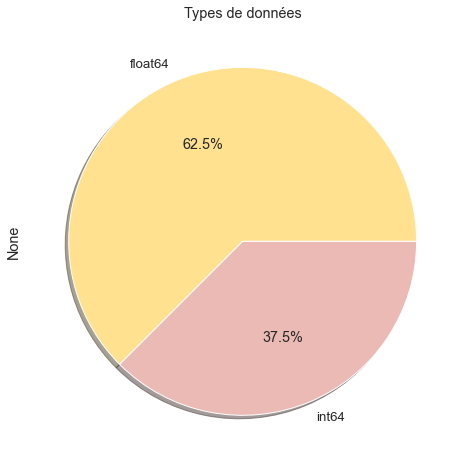

In [92]:
pie_dtypes(installments_payments)

In [93]:
summarise(installments_payments)

n_missing   p_missing  n_unique    dtype
DAYS_ENTRY_PAYMENT           2905  0.00021352      3039  float64
AMT_PAYMENT                  2905  0.00021352    944235  float64
SK_ID_PREV                      0  0.00000000    997752    int64
SK_ID_CURR                      0  0.00000000    339587    int64
NUM_INSTALMENT_VERSION          0  0.00000000        65  float64
NUM_INSTALMENT_NUMBER           0  0.00000000       277    int64
DAYS_INSTALMENT                 0  0.00000000      2922  float64
AMT_INSTALMENT                  0  0.00000000    902539  float64

### <span class="bg-warning"> 5.2  Basic Stats<span>

In [94]:
print(
    f'The shape of installments_payments.csv is: {installments_payments.shape}')
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(installments_payments.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print('-'*100)
print(
    f'Number of duplicate values in installments_payments: {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')
print('-'*100)
display(installments_payments.head(5))

The shape of installments_payments.csv is: (13605401, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 997752
Number of unique SK_ID_CURR in installments_payments.csv are: 339587
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 291643
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 47944
----------------------------------------------------------------------------------------------------
Number of duplicate values in installments_payments: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

##### Observations et conclusions

<ol><li>Il y a environ 13,6 millions de points de données dans le tableau installments_payments.csv. Chaque ligne représente l'historique de chaque versement lié à un prêt particulier que le client avait précédemment contracté auprès de Home Credit Group.
    <li>Il y a 997k de prêts antérieurs uniques dans les versements. Ils appartiennent à 339 000 SK_ID_CURR uniques, qui sont les identifiants des demandeurs du prêt actuel.
    <li>De ces 339k SK_ID_CURR, 291k appartiennent à l'ensemble de données de formation, et 47,9k à l'ensemble de données de test. Cela signifie que presque sur les 307k SK_ID_CURR uniques dans application_train, 291k avaient auparavant une forme de prêt avec Home Credit. De même, sur les 48,7 k de l'ensemble de données de test, 47,9 k avaient déjà bénéficié d'un prêt avec le Crédit immobilier.
    <li>Le tableau comporte 8 caractéristiques uniques, dont 6 décrivent les statistiques de chaque versement pour le prêt précédent. </li></ol>

#### <span class="bg-success"> 5.2.1 NaN Columns and Percentages<span> 

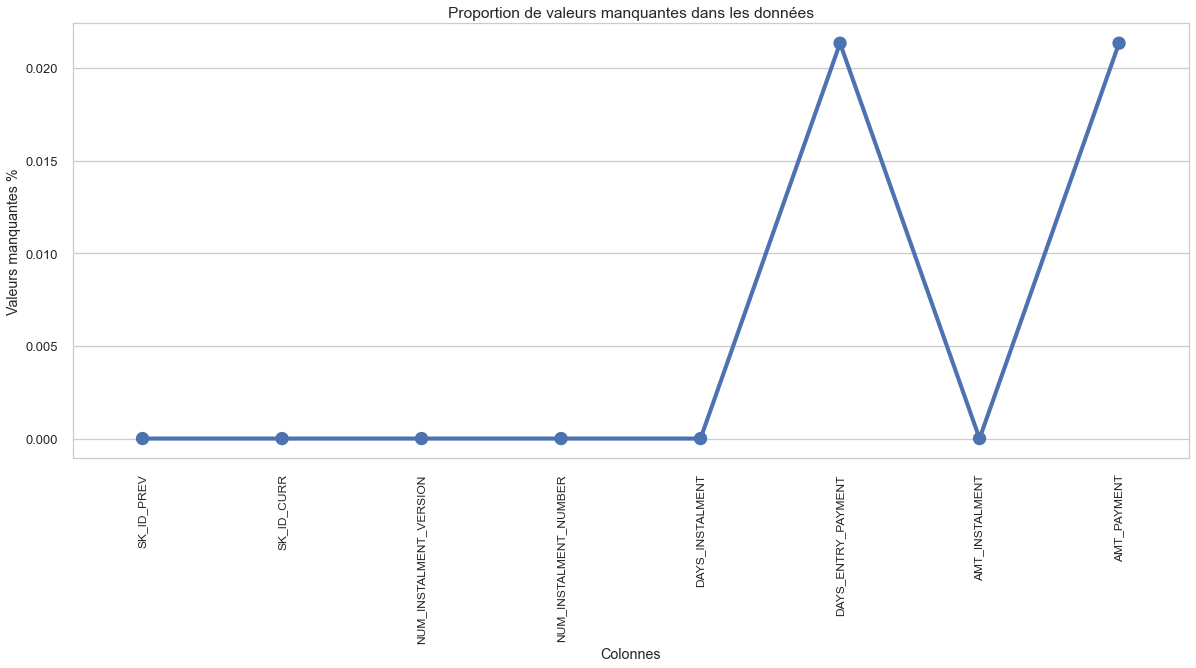

In [95]:
val_manq(installments_payments)

In [96]:
print('-' * 100)
print("Columns with NaN values and their percentages:")
installments_payments_nan = nan_df_create(installments_payments)
display(installments_payments_nan[installments_payments_nan.percent != 0])
print('-' * 100)
del installments_payments_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


column     percent
5  DAYS_ENTRY_PAYMENT  0.02135181
7         AMT_PAYMENT  0.02135181

----------------------------------------------------------------------------------------------------


##### Observations et conclusions

<ol><li>Il n'y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de installments_payments.</li>
    <li>Ces colonnes contiennent également une proportion très minime de valeurs de NaN, à savoir seulement 0,02%, ce qui n'est pas très préoccupant.</li></ol>

#### <span class="bg-success"> 5.2.2 Merging the TARGETS from application_train to installments_payments table<span> 

In [97]:
print("-"*100)
print("Merging TARGET with installments_payments Table")
installments_merged = application_train.iloc[:, :2].merge(
    installments_payments, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with installments_payments Table
----------------------------------------------------------------------------------------------------


#### <span class="bg-success"> 5.2.3 Correlation Matrix of Features<span> 

----------------------------------------------------------------------------------------------------


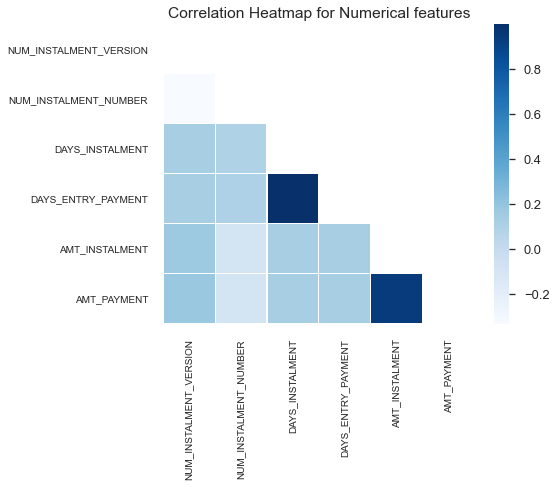

----------------------------------------------------------------------------------------------------


In [98]:
corr_mat = correlation_matrix(
    installments_merged, ['SK_ID_CURR', 'SK_ID_PREV'], figsize=(8, 7))
corr_mat.plot_correlation_matrix()

In [99]:
# Seeing the top columns with highest phik-correlation with the target variable in installments_payments table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_VERSION']
interval columns not set, guessing: ['TARGET', 'NUM_INSTALMENT_NUMBER']
interval columns not set, guessing: ['TARGET', 'DAYS_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_ENTRY_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
2         DAYS_INSTALMENT        0.04682406
3      DAYS_ENTRY_PAYMENT        0.03312802
1   NUM_INSTALMENT_NUMBER        0.02299338
4          AMT_INSTALMENT        0.00412525
5             AMT_PAYMENT        0.00308415
0  NUM_INSTALMENT_VERSION        0.00219769

----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

<ol>
    <La carte thermique ci-dessus montre la corrélation entre chaque caractéristique du tableau des paiements échelonnés et le reste des caractéristiques.
    <li>De la carte thermique de la matrice de corrélation, nous voyons quelques caractéristiques fortement corrélées. Ce sont :
        <ul><li>AMT_INSTALMENT and AMT_PAYMENT</li>
            <li>DAYS_INSTALMENT and DAYS_ENTRY_PAYMENT</li>
        </ul></li>
    <li> Ces deux ensembles de caractéristiques corrélées sont compréhensibles, car il s'agit en fait des caractéristiques relatives à la date à laquelle le versement devait être effectué par rapport à la date à laquelle il a été effectué, ainsi que du montant dû par rapport au montant payé.</li>
    <li>Ces caractéristiques seront utiles pour créer de nouveaux ensembles de caractéristiques totalement non corrélées.</li>
    <li>La corrélation des caractéristiques avec la variable Target n'est pas perceptible, ce qui montre l'absence de relation linéaire entre la caractéristique et la variable Target.</li></ol>

### <span class="bg-warning"> 5.3 Plotting Continuous Variables<span>

Tout d'abord, nous allons regrouper par le champ "SK_ID_PREV" et agréger avec la moyenne, de façon à obtenir une ligne moyenne pour chacun des prêts précédents que le client a obtenus.

In [100]:
installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

#### <span class="bg-success"> 5.3.1 Distribution of Continuous Vairable DAYS_INSTALMENT<span> 
Cette colonne indique les jours où le versement du crédit précédent devait être payé.

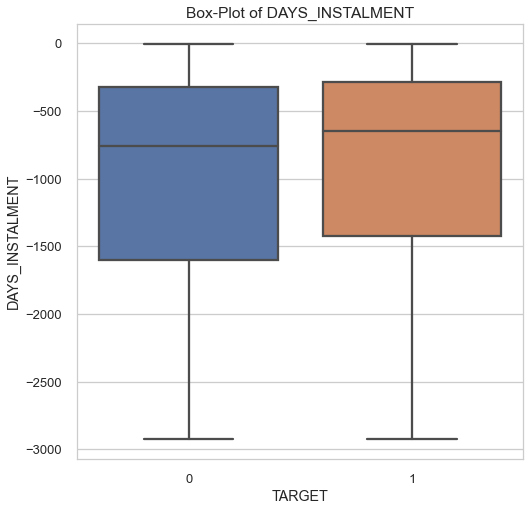

In [101]:
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots=[
                          'box'], figsize=(8, 8))

#### <span class="bg-success"> 5.3.2 Distribution of Continuous Vairable DAYS_ENTRY_PAYMENT<span>

Cette colonne indique les jours où le versement du crédit précédent a été effectivement payé.

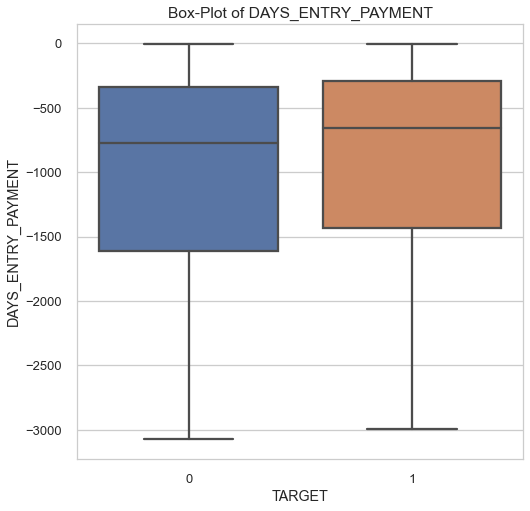

In [102]:
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots=[
                          'box'], figsize=(8, 8))
del installments_merged

##### Observations et conclusions

Les deux graphiques ci-dessus montrent une tendance similaire, à savoir que les défaillants ont tendance à avoir moins de jours depuis leur dernier paiement, tandis que les non défaillants ont plus de jours depuis leur dernier paiement. Tous les quantiles des défaillants ont plus de jours récents que ceux des non défaillants. Ainsi, les non défaillants ont généralement plus d'écart dans leurs paiements depuis le jour de la demande que les défaillants.

## <span class="bg-info"> 6.   POS_CASH_balance.csv<span>   

### <span class="bg-warning"> 6.1 Description de la table et de ses colonnes<span> 

Cette table contient les instantanés des soldes mensuels des précédents points de vente et des prêts en espèces que le demandeur avait contractés auprès du Home Credit Group. Le tableau contient des colonnes telles que l'état du contrat, le nombre de versements restants, etc.

In [103]:
description_colonnes_POS_CASH_balance = description_colonnes.loc[142: 149, :]
description_colonnes_POS_CASH_balance

Table                    Row  \
142  POS_CASH_balance.csv            SK_ID_PREV    
143  POS_CASH_balance.csv             SK_ID_CURR   
144  POS_CASH_balance.csv         MONTHS_BALANCE   
145  POS_CASH_balance.csv         CNT_INSTALMENT   
146  POS_CASH_balance.csv  CNT_INSTALMENT_FUTURE   
147  POS_CASH_balance.csv   NAME_CONTRACT_STATUS   
148  POS_CASH_balance.csv                 SK_DPD   
149  POS_CASH_balance.csv             SK_DPD_DEF   

                                                                                                                                                                                                                                                        Description  \
142                                                                                                               ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)   
143                                                                                                                                                                                                                                        ID of loan in our sample   
144  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )   
145                                                                                                                                                                                                                  Term of previous credit (can change over time)   
146                                                                                                                                                                                                                 Installments left to pay on the previous credit   
147                                                                                                                                                                                                                                Contract status during the month   
148                                                                                                                                                                                                         DPD (days past due) during the month of previous credit   
149                                                                                                                                                            DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit   

                                   Special  
142                                    NaN  
143                                    NaN  
144  time only relative to the application  
145                                    NaN  
146                                    NaN  
147                                    NaN  
148                                    NaN  
149                                    NaN

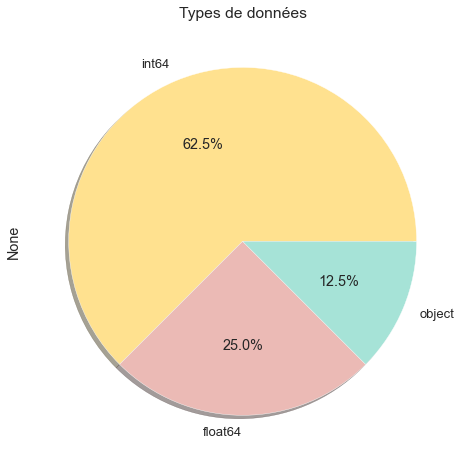

In [104]:
pie_dtypes(POS_CASH_balance)

In [105]:
summarise(POS_CASH_balance)

n_missing   p_missing  n_unique    dtype
CNT_INSTALMENT_FUTURE      26087  0.00260835        79  float64
CNT_INSTALMENT             26071  0.00260675        73  float64
SK_ID_PREV                     0  0.00000000    936325    int64
SK_ID_CURR                     0  0.00000000    337252    int64
MONTHS_BALANCE                 0  0.00000000        96    int64
NAME_CONTRACT_STATUS           0  0.00000000         9   object
SK_DPD                         0  0.00000000      3400    int64
SK_DPD_DEF                     0  0.00000000      2307    int64

### <span class="bg-warning"> 6.2  Basic Stats<span> 

In [106]:
print(f'The shape of POS_CASH_balance.csv is: {POS_CASH_balance.shape}')
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print('-'*100)
print(
    f'Number of duplicate values in POS_CASH_balance: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')
print('-'*100)
display(POS_CASH_balance.head())

The shape of POS_CASH_balance.csv is: (10001358, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 289444
Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: 47808
----------------------------------------------------------------------------------------------------
Number of duplicate values in POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

##### Observations et conclusions

<ol><li>Ce tableau contient environ 10M points de données, où chaque ligne correspond à l'instantané mensuel de l'état du précédent point de vente et du prêt en espèces que le client a eu avec Home Credit Group. Il se compose de 8 colonnes, dont deux sont SK_ID_CURR et SK_ID_PREV.</li>
    <li>Il y a 936k d'identifiants uniques de prêts précédents dans le tableau, qui correspondent à 337k de demandeurs actuels uniques (SK_ID_CURR).</li>
    <li>De ces 337k SK_ID_CURR, 289k appartiennent à l'ensemble de formation et 47,8k à l'ensemble de test.</li></ol>

#### <span class="bg-success"> 6.2.1 NaN Columns and Percentages<span> 

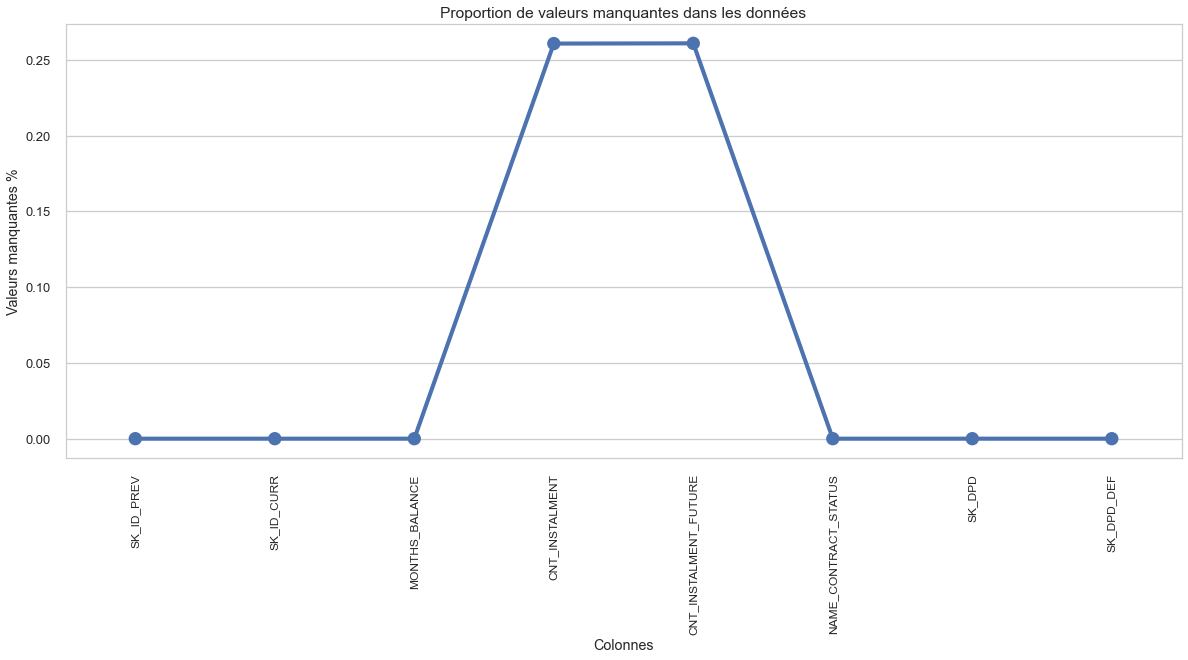

In [107]:
val_manq(POS_CASH_balance)

In [108]:
print('-'*100)
print("Columns with NaN values and their percentages:")
POS_CASH_nan = nan_df_create(POS_CASH_balance)
display(POS_CASH_nan[POS_CASH_nan.percent != 0])
print('-'*100)
del POS_CASH_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


column     percent
4  CNT_INSTALMENT_FUTURE  0.26083458
3         CNT_INSTALMENT  0.26067460

----------------------------------------------------------------------------------------------------


##### Observations et conclusions

<ol><li>Il n'y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de POS_CASH_balance. Ces colonnes sont le décompte des versements restants et la durée du prêt.</li>
    <li>Ces colonnes contiennent également une proportion très minime de valeurs de NaN, à savoir seulement 0,26%%, ce qui n'est pas non plus très préoccupant.</li></ol>

#### <span class="bg-success"> 6.2.2 Merging the TARGETS from application_train to POS_CASH_balance tables<span> 

In [109]:
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:, :2].merge(
    POS_CASH_balance, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


#### <span class="bg-success"> 6.2.3 Correlation Matrix of Features<span>  

----------------------------------------------------------------------------------------------------


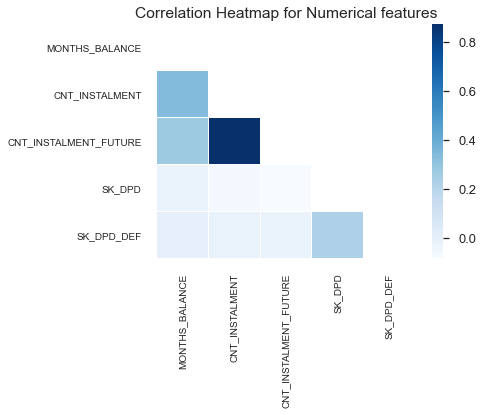

----------------------------------------------------------------------------------------------------


In [110]:
corr_mat = correlation_matrix(
    pos_cash_merged, ['SK_ID_CURR', 'SK_ID_PREV'], figsize=(7, 6))
corr_mat.plot_correlation_matrix()

In [111]:
# Seeing the top columns with highest phik-correlation with the target variable in POS_CASH_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


Column Name  Phik-Correlation
2  CNT_INSTALMENT_FUTURE        0.03319407
1         CNT_INSTALMENT        0.03094744
0         MONTHS_BALANCE        0.02739143
3                 SK_DPD        0.01277335
4             SK_DPD_DEF        0.01053897

----------------------------------------------------------------------------------------------------


### <span class="bg-warning"> 6.3  Plotting Continuous Variables<span>  

Tout d'abord, nous allons regrouper par le champ "SK_ID_PREV" et agréger avec la moyenne, de façon à obtenir une ligne moyenne pour chacun des prêts précédents que le client a obtenus.

In [112]:
pos_cash_merged = pos_cash_merged.groupby('SK_ID_PREV').mean()

#### <span class="bg-success"> 6.3.1 Distribution de CNT_INSTALMENT_FUTUR en continu<span> 

Cette colonne décrit le nombre de versements qu'il reste à payer sur le crédit précédent.

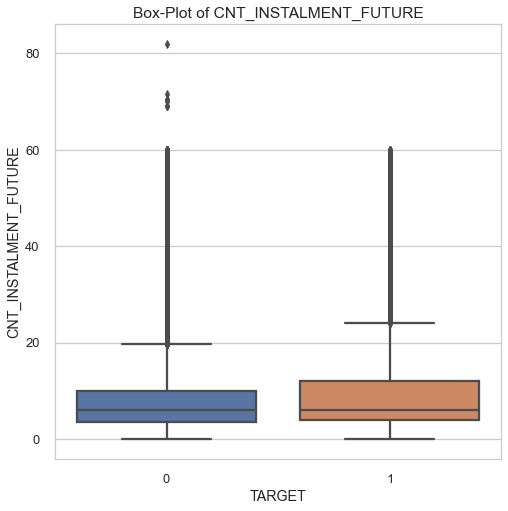

In [113]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots=[
                          'box'], figsize=(8, 8))
del pos_cash_merged

##### Observations et conclusions

Si l'on examine le graphique ci-dessus pour CNT_INSTALMENT_FUTURE, on constate que les valeurs du percentile > 50 % pour les défaillants sont généralement plus élevées que celles des non défaillants. Même la limite supérieure de la moustache pour les défaillants est plus élevée que celle des non défaillants. Cela suggère que les défaillants ont tendance à avoir un plus grand nombre de versements restant sur leurs crédits précédents que les non défaillants.

## <span class="bg-info"> 7.    credit_card_balance.csv<span>  

### <span class="bg-warning"> 7.1 Description de la table et de ses colonnes<span> 

Ce tableau est constitué des données mensuelles relatives à une ou plusieurs cartes de crédit que le demandeur avait auprès du Home Credit Group. Le tableau contient des champs comme le solde, la limite de crédit, le montant des prélèvements, etc. pour chaque mois de la carte de crédit. 

In [114]:
description_colonnes_credit_card_balance = description_colonnes.loc[150: 172, :]
description_colonnes_credit_card_balance

Table                         Row  \
150  credit_card_balance.csv                 SK_ID_PREV    
151  credit_card_balance.csv                  SK_ID_CURR   
152  credit_card_balance.csv              MONTHS_BALANCE   
153  credit_card_balance.csv                 AMT_BALANCE   
154  credit_card_balance.csv     AMT_CREDIT_LIMIT_ACTUAL   
155  credit_card_balance.csv    AMT_DRAWINGS_ATM_CURRENT   
156  credit_card_balance.csv        AMT_DRAWINGS_CURRENT   
157  credit_card_balance.csv  AMT_DRAWINGS_OTHER_CURRENT   
158  credit_card_balance.csv    AMT_DRAWINGS_POS_CURRENT   
159  credit_card_balance.csv     AMT_INST_MIN_REGULARITY   
160  credit_card_balance.csv         AMT_PAYMENT_CURRENT   
161  credit_card_balance.csv   AMT_PAYMENT_TOTAL_CURRENT   
162  credit_card_balance.csv    AMT_RECEIVABLE_PRINCIPAL   
163  credit_card_balance.csv               AMT_RECIVABLE   
164  credit_card_balance.csv        AMT_TOTAL_RECEIVABLE   
165  credit_card_balance.csv    CNT_DRAWINGS_ATM_CURRENT   
166  credit_card_balance.csv        CNT_DRAWINGS_CURRENT   
167  credit_card_balance.csv  CNT_DRAWINGS_OTHER_CURRENT   
168  credit_card_balance.csv    CNT_DRAWINGS_POS_CURRENT   
169  credit_card_balance.csv   CNT_INSTALMENT_MATURE_CUM   
170  credit_card_balance.csv        NAME_CONTRACT_STATUS   
171  credit_card_balance.csv                      SK_DPD   
172  credit_card_balance.csv                  SK_DPD_DEF   

                                                                                                                                           Description  \
150  ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)   
151                                                                                                                           ID of loan in our sample   
152                                                                 Month of balance relative to application date (-1 means the freshest balance date)   
153                                                                                                        Balance during the month of previous credit   
154                                                                                          Credit card limit during the month of the previous credit   
155                                                                                      Amount drawing at ATM during the month of the previous credit   
156                                                                                             Amount drawing during the month of the previous credit   
157                                                                                   Amount of other drawings during the month of the previous credit   
158                                                                             Amount drawing or buying goods during the month of the previous credit   
159                                                                                          Minimal installment for this month of the previous credit   
160                                                                                How much did the client pay during the month on the previous credit   
161                                                                       How much did the client pay during the month in total on the previous credit   
162                                                                                             Amount receivable for principal on the previous credit   
163                                                                                                           Amount receivable on the previous credit   
164                                                                                                     Total amount receivable on the previous credit   
165                                                                                 Number of drawings at ATM during t

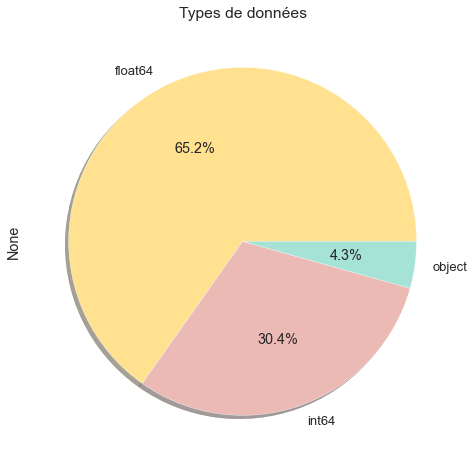

In [115]:
pie_dtypes(cc_balance)

### <span class="bg-warning"> 7.2  Basic Stats<span>

In [116]:
print(f'The shape of credit_card_balance.csv is: {cc_balance.shape}')
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(cc_balance.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(cc_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(cc_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(
    f'Number of duplicate values in credit_card_balance: {cc_balance.shape[0] - cc_balance.duplicated().shape[0]}')
print('-'*100)
display(cc_balance.head(5))

The shape of credit_card_balance.csv is: (3840312, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

##### Observations et conclusions

<ol><li>Il y a environ 3,84M lignes dans le tableau credit_card_balance.csv, chacune d'entre elles correspondant au statut mensuel de la carte de crédit que le demandeur avait auprès de Home Credit Group. Ce tableau contient 23 caractéristiques qui contiennent les statistiques sur le statut mensuel de la carte de crédit, telles que le montant du solde, le montant des tirages, le nombre de tirages, le statut, etc.
    <Il existe 104,3 000 cartes de crédit uniques dont les détails figurent dans ce tableau.
    <li>De ces 104,3k, il y a 103,5k SK_ID_CURR unique. Cela signifie que la plupart des demandeurs n'avaient qu'une seule carte de crédit sur eux, et que peu d'entre eux en avaient plus d'une. Ces SK_ID_CURR sont les identifiants des demandeurs qui ont actuellement demandé un prêt.</li>
    <li>Sur les 103k de SK_ID_CURR unique, 86,9k de ces candidats appartiennent à l'ensemble de formation, et 16,6k à l'ensemble d'application test.</li>
    <li>Sur les 307k de demandeurs dans le tableau application_train, seuls 86,9k d'entre eux avaient une carte de crédit auparavant auprès de Home Credit Group.

#### <span class="bg-success"> 7.2.1 NaN Columns and Percentages<span> 

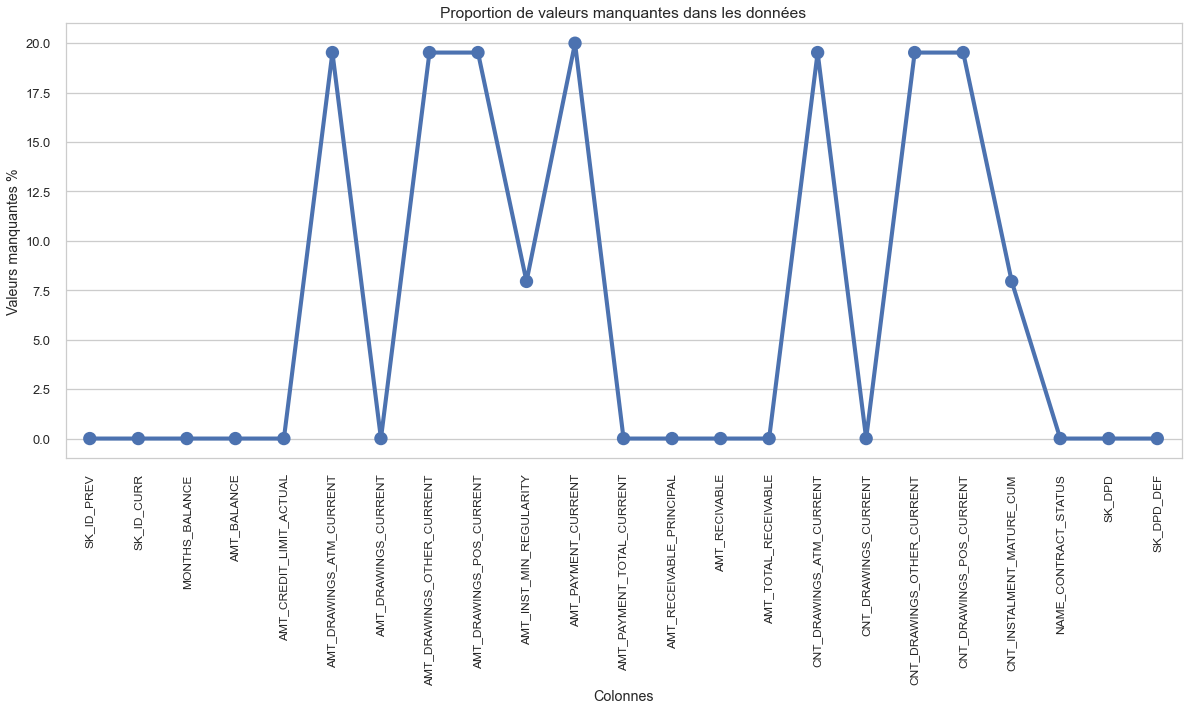

In [117]:
val_manq(cc_balance)

----------------------------------------------------------------------------------------------------
Number of columns having NaN values: 9 columns


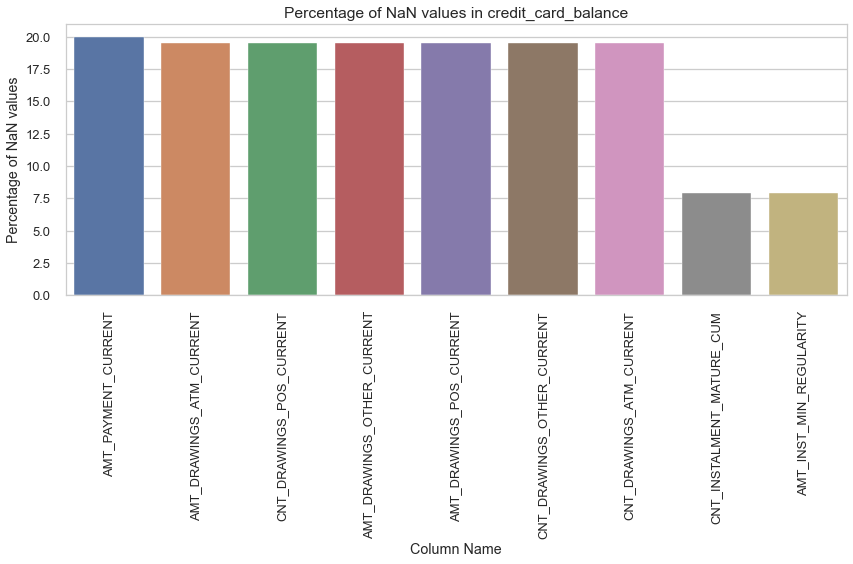

----------------------------------------------------------------------------------------------------


In [118]:
cc_balance_nan = nan_df_create(cc_balance)
print('-'*100)
plot_nan_percent(cc_balance_nan, 'credit_card_balance',
                 tight_layout=False, rotation=90, figsize=(14, 5))
print('-'*100)
del cc_balance_nan

##### Observations et conclusions

<ol><li>Sur les 23 caractéristiques, 9 d'entre elles contiennent des valeurs de NaN.</li>
    <li>Si nous examinons les pourcentages des valeurs de NaN, ils sont considérablement inférieurs au reste des tableaux que nous avons vus jusqu'à présent.</li>
    <li>7 de ces caractéristiques ont des valeurs proches de 20 % de NaN. Ces caractéristiques sont principalement liées aux montants des tirages et aux nombres de tirages. Deux autres de ces caractéristiques sont liées aux statistiques sur les versements.</li></ol>

#### <span class="bg-success"> 7.2.2 Merging the TARGETS from application_train to credit_card_balance table<span> 

In [119]:
print("-"*100)
print("Merging TARGET with credit_card_balance Table")
cc_balance_merged = application_train.iloc[:, :2].merge(
    cc_balance, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


#### <span class="bg-success"> 7.2.3 Correlation Matrix of Features<span>  

----------------------------------------------------------------------------------------------------


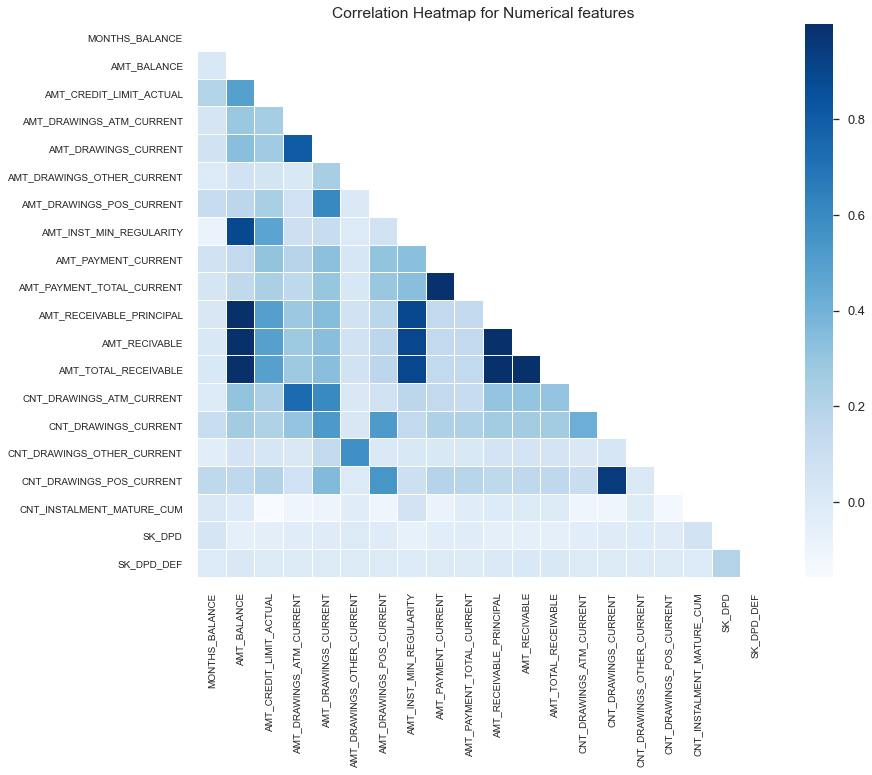

----------------------------------------------------------------------------------------------------


In [120]:
corr_mat = correlation_matrix(
    cc_balance_merged, ['SK_ID_CURR', 'SK_ID_PREV'], figsize=(13, 11))
corr_mat.plot_correlation_matrix()

In [121]:
# Seeing the top columns with highest phik-correlation with the target variable in credit_card_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-" * 100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_BALANCE']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT_LIMIT_ACTUAL']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_ATM_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_OTHER_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_DRAWINGS_POS_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_INST_MIN_REGULARITY']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_PAYMENT_TOTAL_CURRENT']
interval columns not set, guessing: ['TARGET', 'AMT_RECEIVABLE_PRINCIPAL']
interval columns not set, guessing: ['TARGET', 'AMT_RECIVABLE']
interval columns not set, guessing: ['TARGET', 'AMT_TOTAL_RECEIVABLE']
interval columns not set, guessing: ['TARGET', 'CNT_DRAWINGS_ATM_CURREN

Column Name  Phik-Correlation
1                 AMT_BALANCE        0.05983849
11              AMT_RECIVABLE        0.05931075
12       AMT_TOTAL_RECEIVABLE        0.05928730
10   AMT_RECEIVABLE_PRINCIPAL        0.05889478
0              MONTHS_BALANCE        0.05036039
7     AMT_INST_MIN_REGULARITY        0.04217426
17  CNT_INSTALMENT_MATURE_CUM        0.03826134
13   CNT_DRAWINGS_ATM_CURRENT        0.03005164
2     AMT_CREDIT_LIMIT_ACTUAL        0.02875201
14       CNT_DRAWINGS_CURRENT        0.02786844

----------------------------------------------------------------------------------------------------


##### Observations et conclusions :

<ol>
    <li>La carte de chaleur ci-dessus montre visuellement la corrélation entre les caractéristiques du tableau "solde de la carte de crédit".</li>
    <li>De la carte thermique de la matrice de corrélation, nous voyons quelques couples de caractéristiques fortement corrélées. Ce sont :
        <ul><li>AMT_RECEIVABLE_PRINCIPE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE</li>
            <li>Nous observons également une forte corrélation entre ces 3 colonnes AMT_RECEIVABLE</li>
            <li>AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT</li>
        </ul></li>
    <li>Les ensembles de 2ème et 3ème éléments corrélés sont compréhensibles car ils correspondent plus ou moins au même récit.</li>
    <li>La corrélation des caractéristiques avec la variable Target n'est pas perceptible, ce qui montre l'absence de relation linéaire entre la caractéristique et la variable Target.</li></ol>

### <span class="bg-warning"> 7.3 Plotting Continuous Variables<span>

Tout d'abord, nous allons regrouper par le champ "SK_ID_PREV" et agréger avec la moyenne, de façon à obtenir une ligne moyenne pour chacun des prêts précédents que le client a obtenus.

In [122]:
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()

#### <span class="bg-success"> 7.3.1 Distribution de l'AMT_BALANCE<span> 

Cette colonne indiquait le montant moyen du solde qu'une personne avait habituellement sur son compte de prêt de carte de crédit pour un prêt précédent.

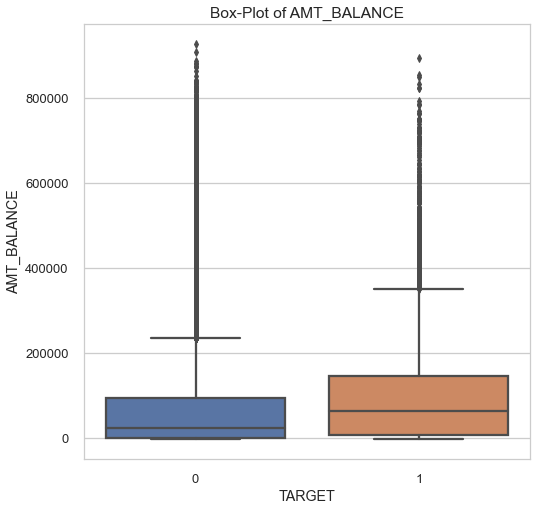

In [123]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots=[
                          'box'], figsize=(8, 8))

##### Observations et conclusions

Sur le graphique ci-dessus, on peut voir que les défaillants ont une valeur de AMT_BALANCE plus élevée que les non défaillants. Ils affichent des valeurs plus élevées pour tous les quantiles et même pour les moustaches. Cela pourrait signifier que le montant du crédit pour les défaillants pourrait également être relativement plus élevé par rapport aux non défaillants.

##### Observations et conclusions :

Nous constatons que les défaillants semblent ici aussi avoir un versement minimum plus élevé chaque mois par rapport aux non défaillants. Cela renseigne généralement sur les habitudes de dépense et d'emprunt des personnes. Les défaillants ont des habitudes de dépenses et d'emprunt plus élevées que les non défaillants.

#### <span class="bg-success"> 7.3.2 Distribution de l' Distribution des AMT_TOTAL_RECEIVABLE<span>

Cette colonne décrit la moyenne du montant total à recevoir sur le crédit précédent.

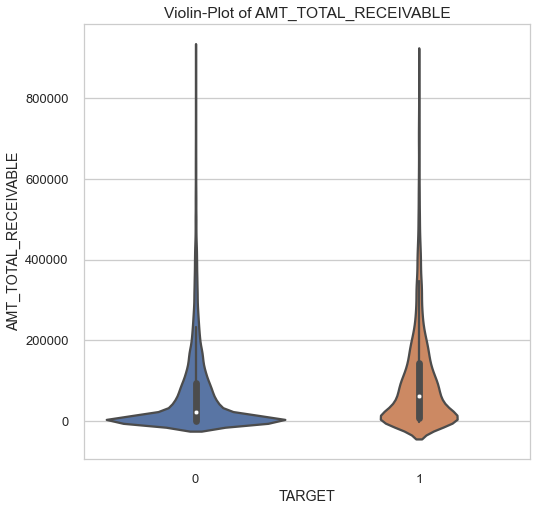

In [124]:
plot_continuous_variables(cc_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots=[
                          'violin'], figsize=(8, 8))

##### Observations et conclusions

Si l'on examine le box plot de AMT_TOTAL_RECEIVABLE, on constate un comportement similaire à celui observé avec d'autres montants, à savoir que les défaillants avaient généralement un montant à recevoir plus élevé sur leur crédit précédent, ce qui peut impliquer les montants de crédits plus élevés qu'ils ont pu prendre. Le PDF montre également un pic très élevé à des montants plus faibles pour les non défaillants par rapport aux défaillants.

#### <span class="bg-success"> 7.3.3 Distribution des CNT_INSTALMENT_MATURE_CUM en continu<span>

La colonne décrit à peu près le nombre moyen de versements effectués sur les crédits précédents.

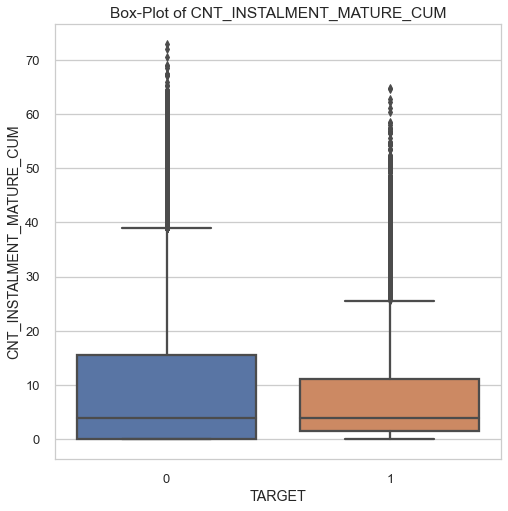

In [125]:
plot_continuous_variables(
    cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots=['box'], figsize=(8, 8))

##### Observations et conclusions

Du graphique ci-dessus, nous voyons un comportement très intéressant. Ce graphique montre que les non défaillants ont généralement une fourchette de valeurs plus élevée pour le nombre de versements payés que les défaillants. Cela pourrait indiquer le comportement des défaillants, qui, en règle générale, paient moins de versements sur leur crédit précédent.

## <span class="bg-danger">Conclusions de l'EDA<span>  

L'analyse exhaustive des données d'exportation que nous avons effectuée nous permet de tirer des conclusions de haut niveau sur notre ensemble de données.
<ol><li> Premièrement, l'ensemble des données devra être fusionné avec une méthode ingénieuse pour que les données fusionnées aient un sens.</li>
    <li>Certaines catégories sont très bien discriminatoires entre les défaillants et les non défaillants, ce qui pourrait être important aux fins de la classification.</li>
    <li>Il y a peu de variables numériques continues qui contiennent des points erronés, nous devrions traiter ces points.</li>
    <li>Nous avons également remarqué certaines caractéristiques corrélées, qui ne feraient qu'augmenter la dimensionnalité des données, sans grande valeur ajoutée. Nous voudrions supprimer ces caractéristiques.
    <li>L'ensemble des données est globalement déséquilibré et nous devrions trouver des techniques pour gérer ce déséquilibre.</li>
    <li>Pour la prévision du risque de défaillance, les défaillants ont généralement tendance à avoir un comportement qui n'est pas normal, et nous ne pouvons donc pas supprimer les valeurs aberrantes ou les points éloignés, car ils peuvent suggérer une importante tendance à la défaillance. </li>
    <li>Avec tous ces éléments, nous allons passer au cleaning et au feature engineering. </li></ol>